In [11]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd
from glob import iglob
from natsort import natsorted

def fix_setting_label(s):
    s = s.replace('mergedTrue', 'merged')
    s = s.replace('frozen0', 'finetuneALL')
    s = s.replace('frozen15', 'finetuneLITTLE')
    s = s.replace('frozen5', 'finetuneMORE')
    s = s.replace('frozen19', 'finetuneNONE')
    s = s.replace('mergedFalse', 'unmerged')
    s = s.replace('nr0', 'finetuneALL')
    s = s.replace('nr15', 'finetuneLITTLE')
    s = s.replace('nr5', 'finetuneMORE')
    s = s.replace('nr19', 'finetuneNONE')
    return s

# %matplotlib widget
sb.set()
data_setting = 'raw'
merged = 'mergedTrue'
fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/{data_setting}_{merged}*")))
df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
df = df[0].apply(pd.Series)
dfcols = ['dtype','merged','nrlayers','samples','val','trial']
df.columns = dfcols

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dtype     660 non-null    object
 1   merged    660 non-null    object
 2   nrlayers  660 non-null    object
 3   samples   660 non-null    object
 4   val       660 non-null    object
 5   trial     660 non-null    object
dtypes: object(6)
memory usage: 31.1+ KB


In [13]:
settings = []
concat_list = []
for i, sub in df.groupby(dfcols):
#     plt.figure(figsize=(14,8))
    setting = f"{sub.dtype.unique()[0]}_{sub.merged.unique()[0]}_{sub.nrlayers.unique()[0]}_{sub.samples.unique()[0]}_{sub.val.unique()[0]}_{sub.trial.unique()[0]}"
    settings.append(setting)
    result = dd.io.load(f"{TEMP_DATADIR}/{setting}.csv")
    series = pd.Series({'samples': result['nr_samples'], 'bacc': result['balanced_accuracy_score'],
              'trial': result['trial'], 'frozen_layers': result['frozen_layers'], 'valset': sub.val.unique()[0]})
    concat_list.append(series)


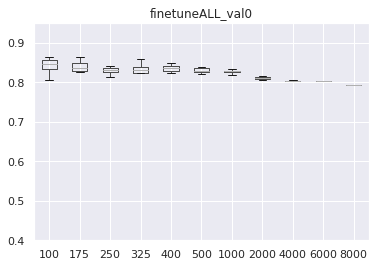

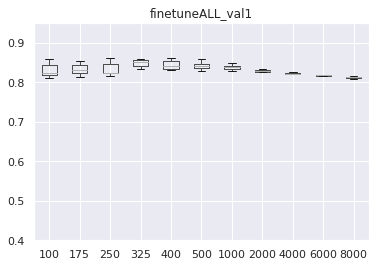

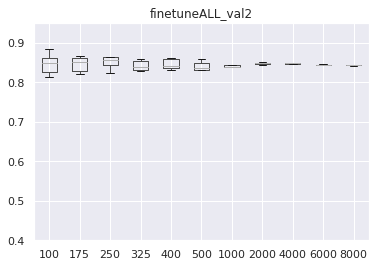

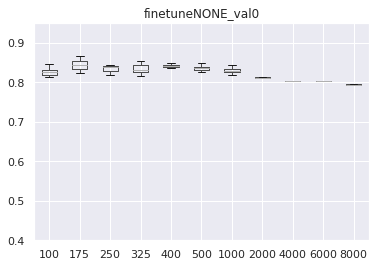

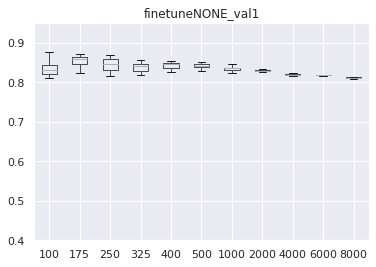

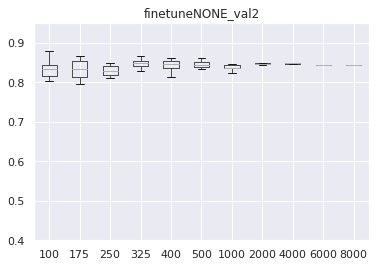

In [14]:
pd.options.mode.chained_assignment = None  # default='warn'

allsamples = [100, 175, 250, 325, 400, 500, 1000, 2000, 4000, 6000, 8000]
df2 = pd.concat(concat_list, axis=1).T
all_subs = {}
c = 0
for i, sub in df2.groupby(['frozen_layers','valset']):
    plt.figure()
    sub['bacc'] = sub['bacc'].apply(pd.to_numeric) 
    tmplist = []
    for j, subdf in sub.groupby(['samples']):
        tmp = subdf.bacc.reset_index(drop=True)
        tmp.name = subdf.samples.unique()[0]
        tmplist.append(tmp)
    pd.concat(tmplist, axis=1).boxplot(showfliers=False)
    title = f"frozen{sub.frozen_layers.unique()[0]}_{sub.valset.unique()[0]}"
    plt.title(fix_setting_label(title))
    plt.ylim(0.4, .95)
    plt.savefig(f'/home/kalfasyan/Desktop/results/{data_setting}_{merged}/{fix_setting_label(title)}.png', format='png', bbox_inches='tight')

In [15]:
plt.close('all')

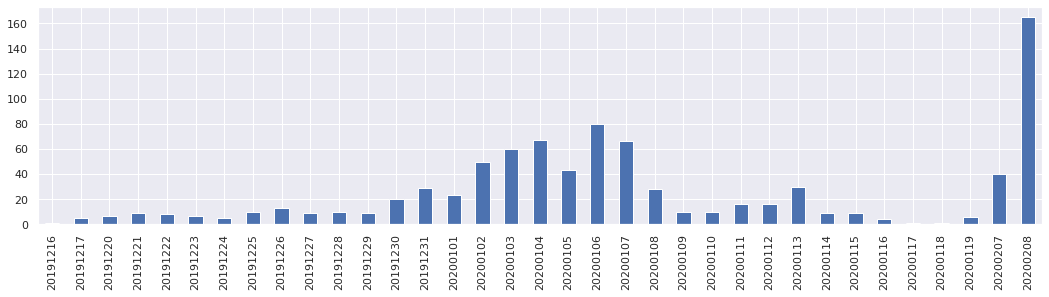

In [16]:
from wavhandler import get_wingbeat_dates
import seaborn as sns
plt.figure(figsize=(18,4))
tmp = get_wingbeat_dates(pd.read_csv(f"{TEMP_DATADIR}/Test_data.csv").fpaths)[2]
z = pd.DataFrame({'dates': tmp}).sort_values(by='dates')
z.dates.value_counts()[z.dates.unique()].plot(kind='bar')

# sns.barplot(x="dates", y="misclas1", hue="misclas0" ,data=example)

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


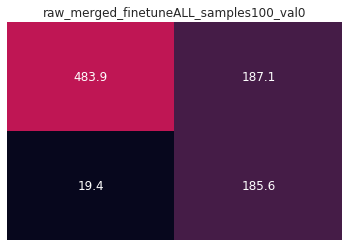

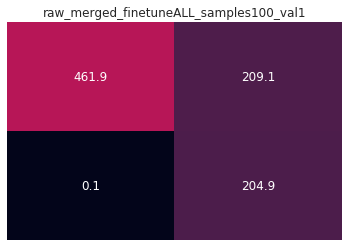

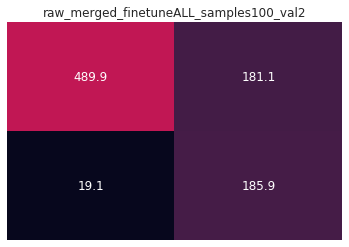

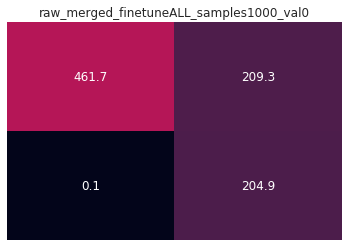

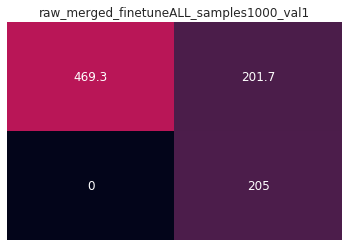

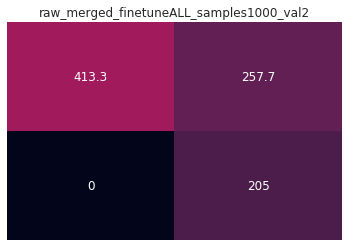

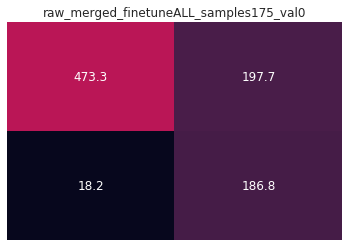

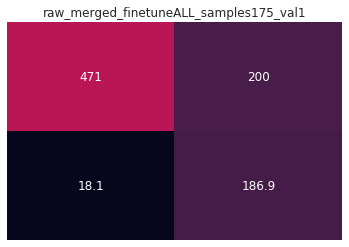

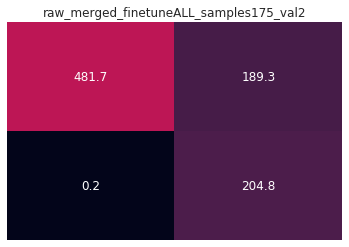

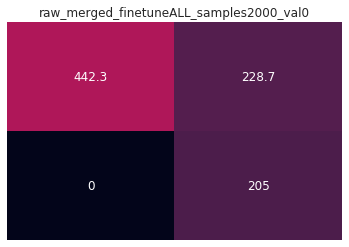

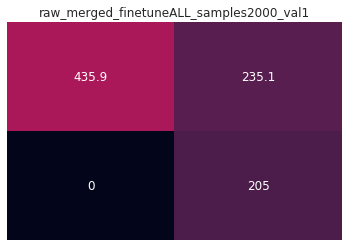

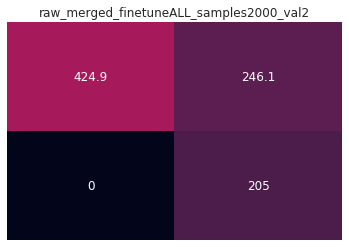

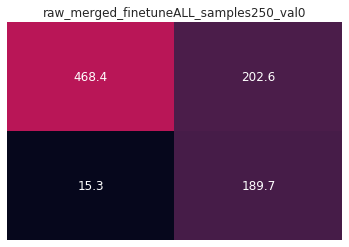

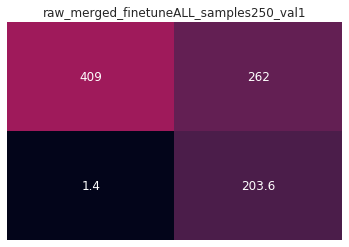

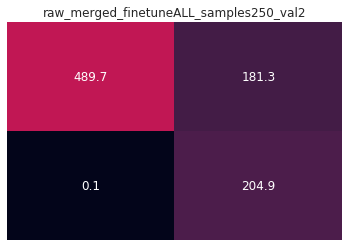

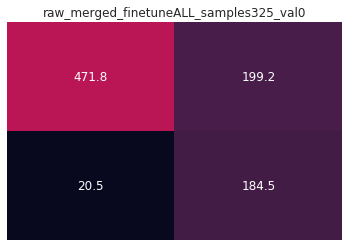

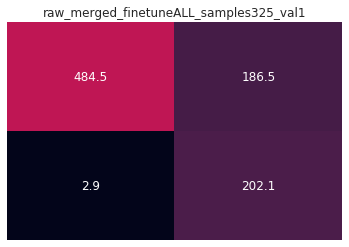

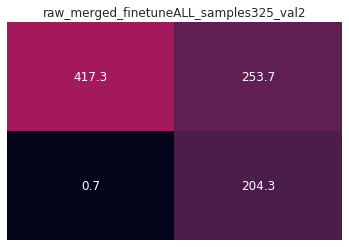

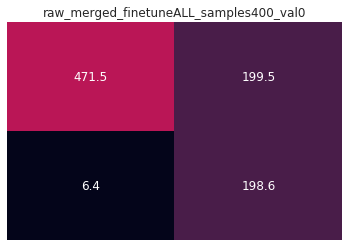

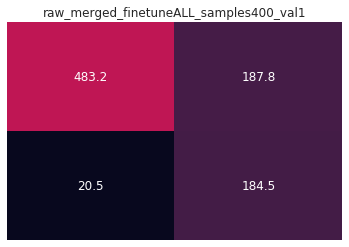

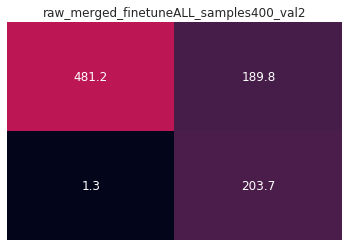

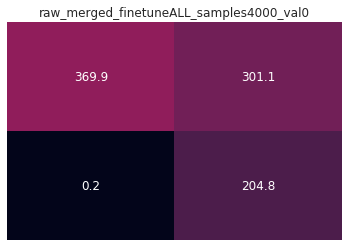

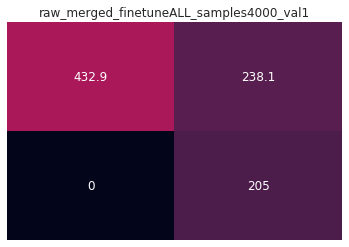

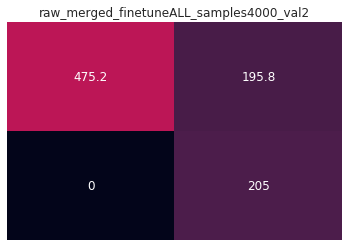

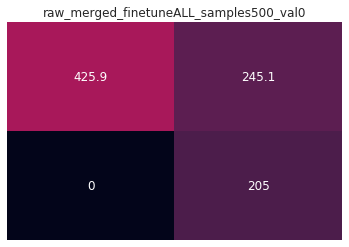

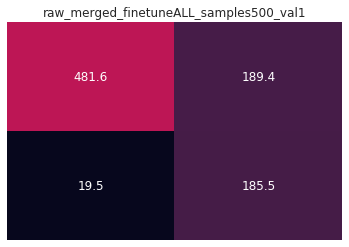

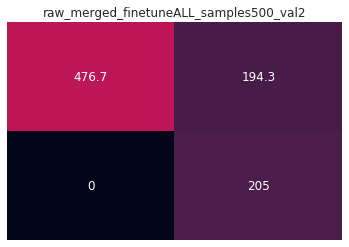

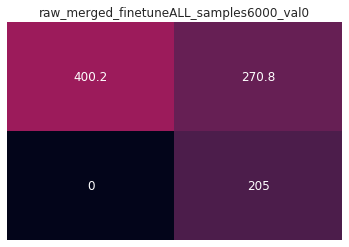

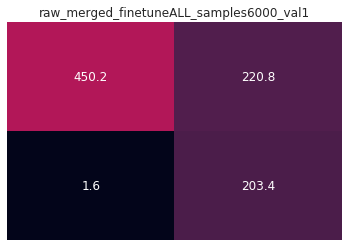

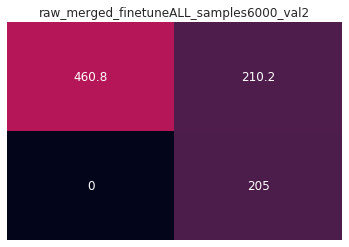

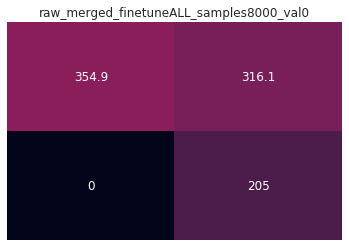

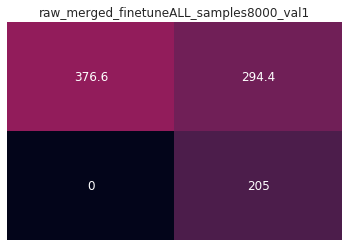

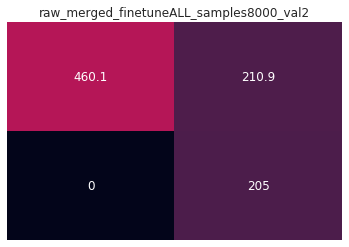

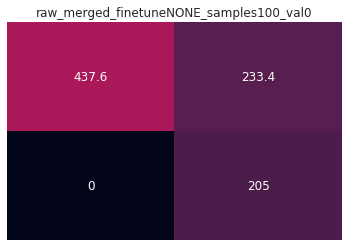

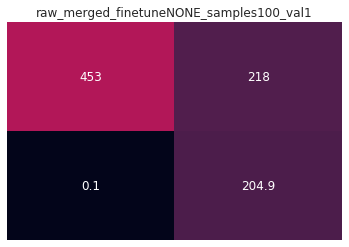

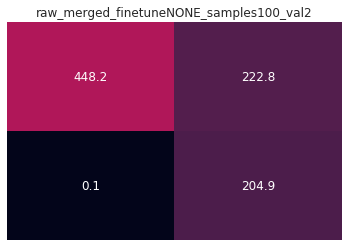

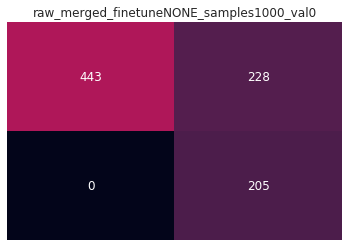

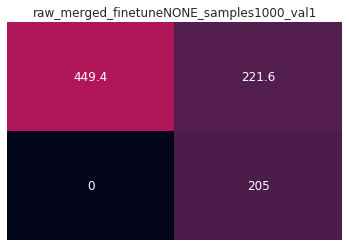

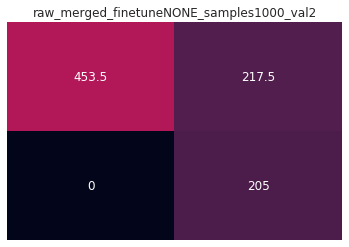

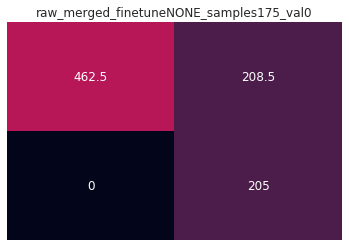

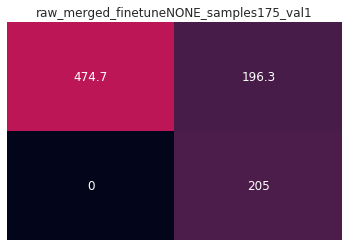

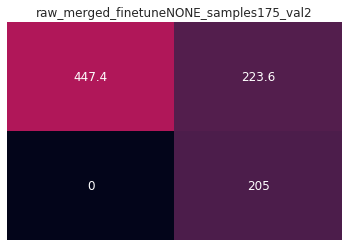

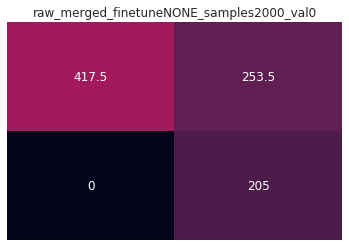

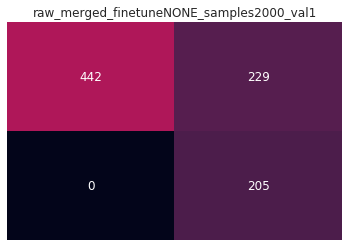

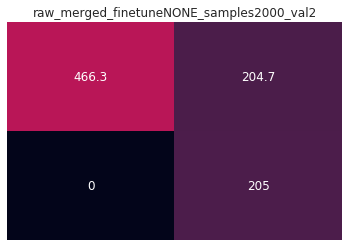

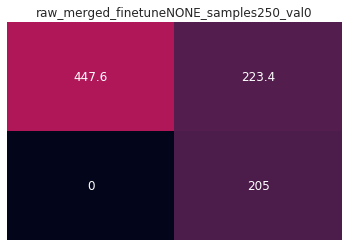

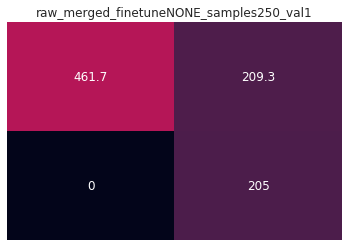

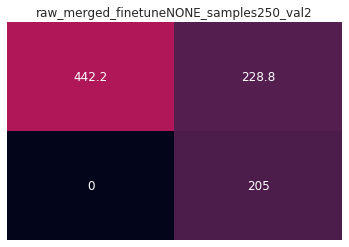

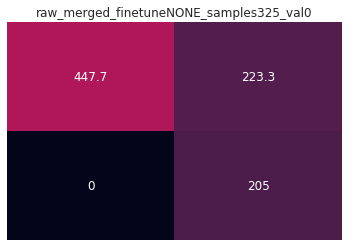

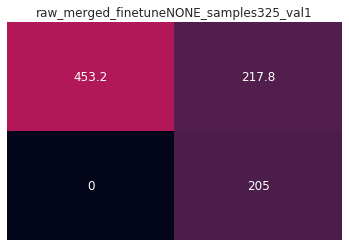

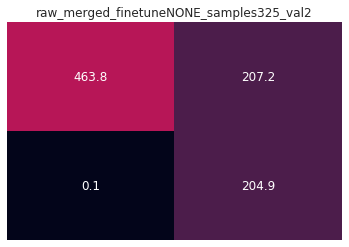

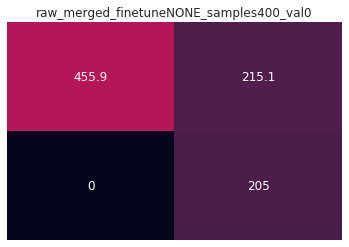

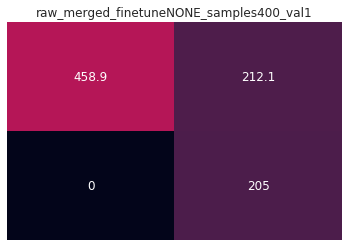

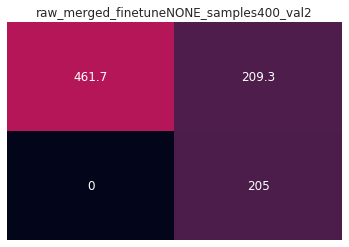

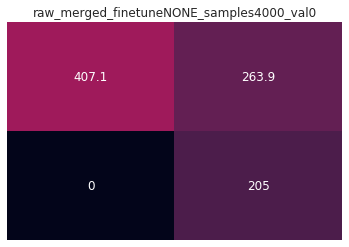

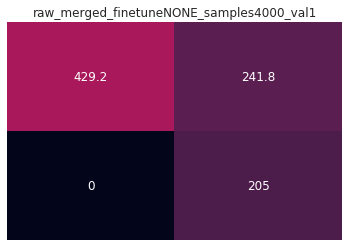

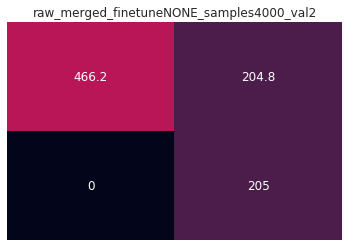

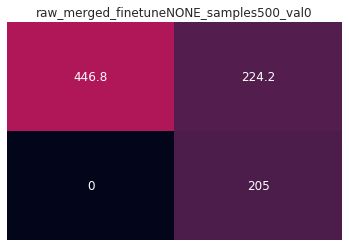

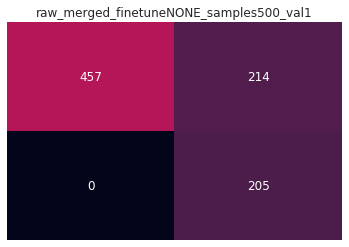

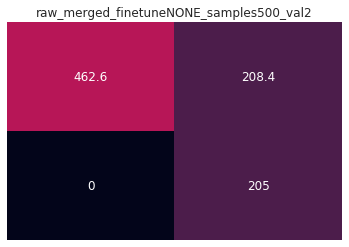

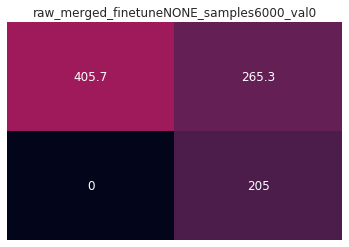

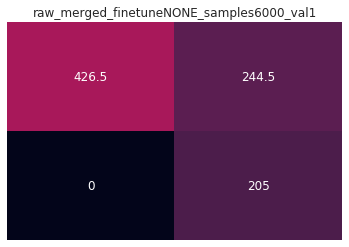

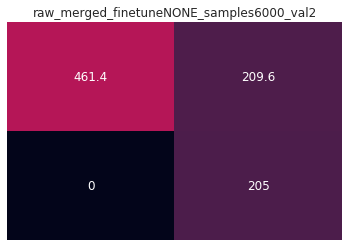

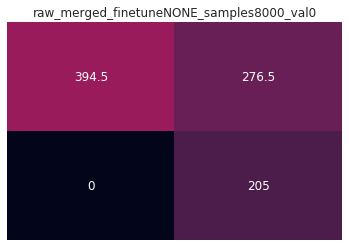

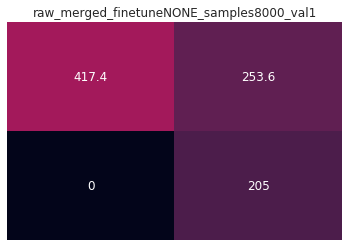

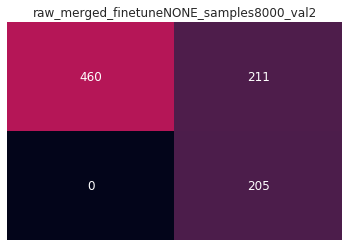

In [17]:
settings = []

for i, sub in df.groupby(['merged','nrlayers','samples','val']):
    cm_list = []
    setting = f"{sub.dtype.unique()[0]}_{sub.merged.unique()[0]}_{sub.nrlayers.unique()[0]}_{sub.samples.unique()[0]}_{sub.val.unique()[0]}_{sub.trial.unique()[0]}"
    settings.append(setting)
    for s in range(10):
        cm = dd.io.load(f"{TEMP_DATADIR}/{sub.dtype.unique()[0]}_{sub.merged.iloc[0]}_{sub.nrlayers.iloc[0]}_{sub.samples.iloc[0]}_{sub.val.iloc[0]}_trial{s}.csv")['cm']
        cm_list.append(cm.flatten())
    plt.figure()
    avg_cm = np.vstack(cm_list).mean(axis=0).reshape(2,2)
    sb.heatmap(avg_cm, annot=True, fmt='g', vmin=0, vmax=1028, cbar=False, xticklabels=False, yticklabels=False)
    title = '_'.join(setting.split('_')[:-1])
    plt.title(fix_setting_label(title))
    plt.savefig(f'/home/kalfasyan/Desktop/results/{data_setting}_{merged}/cm_{fix_setting_label(title)}.png', format='png', bbox_inches='tight')
    

In [18]:
def gather_misclassifications(results=None, title=None):
    test_data = pd.read_csv(f"{TEMP_DATADIR}/Test_data.csv")
    test_data['names'] = get_wingbeat_dates(test_data['fpaths'])[0]
    test_data['dates'] = get_wingbeat_dates(test_data['fpaths'])[2]
    test_data['preds'] = results['yf_pred_argmax']

    misclasdict, misclasdict_0, misclasdict_1 = {}, {}, {}
    for idx, subdf in test_data.groupby('dates'):
        cond1 = subdf['labels'] != subdf['preds']
        cond2 = subdf['labels'] == 0
        cond3 = subdf['labels'] == 1
        
        weight = 1#(subdf.shape[0] / test_data.shape[0])
        misclasdict[idx] = np.where(cond1)[0].shape[0] * weight
        misclasdict_0[idx] = np.where(cond1 & cond2)[0].shape[0] * weight
        misclasdict_1[idx] = np.where(cond1 & cond3)[0].shape[0] * weight

    test_data['misclas'] = test_data['dates'].apply(lambda x: misclasdict[x])
    test_data['misclas0'] = test_data['dates'].apply(lambda x: misclasdict_0[x])
    test_data['misclas1'] = test_data['dates'].apply(lambda x: misclasdict_1[x])

    example = test_data.drop(['fpaths','names','preds','labels'], axis=1).melt(id_vars=["dates", "misclas"], 
            var_name="misclas0", 
            value_name="misclas1")
    plt.figure(figsize=(18, 4))
    chart = sns.barplot(x="dates", y="misclas1", hue="misclas0" ,data=example)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.title(title)
    plt.show()

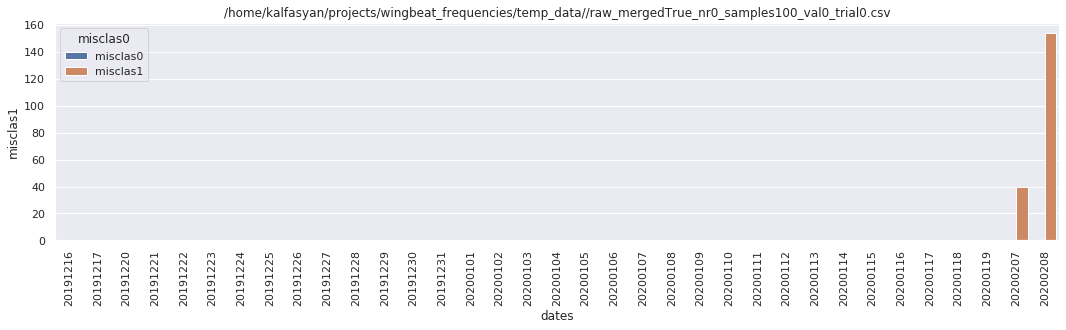

<Figure size 432x288 with 0 Axes>

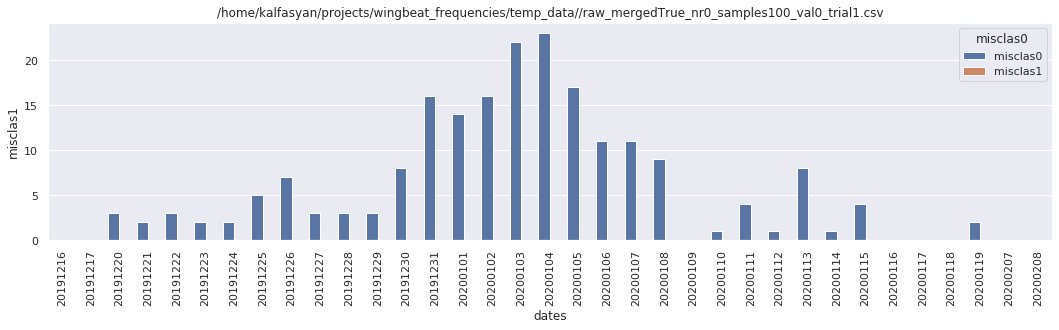

<Figure size 432x288 with 0 Axes>

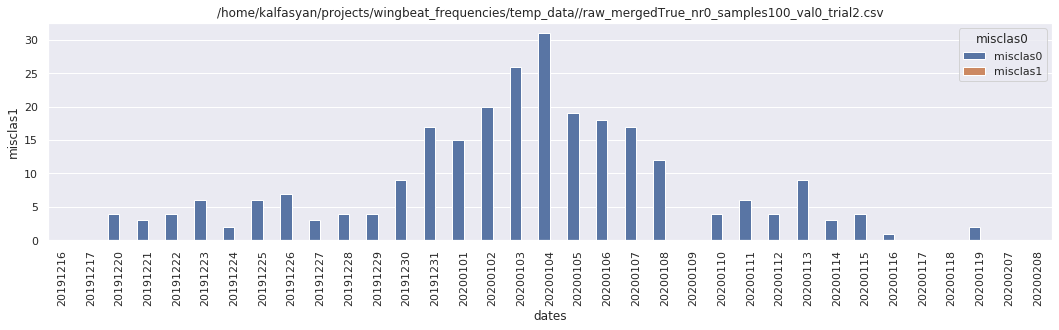

<Figure size 432x288 with 0 Axes>

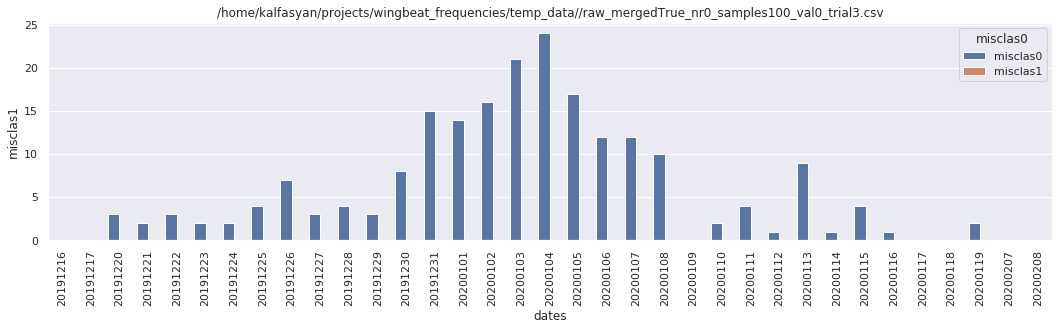

<Figure size 432x288 with 0 Axes>

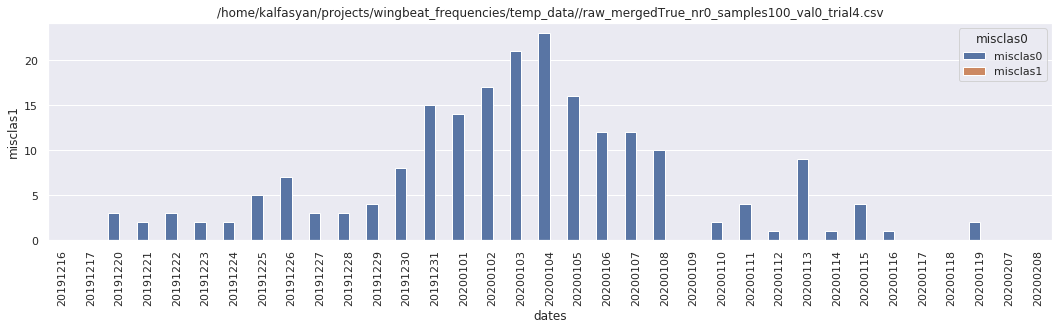

<Figure size 432x288 with 0 Axes>

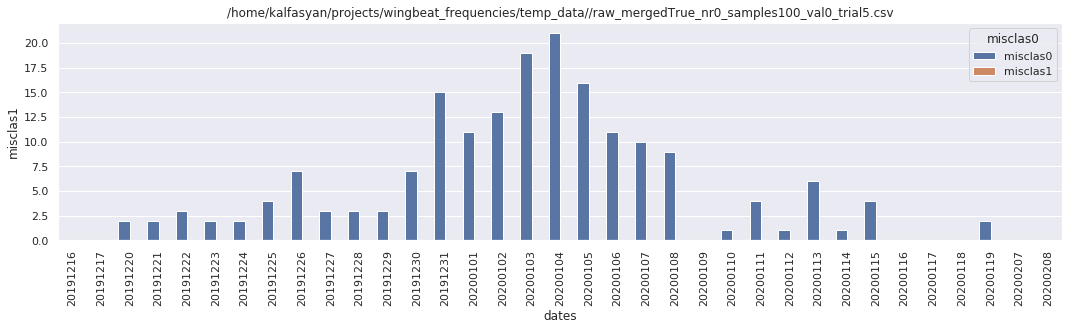

<Figure size 432x288 with 0 Axes>

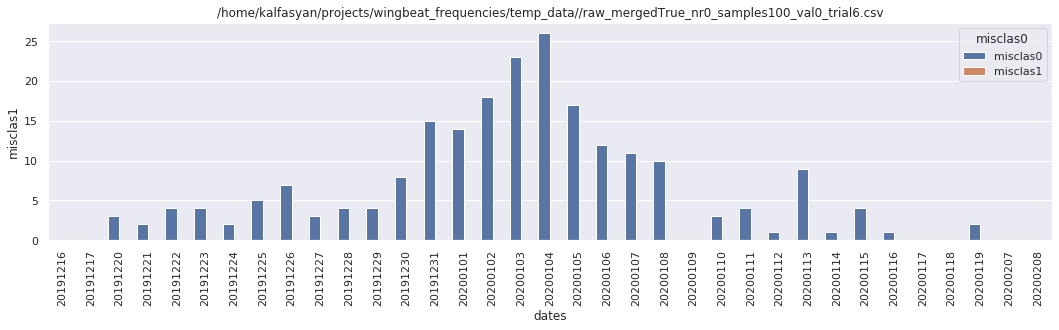

<Figure size 432x288 with 0 Axes>

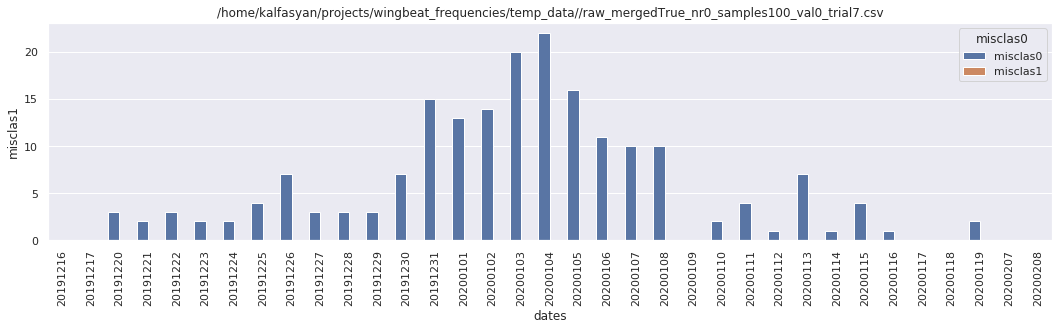

<Figure size 432x288 with 0 Axes>

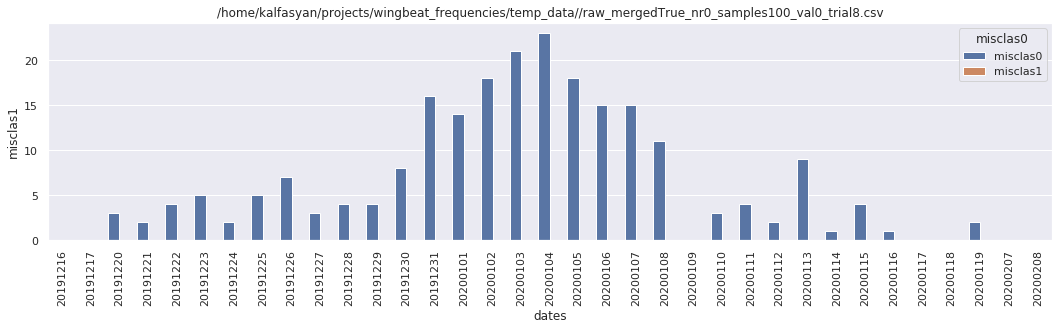

<Figure size 432x288 with 0 Axes>

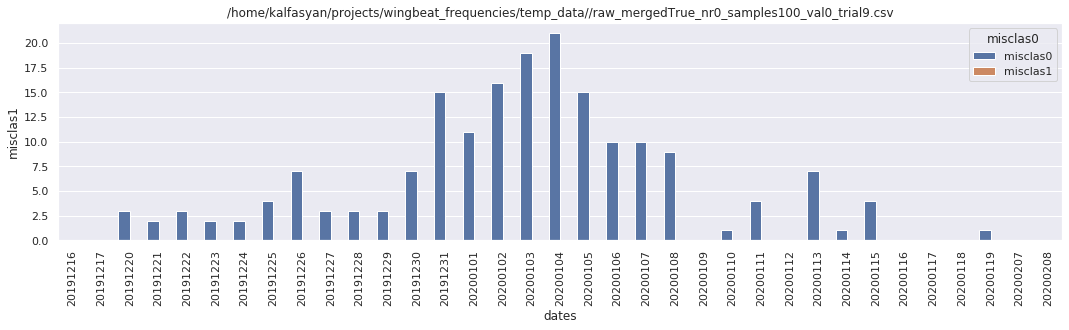

<Figure size 432x288 with 0 Axes>

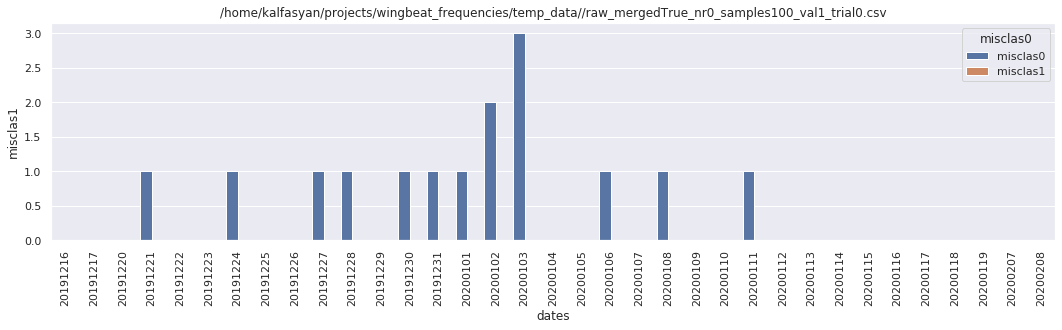

<Figure size 432x288 with 0 Axes>

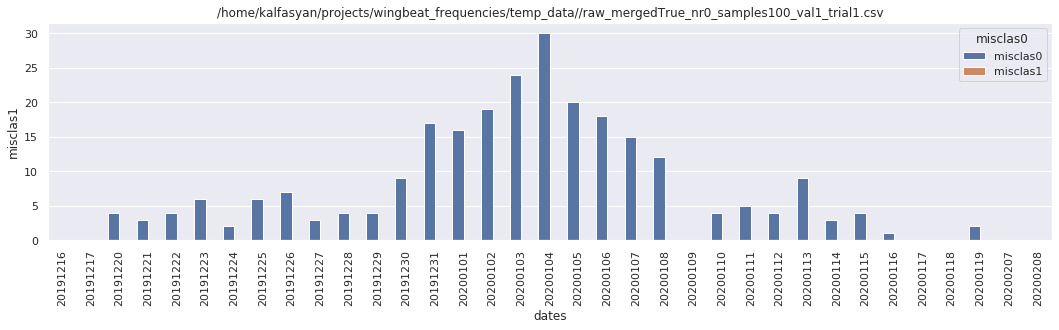

<Figure size 432x288 with 0 Axes>

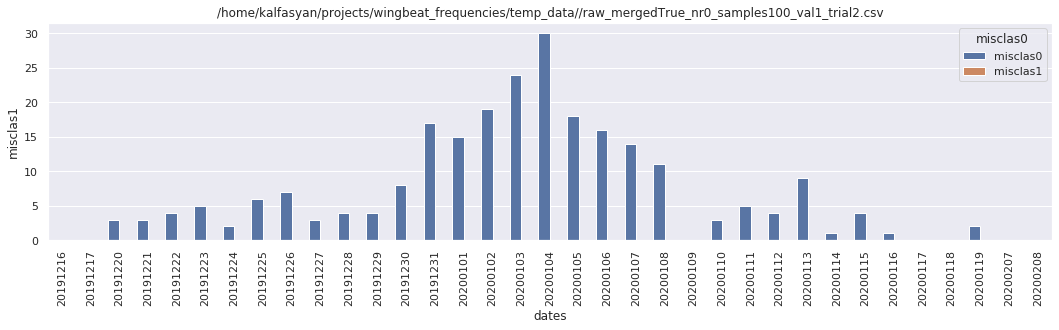

<Figure size 432x288 with 0 Axes>

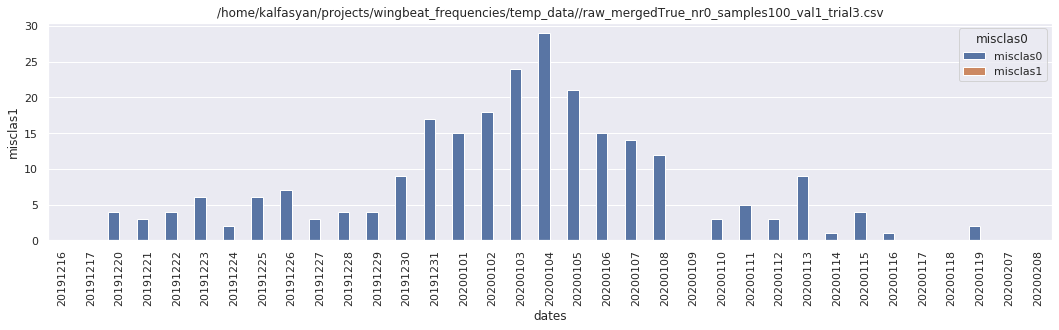

<Figure size 432x288 with 0 Axes>

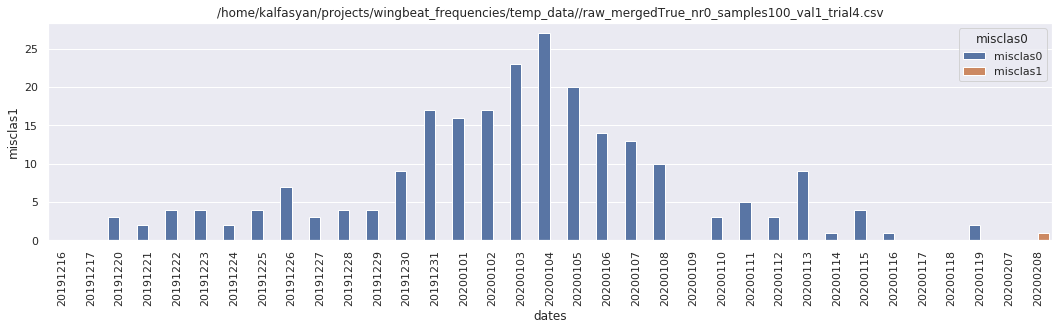

<Figure size 432x288 with 0 Axes>

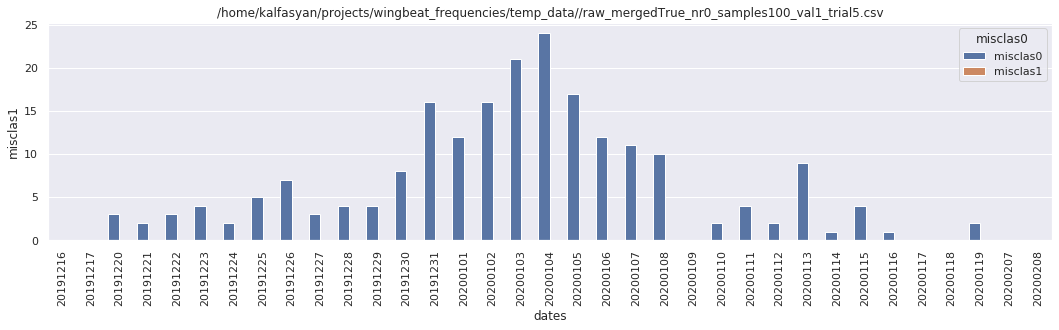

<Figure size 432x288 with 0 Axes>

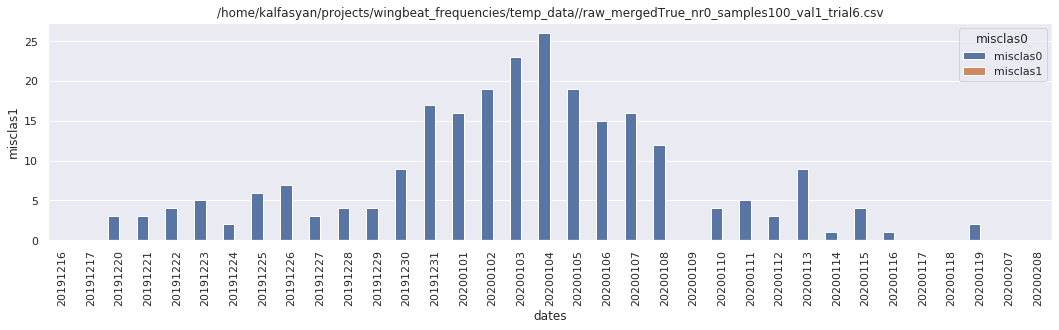

<Figure size 432x288 with 0 Axes>

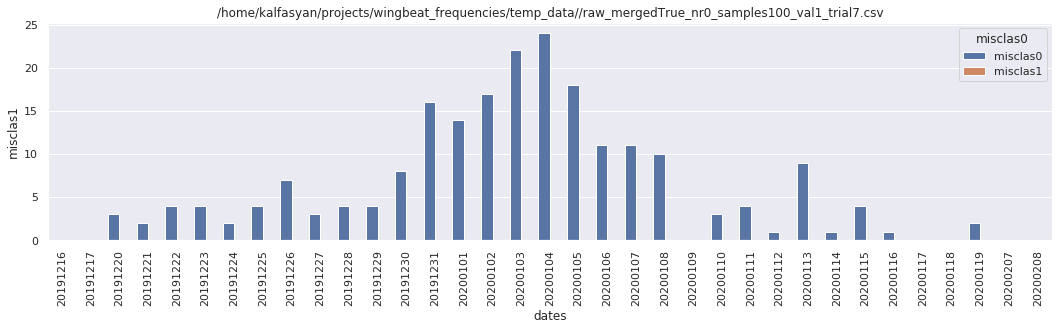

<Figure size 432x288 with 0 Axes>

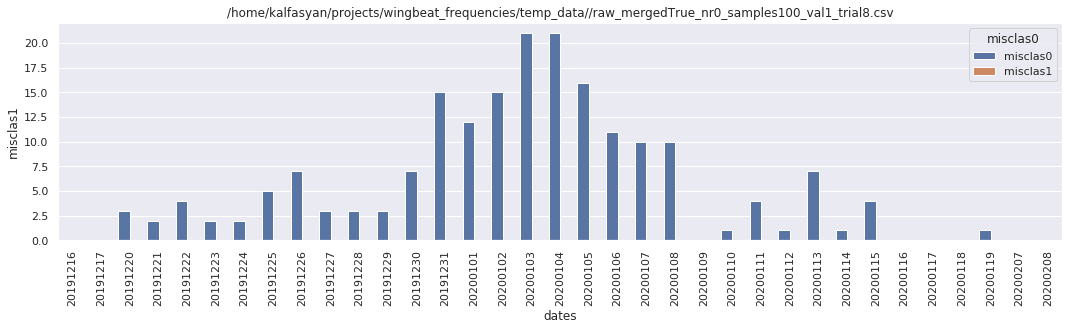

<Figure size 432x288 with 0 Axes>

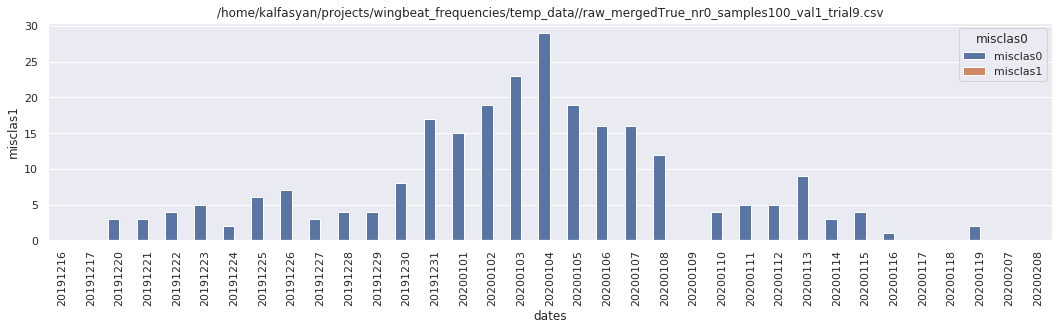

<Figure size 432x288 with 0 Axes>

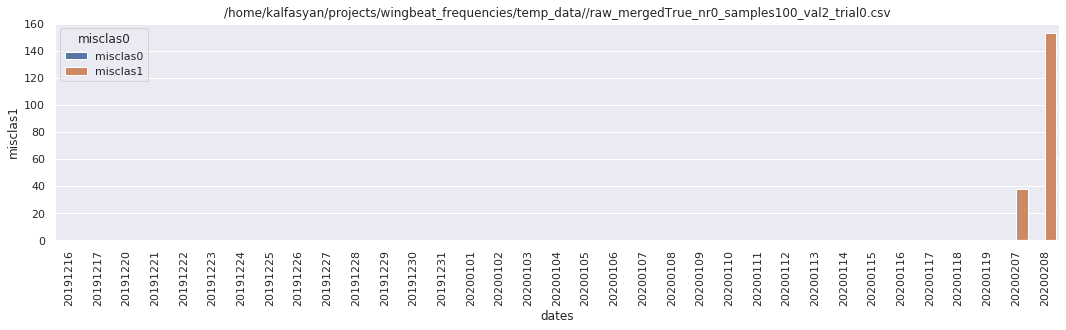

<Figure size 432x288 with 0 Axes>

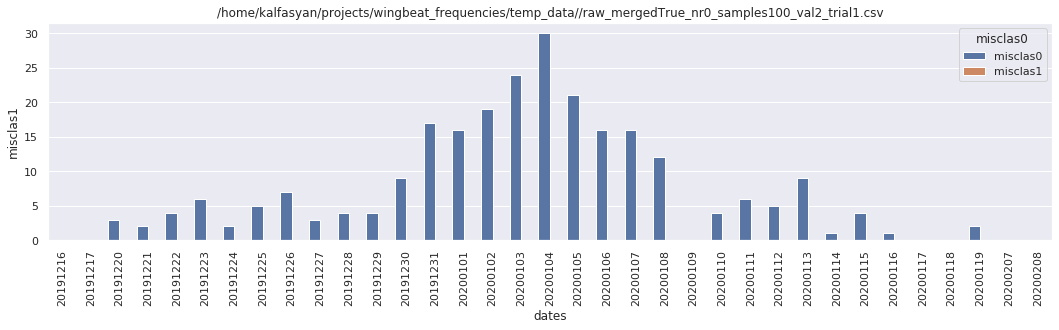

<Figure size 432x288 with 0 Axes>

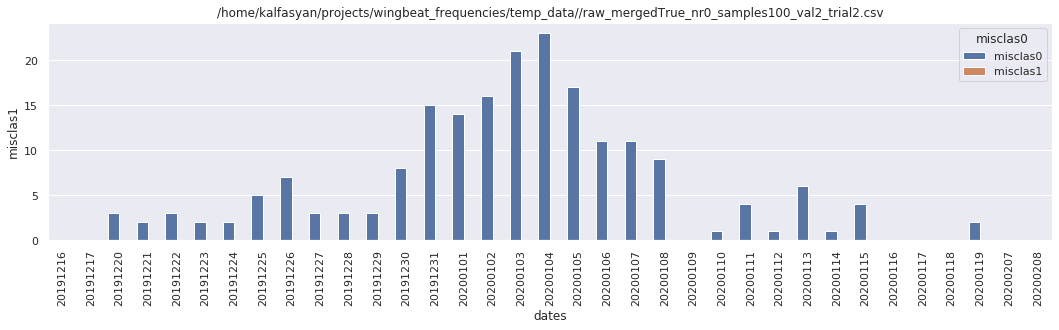

<Figure size 432x288 with 0 Axes>

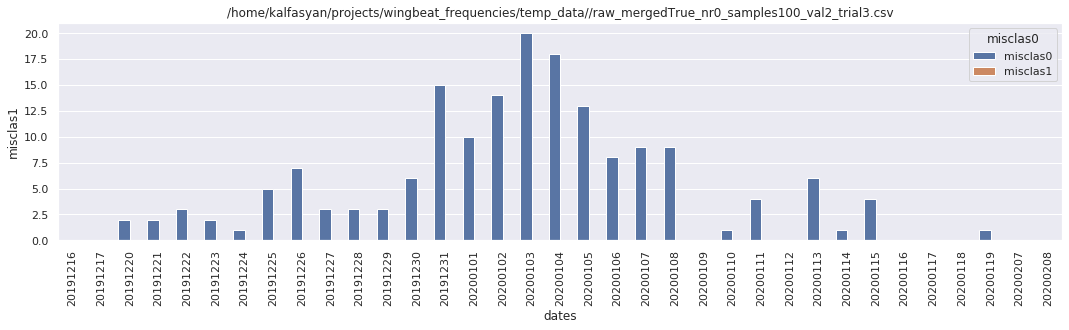

<Figure size 432x288 with 0 Axes>

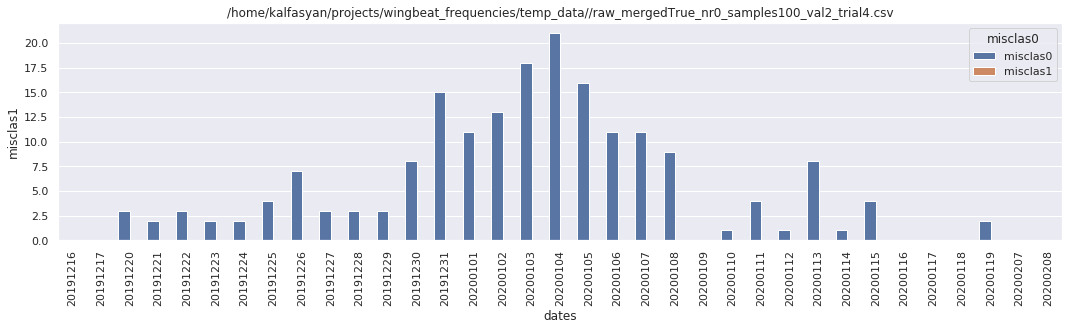

<Figure size 432x288 with 0 Axes>

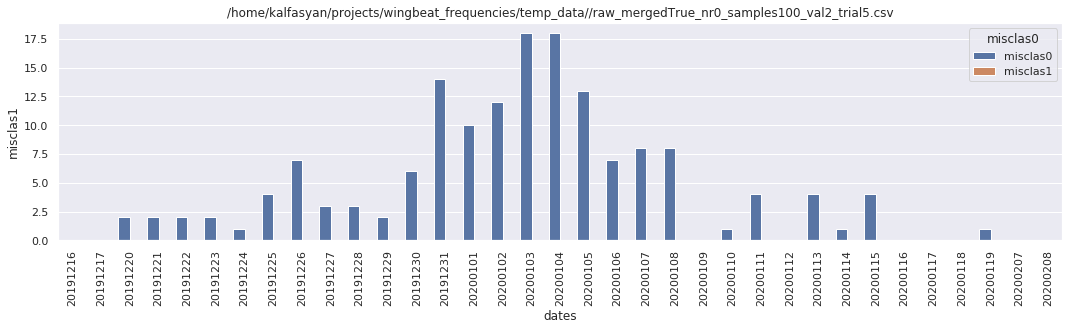

<Figure size 432x288 with 0 Axes>

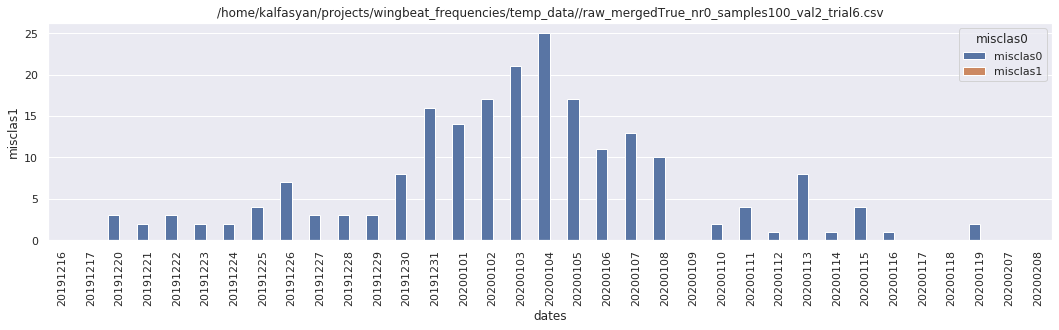

<Figure size 432x288 with 0 Axes>

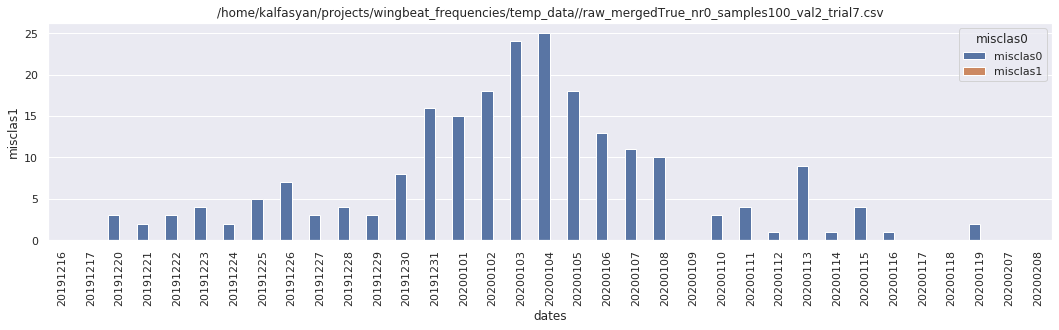

<Figure size 432x288 with 0 Axes>

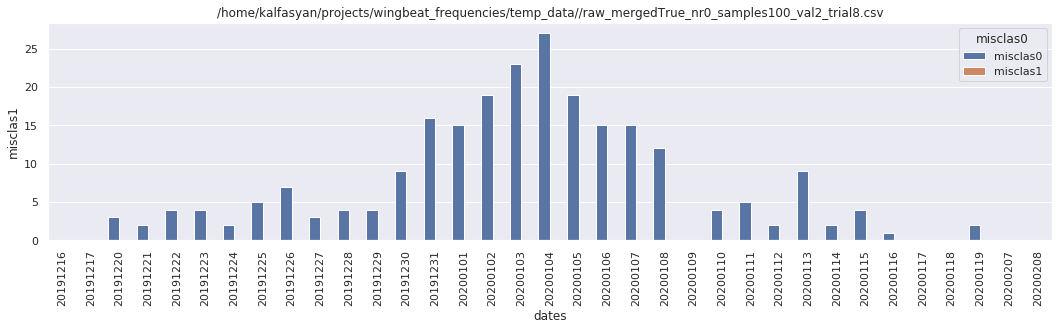

<Figure size 432x288 with 0 Axes>

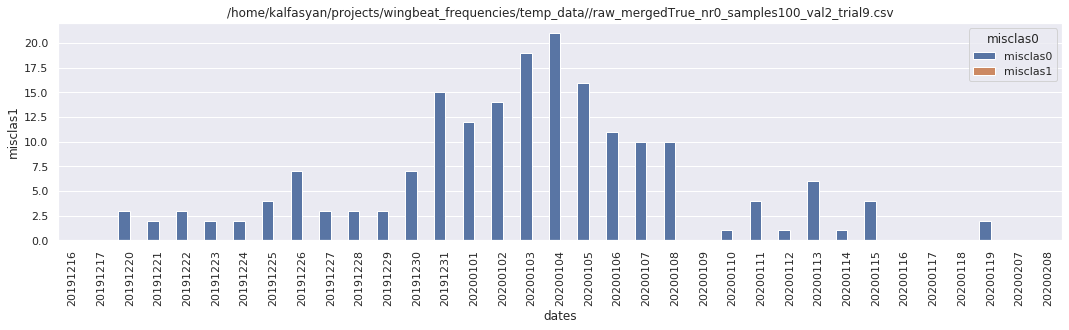

<Figure size 432x288 with 0 Axes>

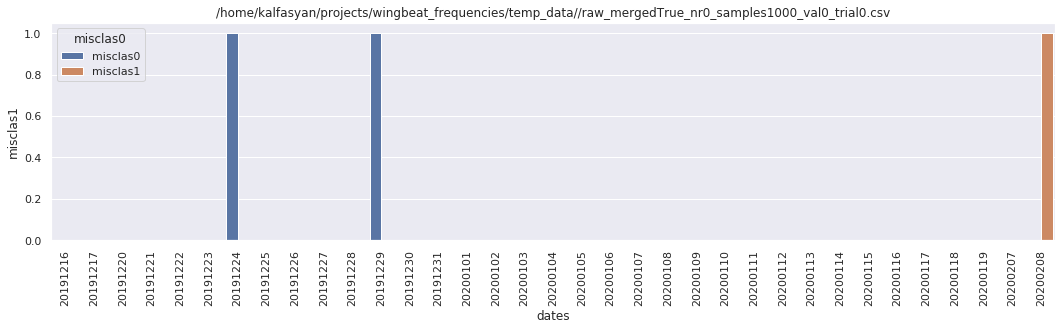

<Figure size 432x288 with 0 Axes>

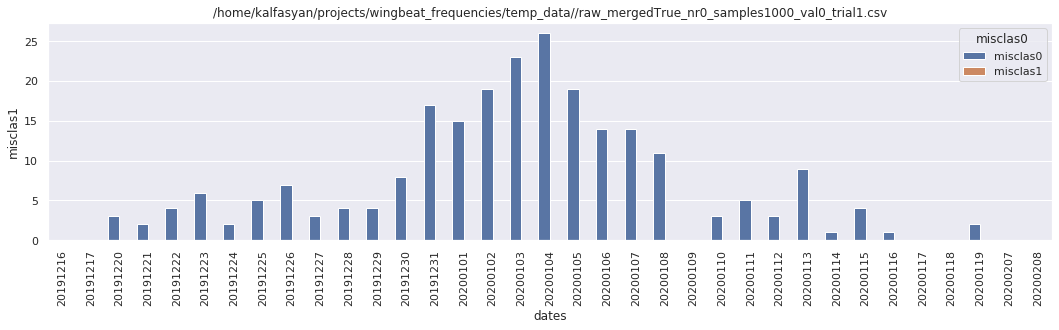

<Figure size 432x288 with 0 Axes>

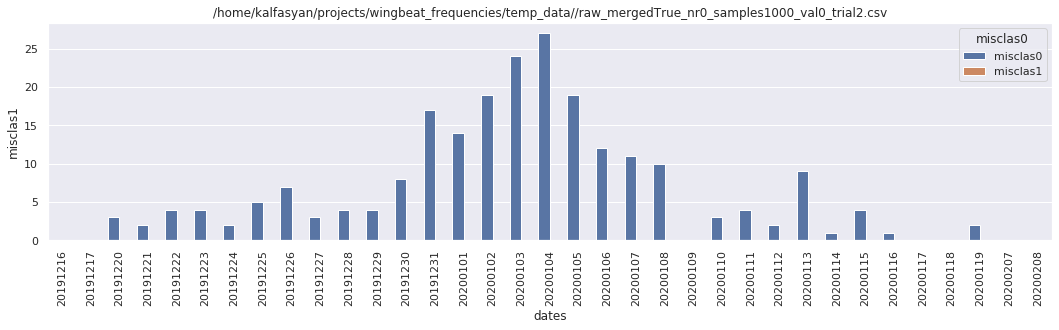

<Figure size 432x288 with 0 Axes>

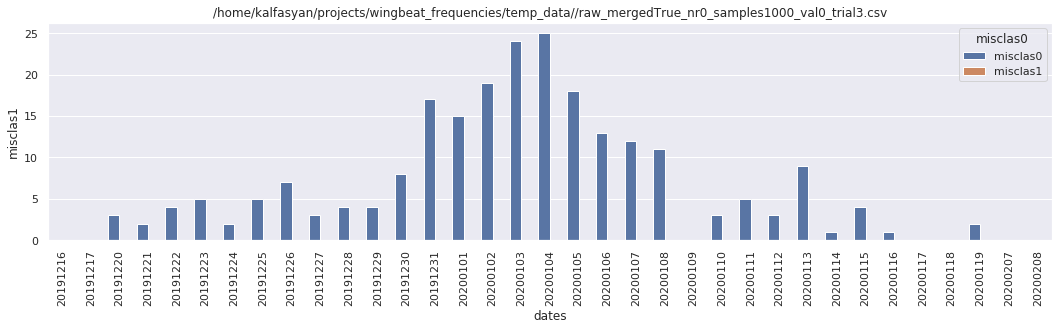

<Figure size 432x288 with 0 Axes>

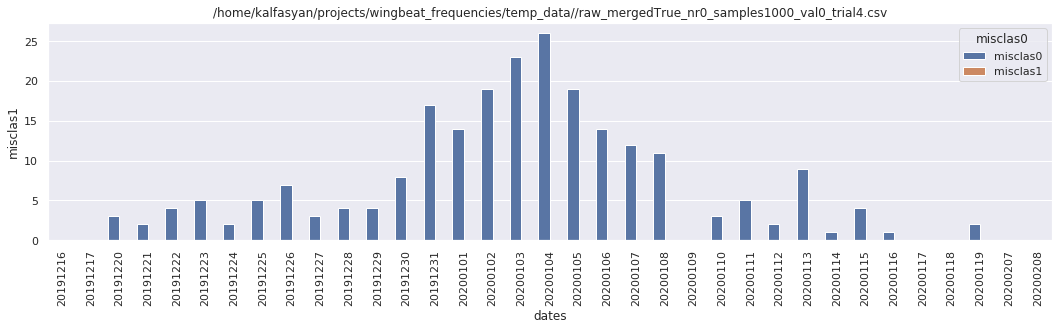

<Figure size 432x288 with 0 Axes>

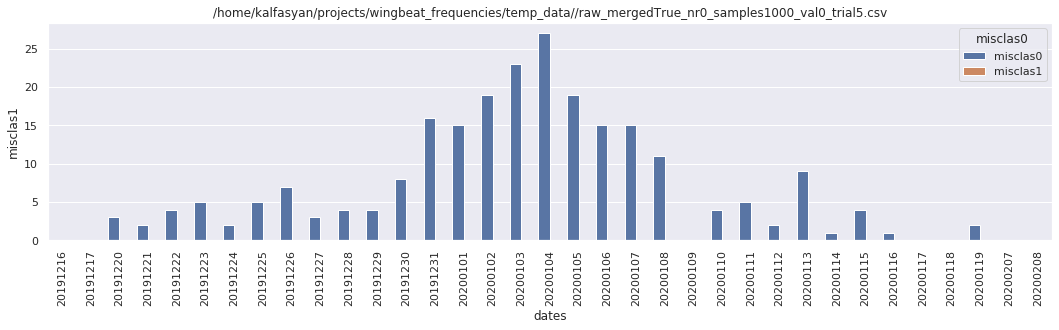

<Figure size 432x288 with 0 Axes>

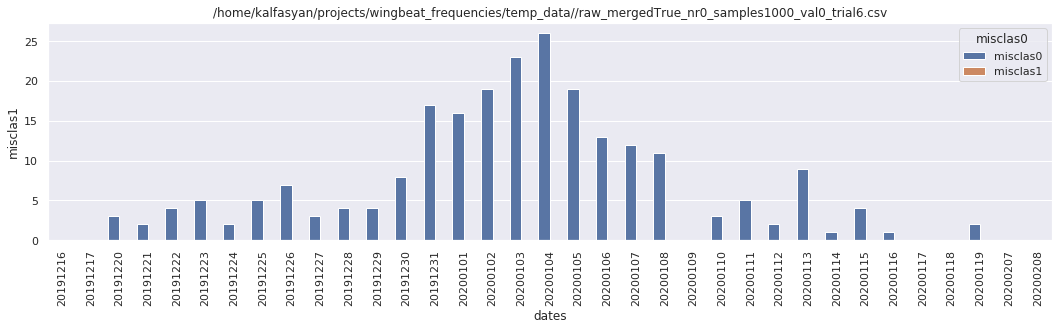

<Figure size 432x288 with 0 Axes>

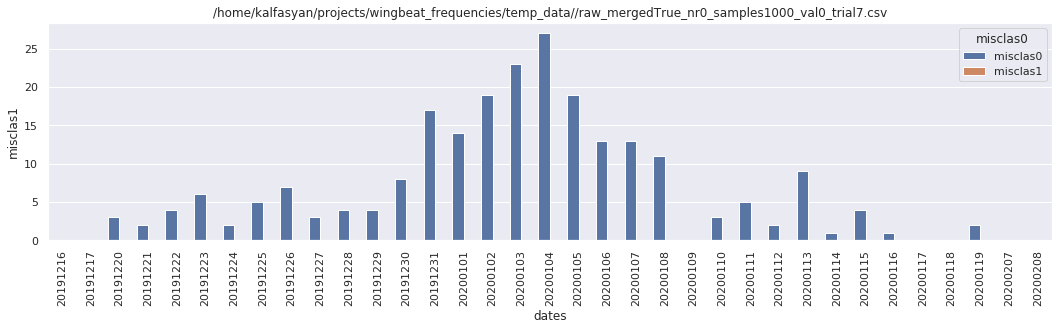

<Figure size 432x288 with 0 Axes>

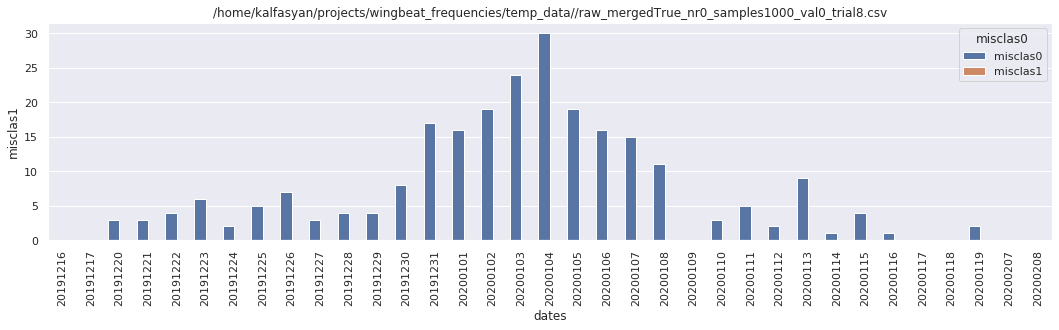

<Figure size 432x288 with 0 Axes>

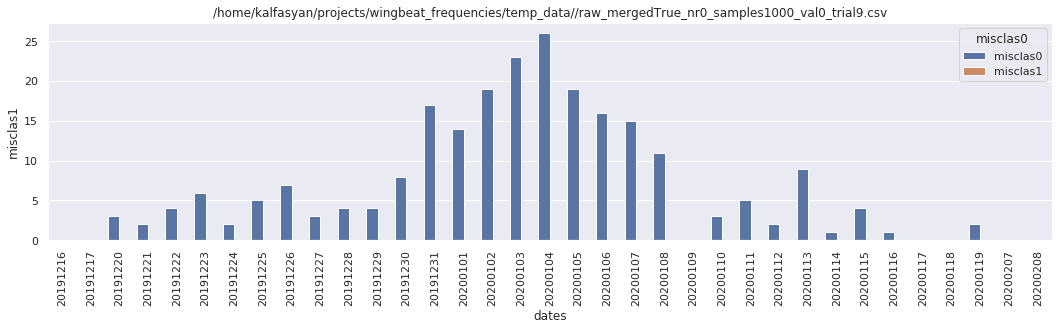

<Figure size 432x288 with 0 Axes>

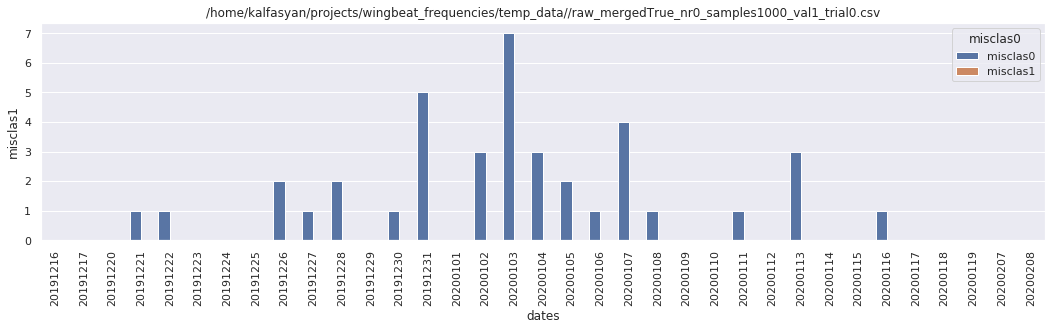

<Figure size 432x288 with 0 Axes>

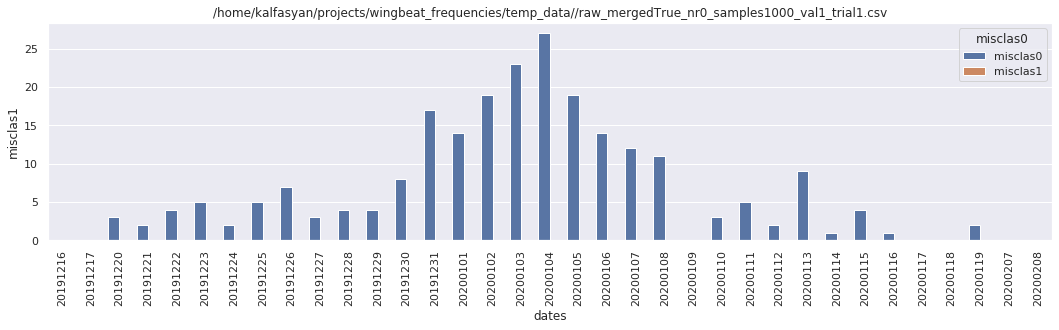

<Figure size 432x288 with 0 Axes>

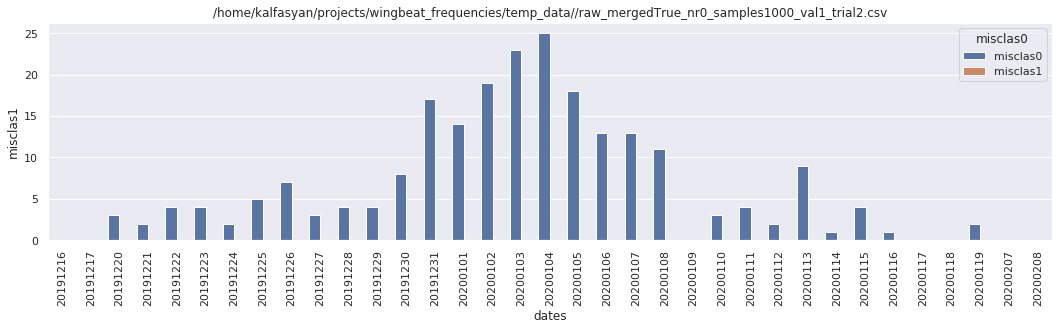

<Figure size 432x288 with 0 Axes>

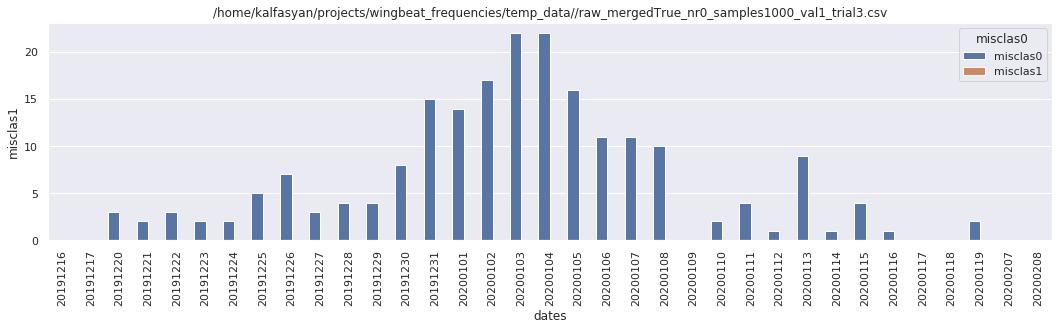

<Figure size 432x288 with 0 Axes>

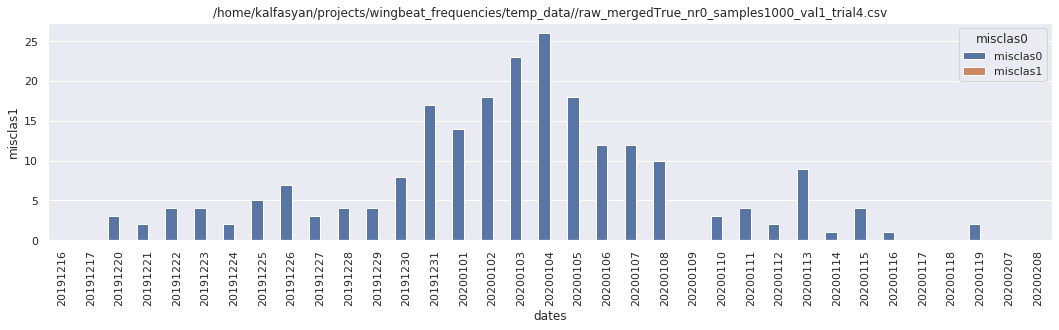

<Figure size 432x288 with 0 Axes>

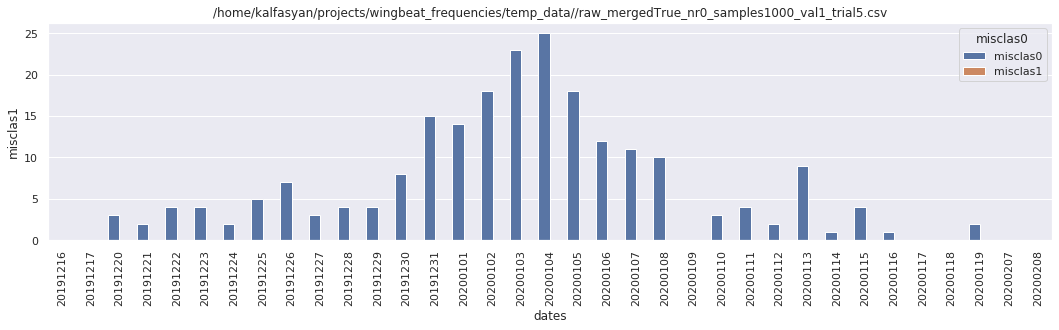

<Figure size 432x288 with 0 Axes>

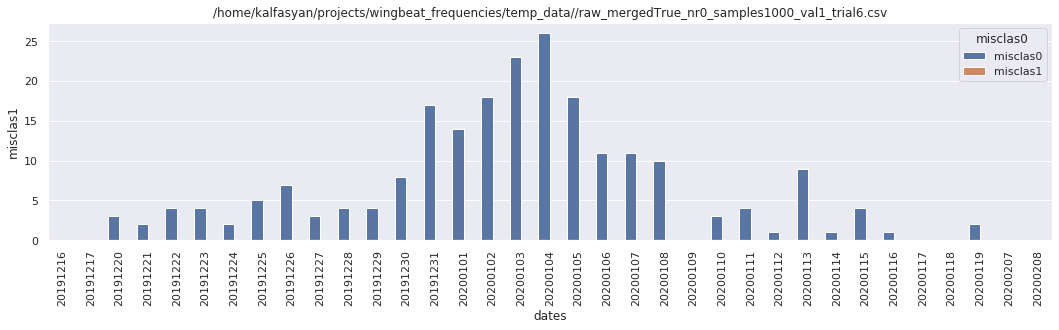

<Figure size 432x288 with 0 Axes>

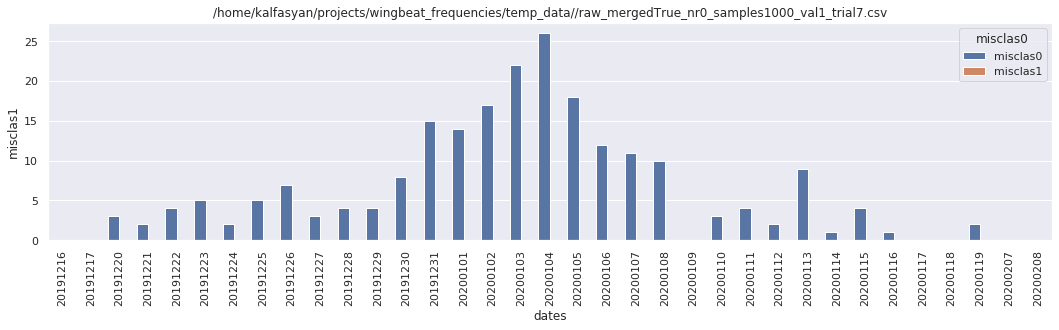

<Figure size 432x288 with 0 Axes>

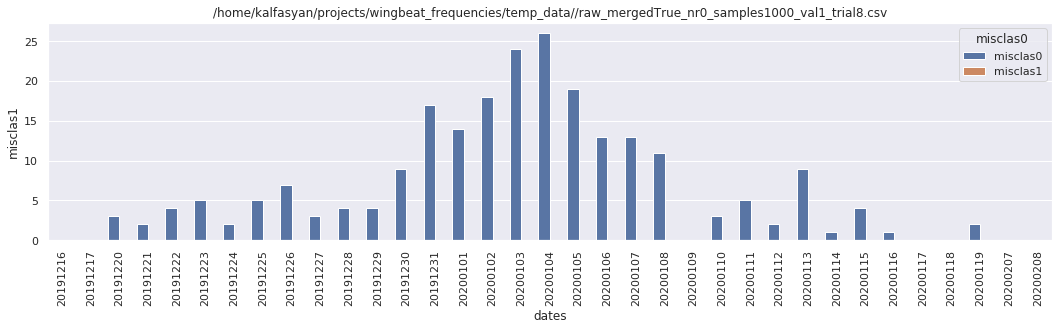

<Figure size 432x288 with 0 Axes>

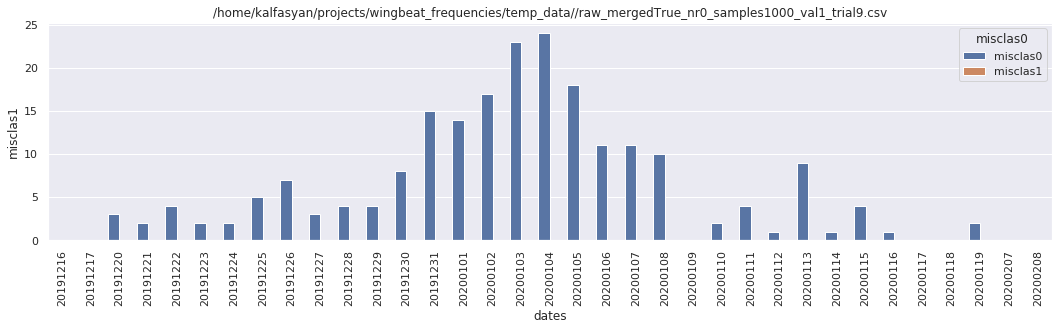

<Figure size 432x288 with 0 Axes>

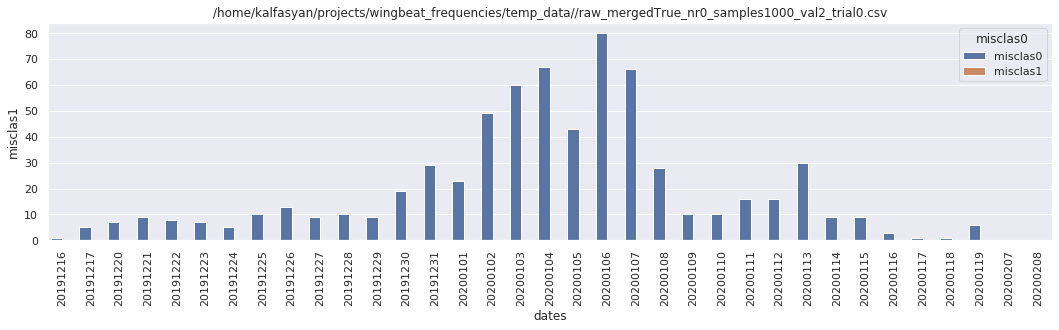

<Figure size 432x288 with 0 Axes>

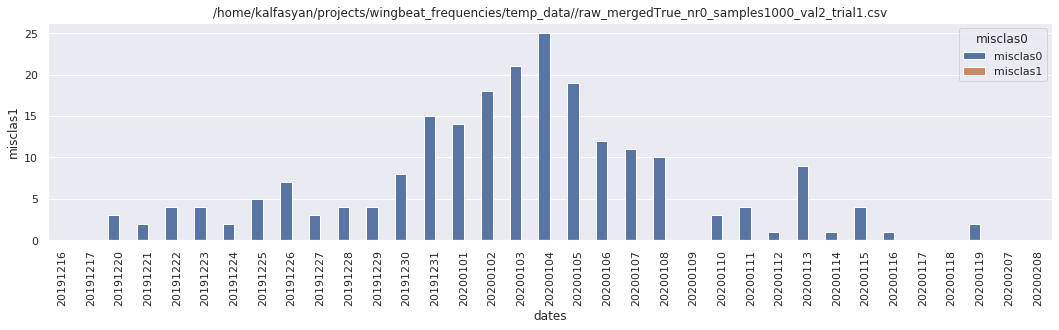

<Figure size 432x288 with 0 Axes>

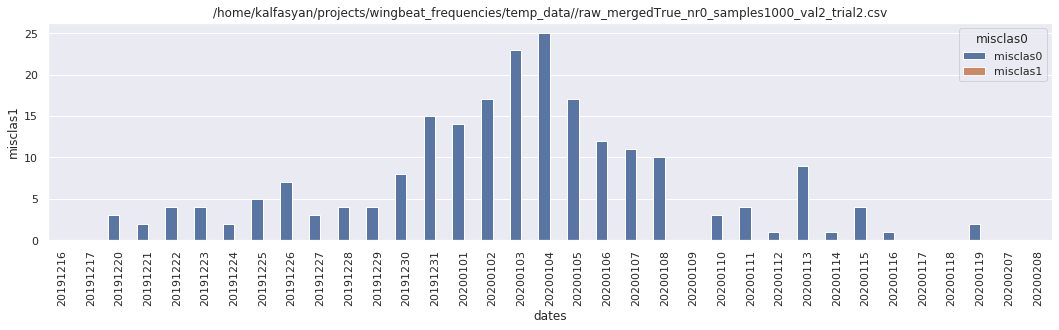

<Figure size 432x288 with 0 Axes>

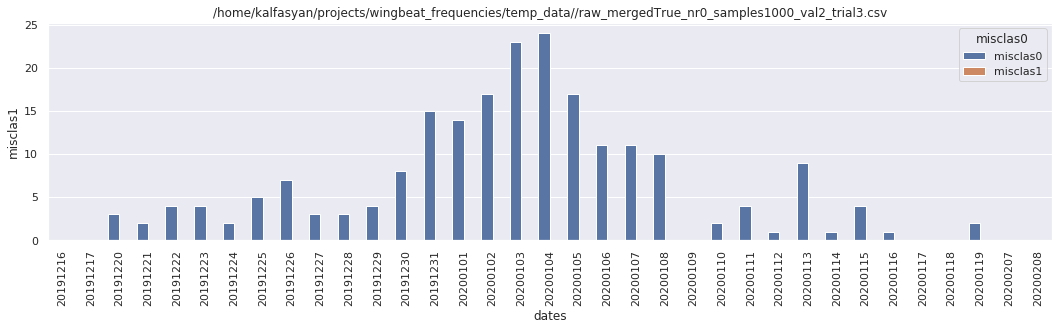

<Figure size 432x288 with 0 Axes>

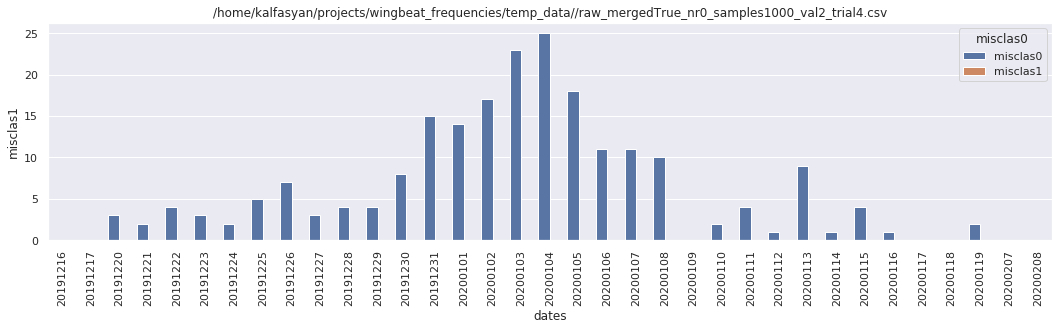

<Figure size 432x288 with 0 Axes>

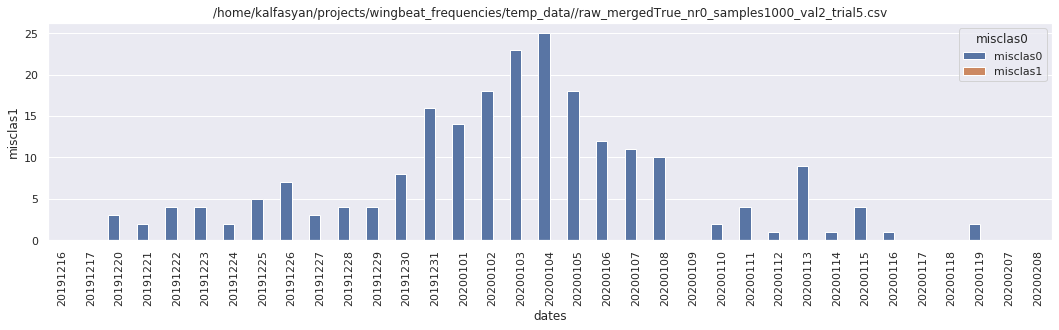

<Figure size 432x288 with 0 Axes>

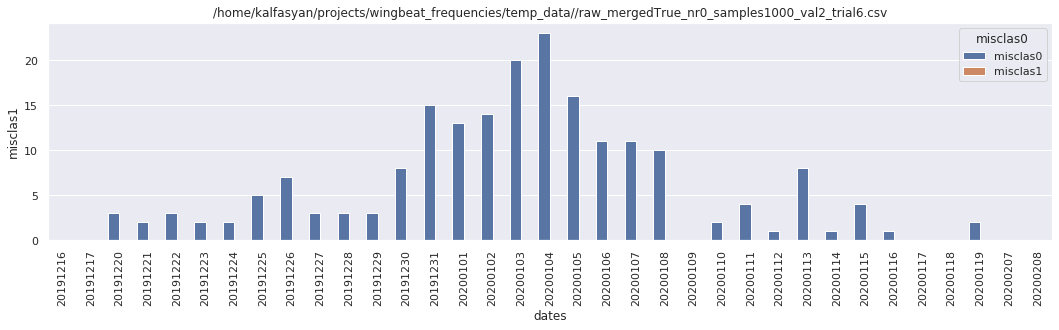

<Figure size 432x288 with 0 Axes>

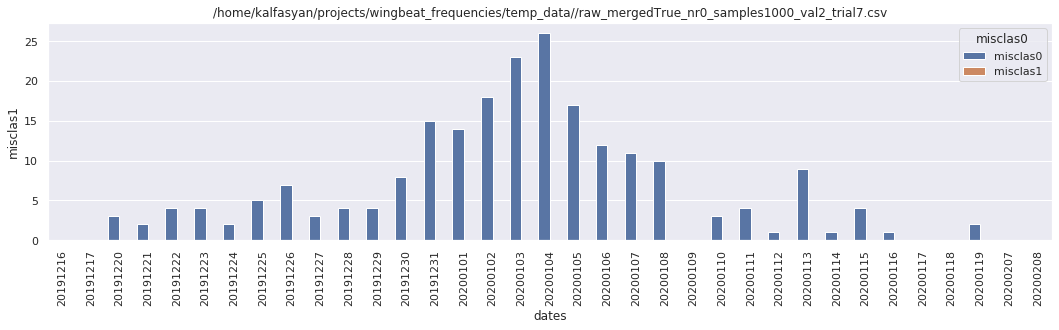

<Figure size 432x288 with 0 Axes>

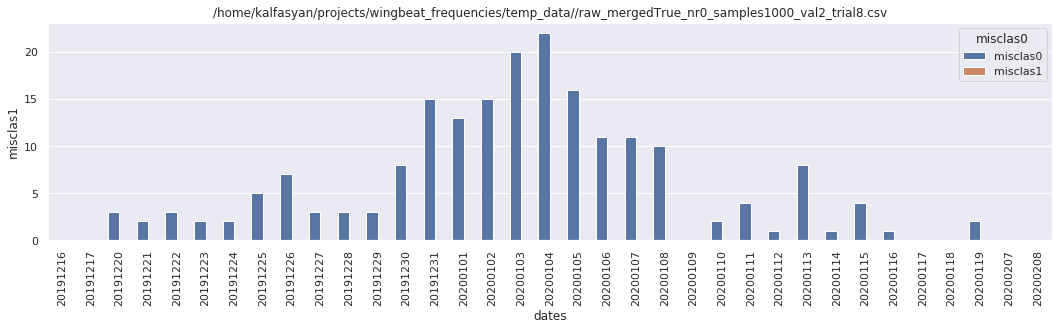

<Figure size 432x288 with 0 Axes>

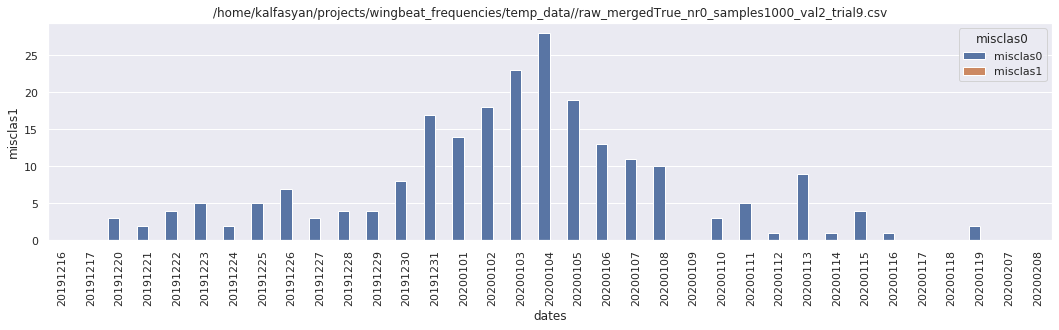

<Figure size 432x288 with 0 Axes>

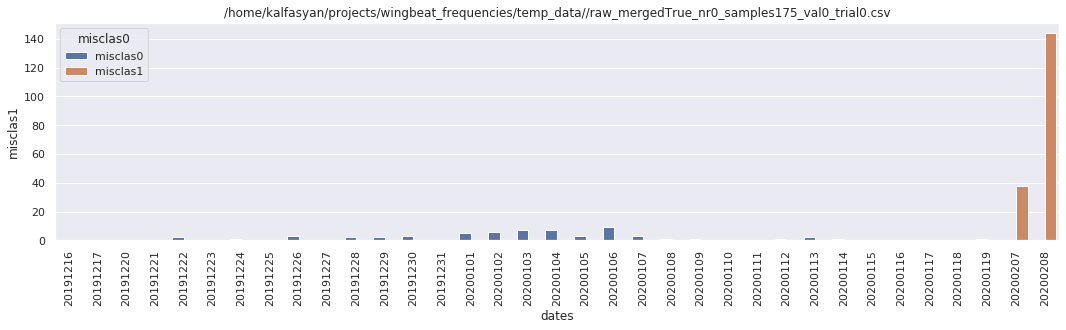

<Figure size 432x288 with 0 Axes>

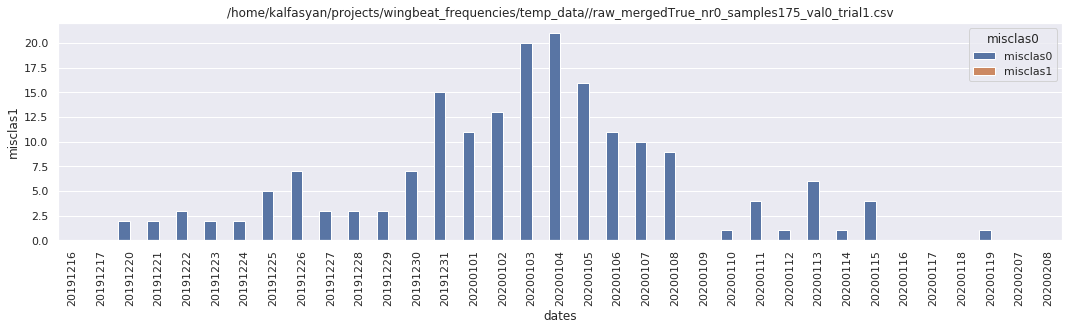

<Figure size 432x288 with 0 Axes>

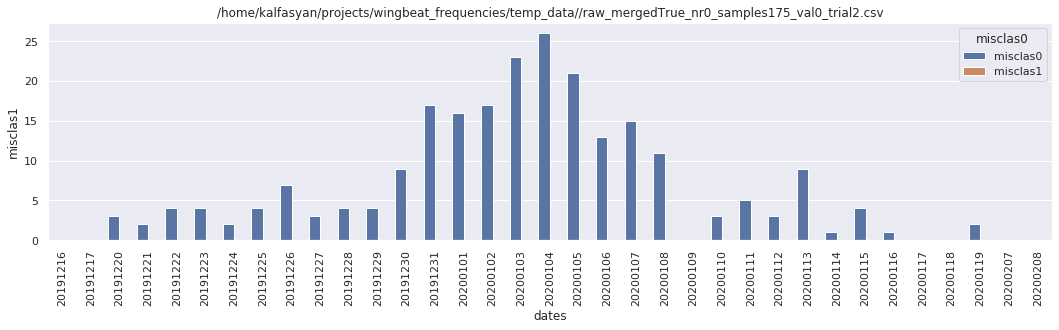

<Figure size 432x288 with 0 Axes>

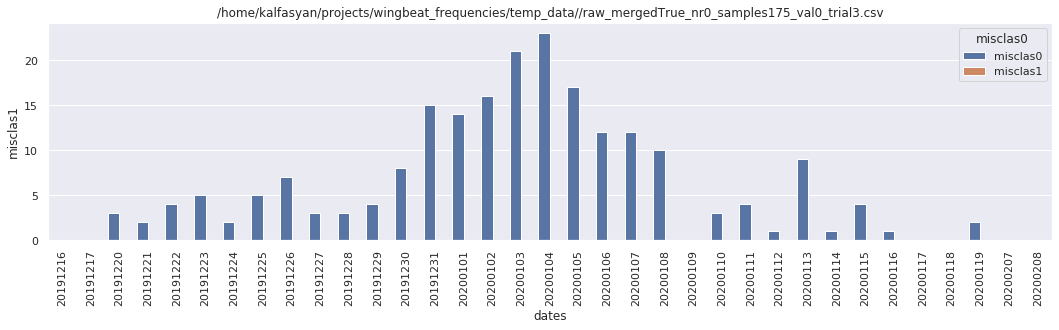

<Figure size 432x288 with 0 Axes>

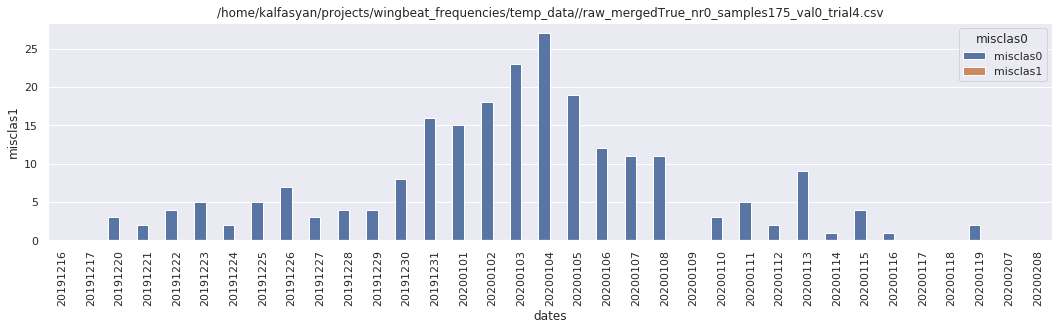

<Figure size 432x288 with 0 Axes>

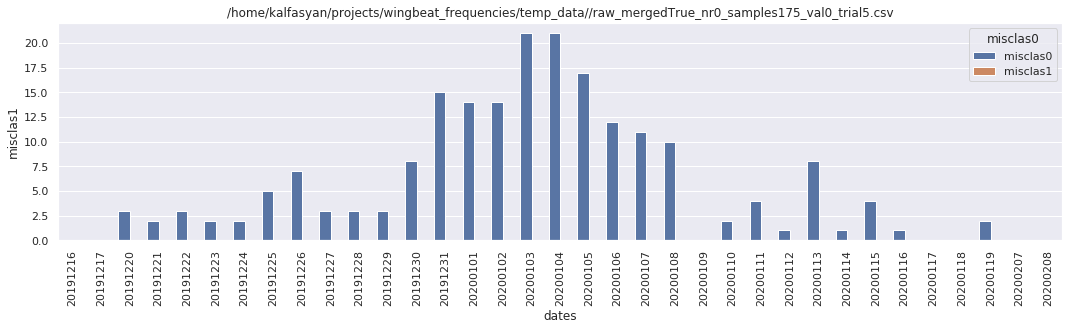

<Figure size 432x288 with 0 Axes>

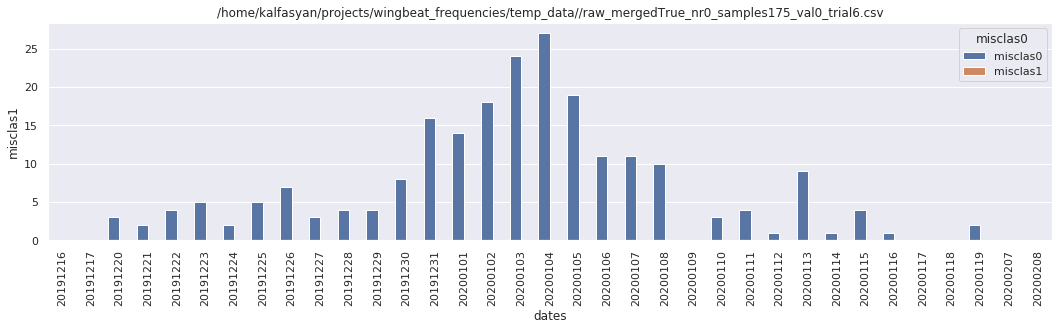

<Figure size 432x288 with 0 Axes>

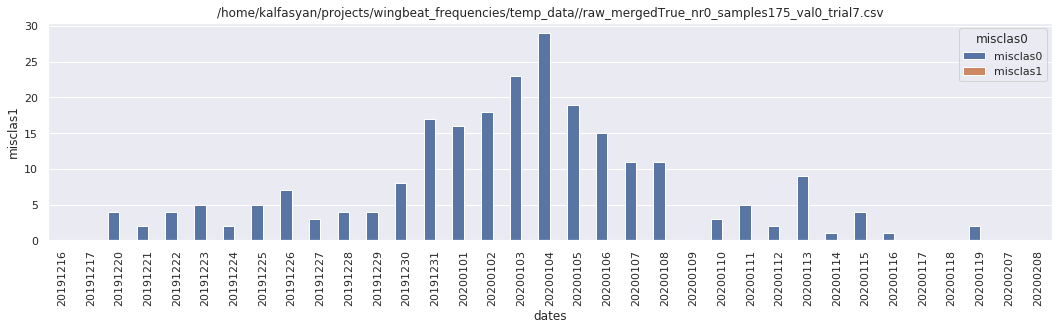

<Figure size 432x288 with 0 Axes>

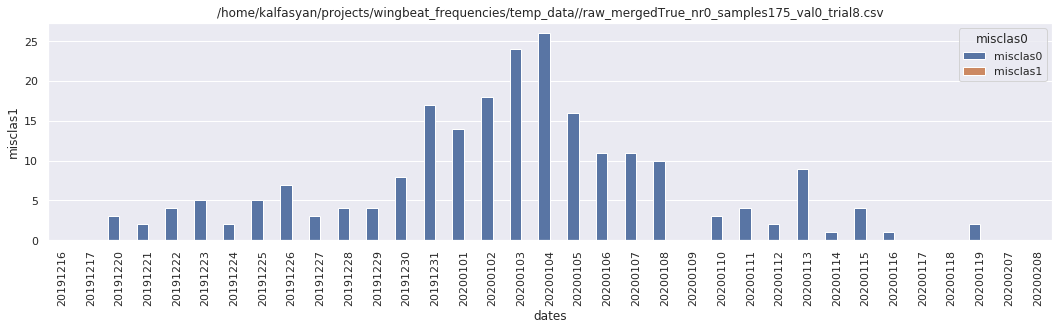

<Figure size 432x288 with 0 Axes>

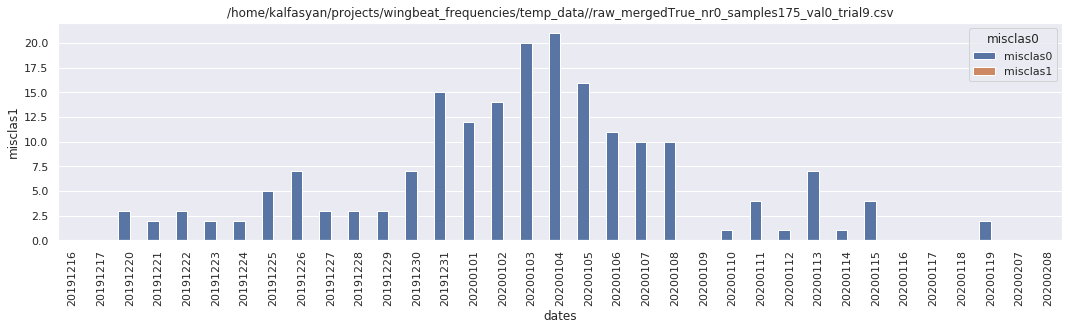

<Figure size 432x288 with 0 Axes>

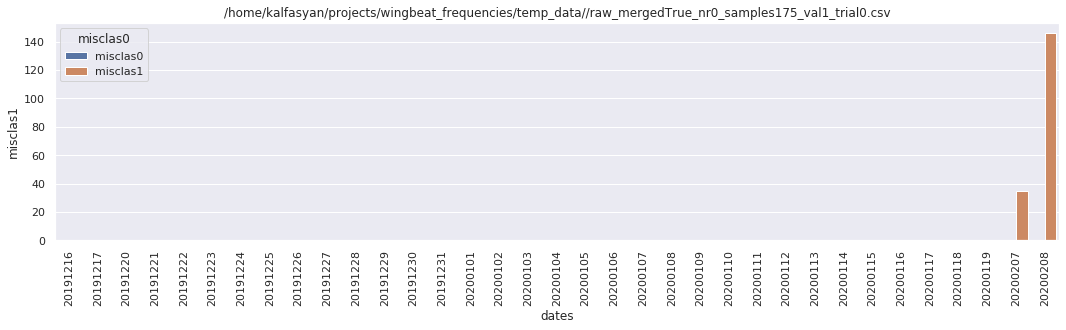

<Figure size 432x288 with 0 Axes>

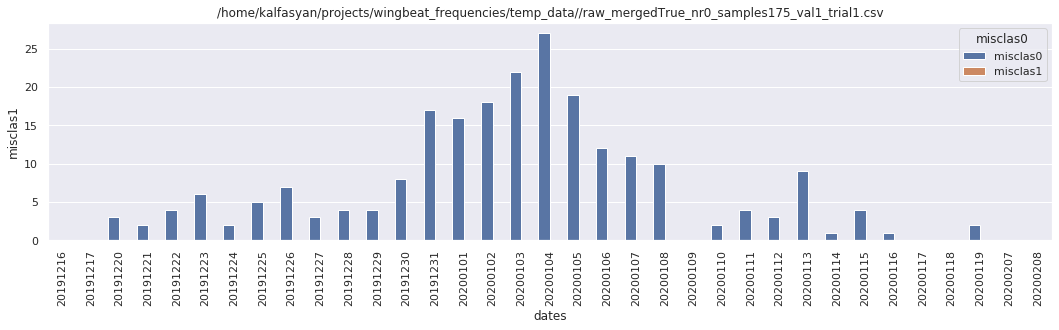

<Figure size 432x288 with 0 Axes>

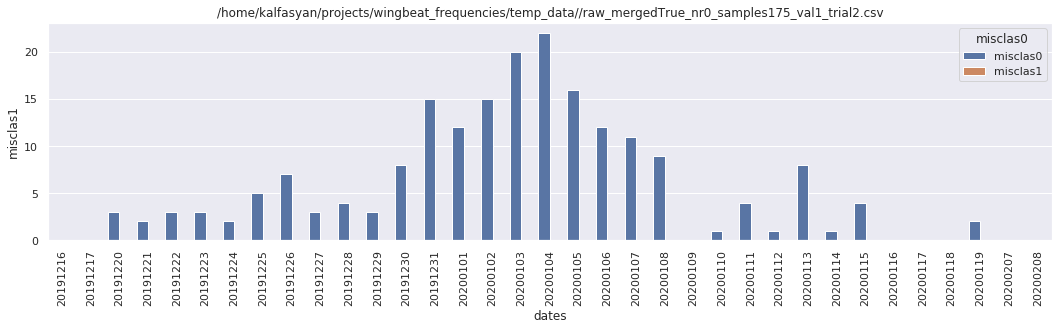

<Figure size 432x288 with 0 Axes>

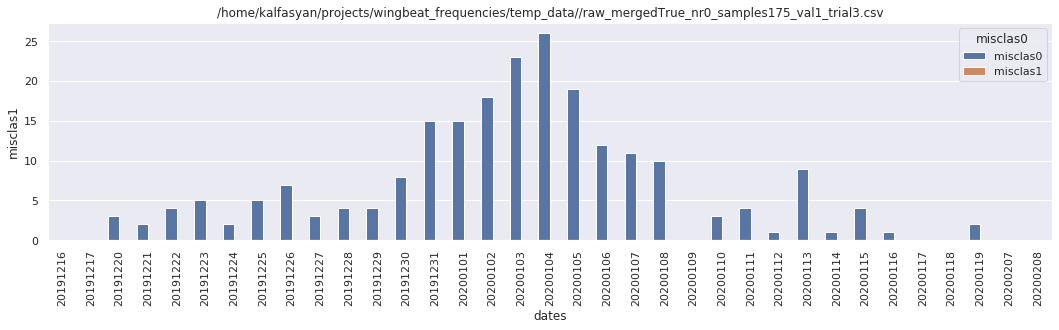

<Figure size 432x288 with 0 Axes>

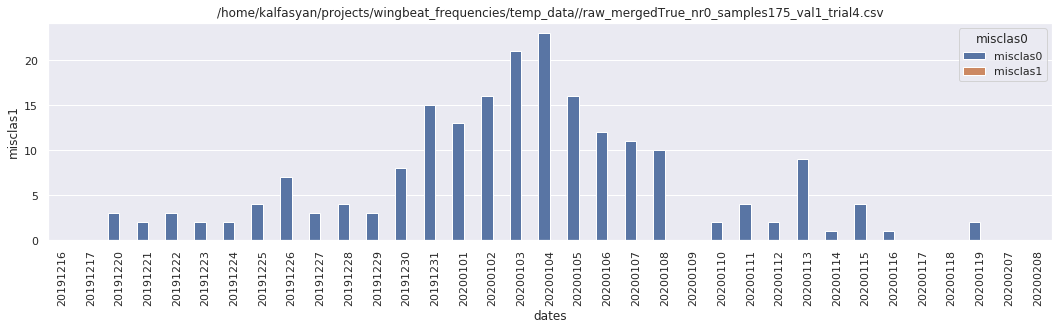

<Figure size 432x288 with 0 Axes>

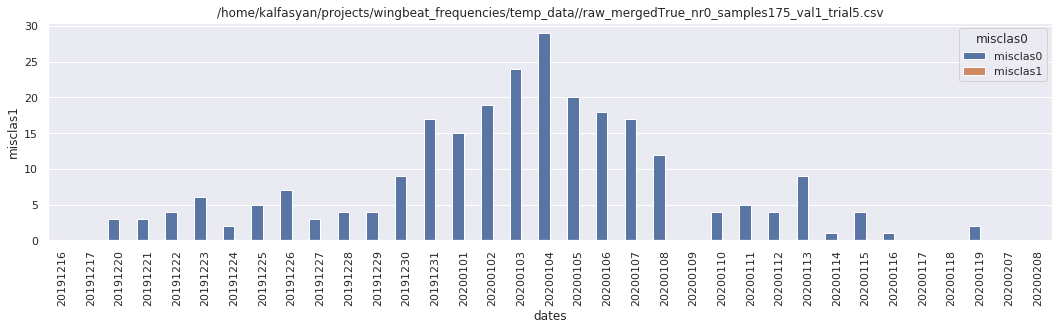

<Figure size 432x288 with 0 Axes>

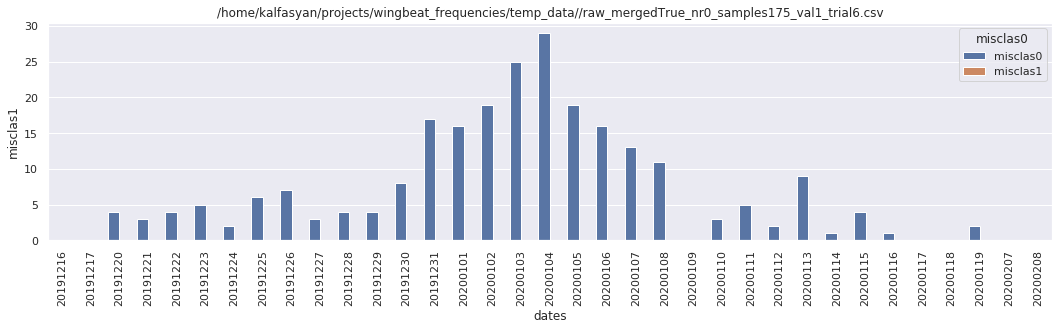

<Figure size 432x288 with 0 Axes>

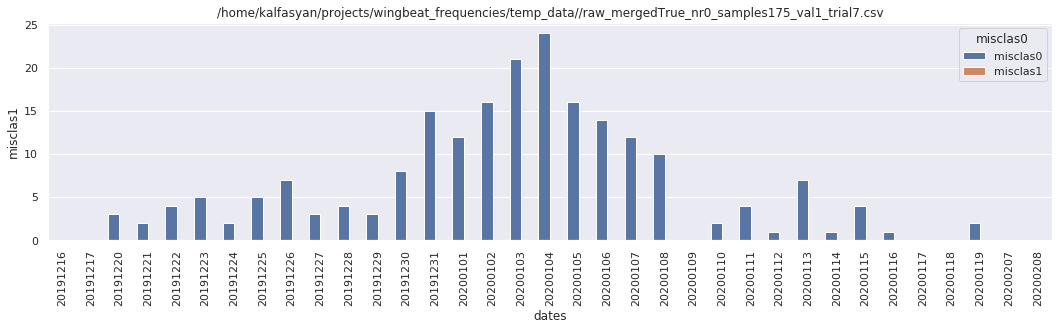

<Figure size 432x288 with 0 Axes>

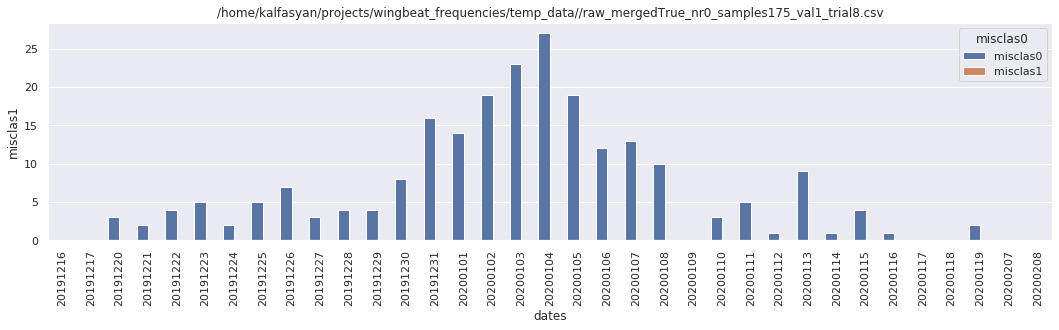

<Figure size 432x288 with 0 Axes>

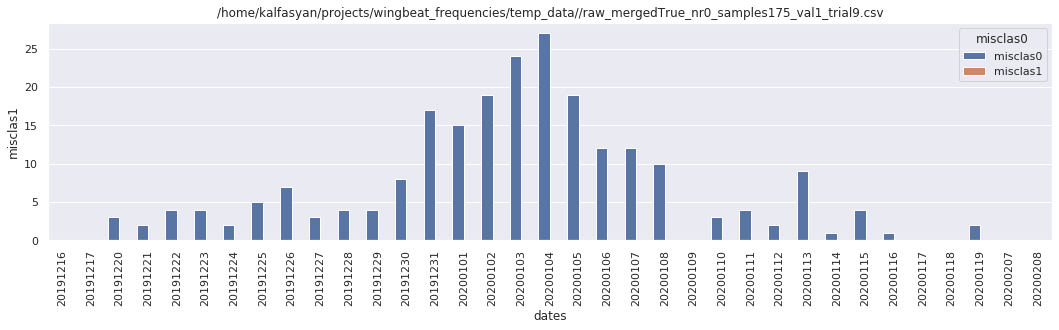

<Figure size 432x288 with 0 Axes>

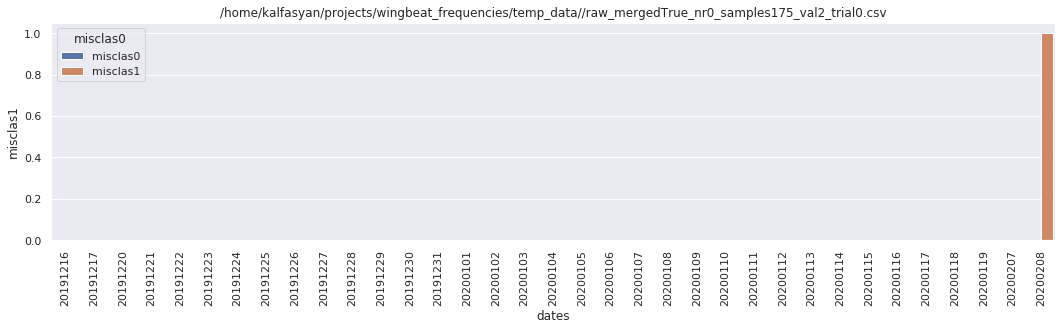

<Figure size 432x288 with 0 Axes>

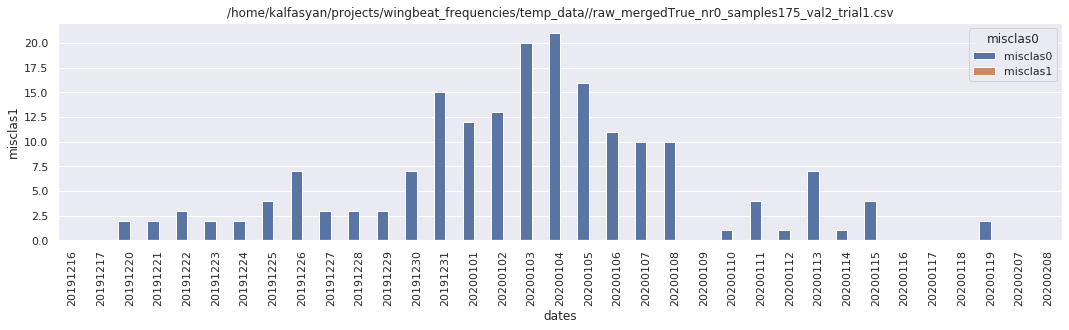

<Figure size 432x288 with 0 Axes>

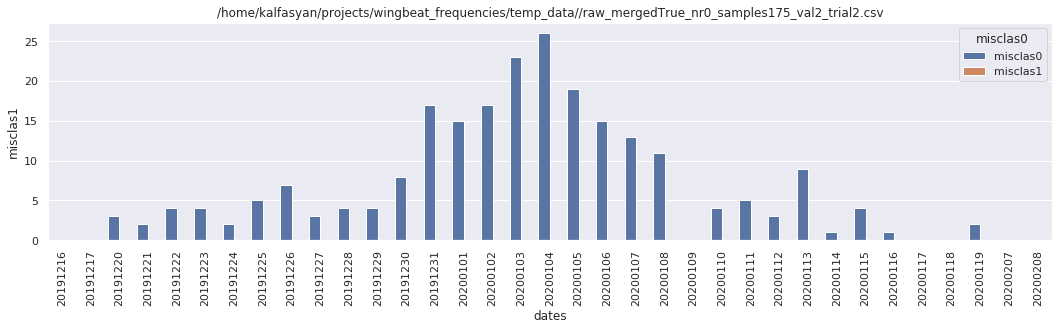

<Figure size 432x288 with 0 Axes>

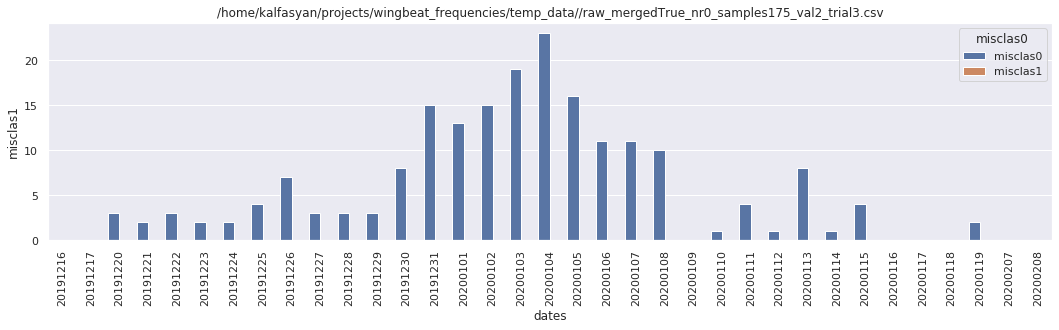

<Figure size 432x288 with 0 Axes>

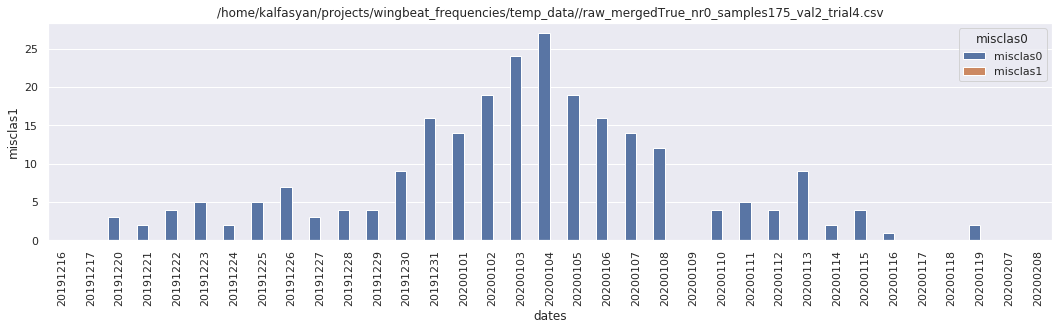

<Figure size 432x288 with 0 Axes>

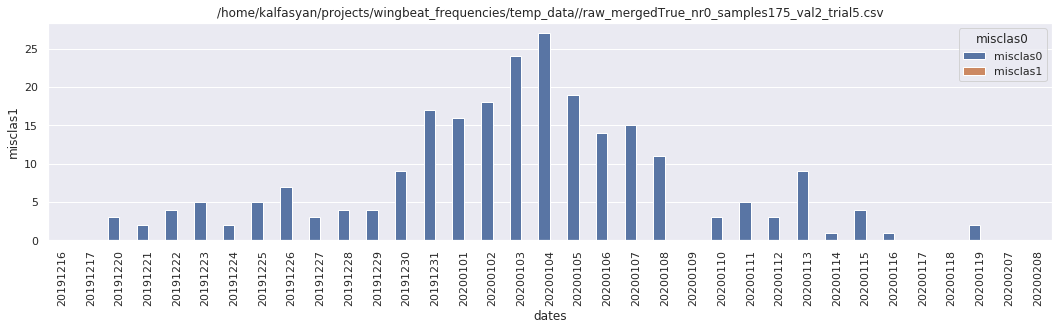

<Figure size 432x288 with 0 Axes>

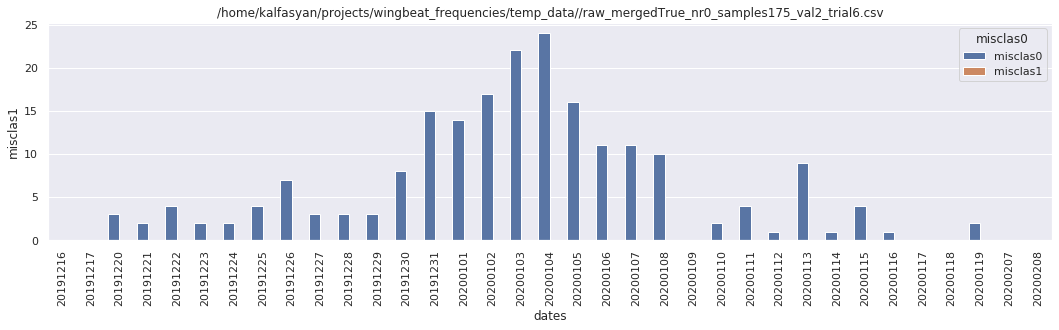

<Figure size 432x288 with 0 Axes>

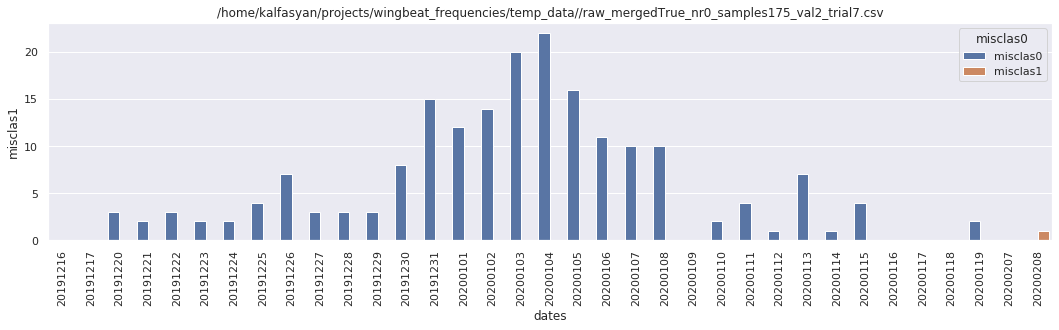

<Figure size 432x288 with 0 Axes>

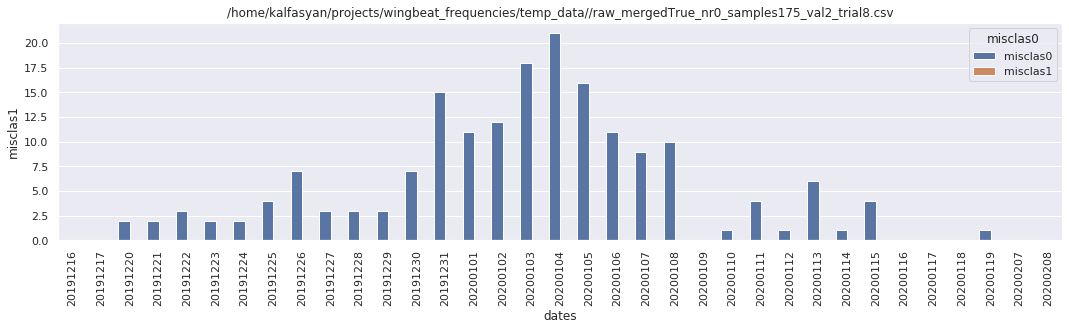

<Figure size 432x288 with 0 Axes>

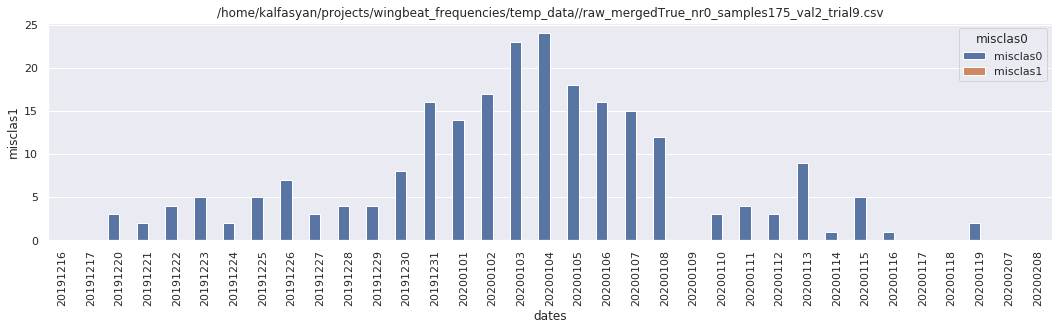

<Figure size 432x288 with 0 Axes>

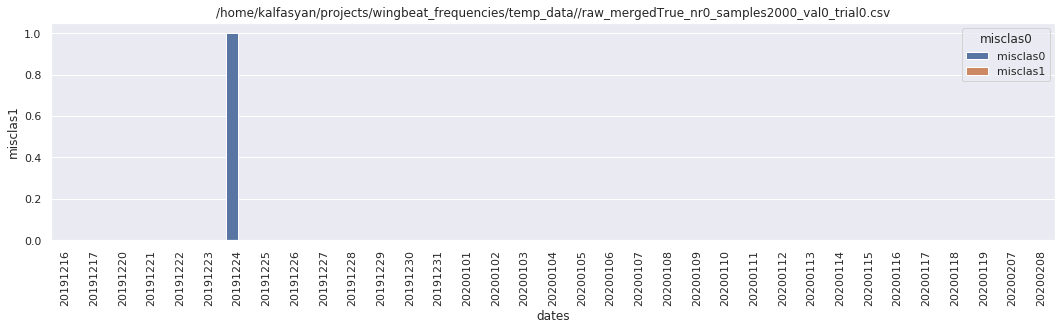

<Figure size 432x288 with 0 Axes>

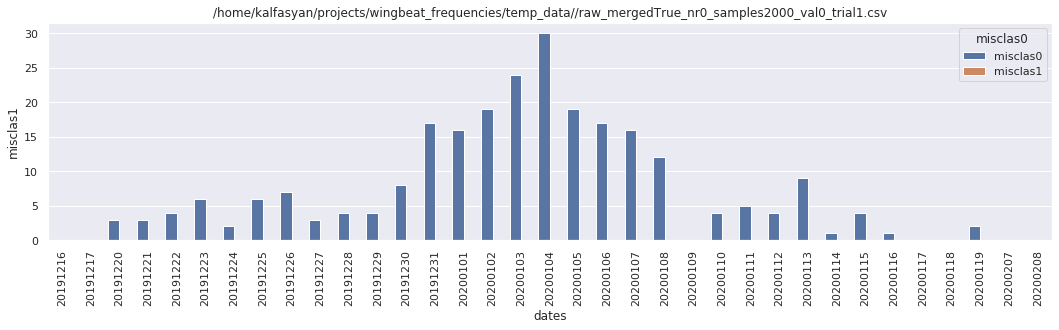

<Figure size 432x288 with 0 Axes>

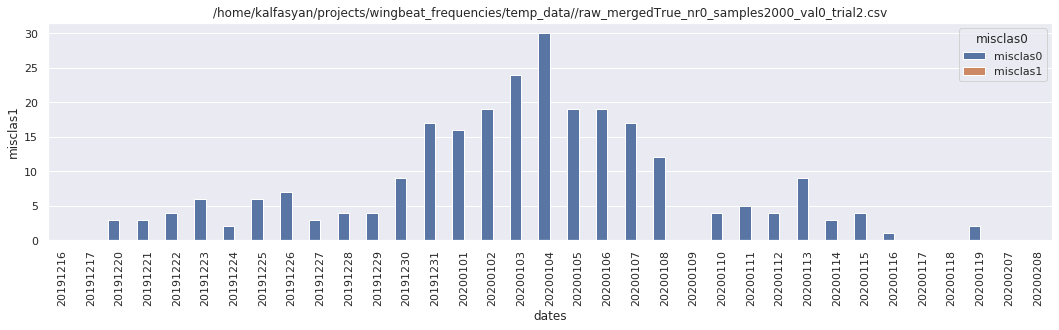

<Figure size 432x288 with 0 Axes>

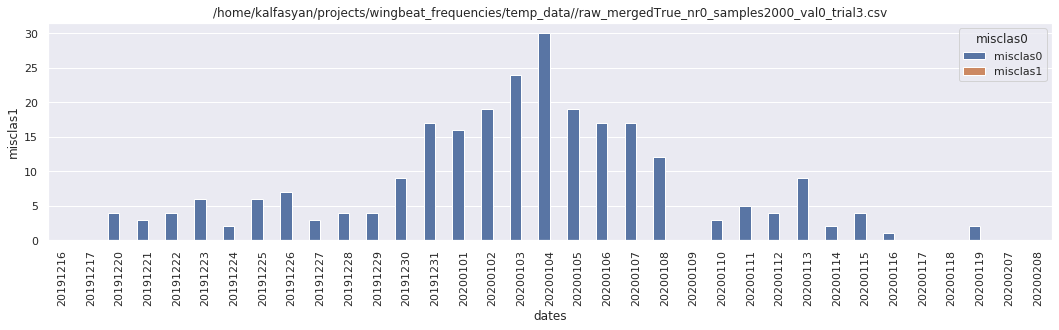

<Figure size 432x288 with 0 Axes>

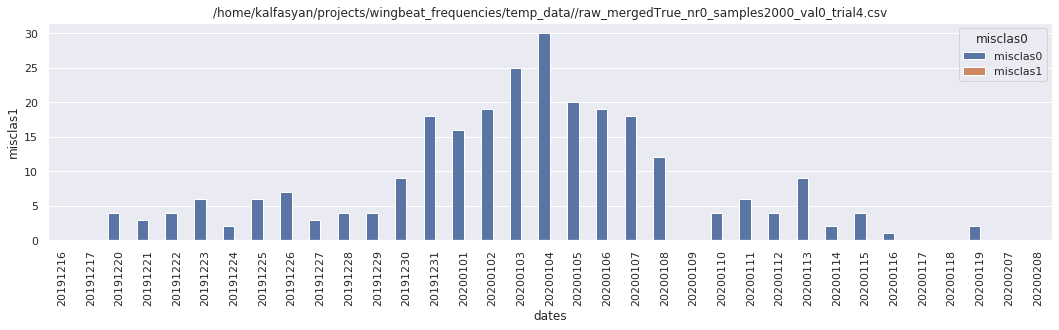

<Figure size 432x288 with 0 Axes>

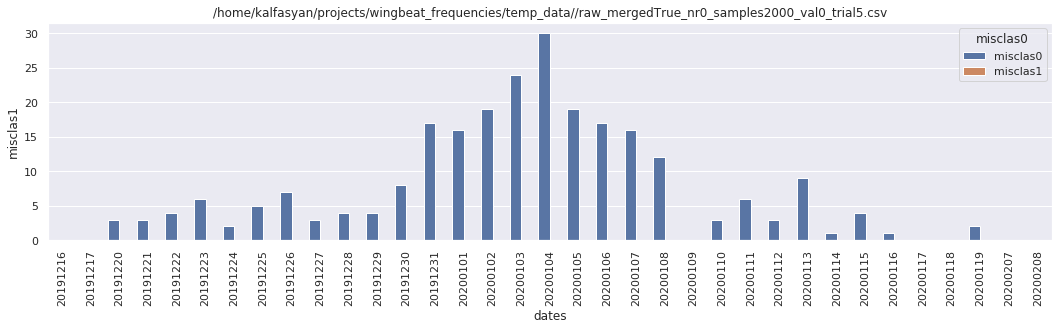

<Figure size 432x288 with 0 Axes>

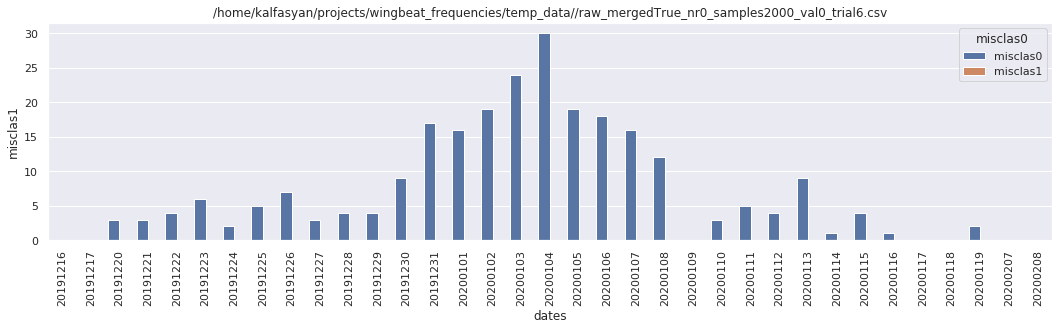

<Figure size 432x288 with 0 Axes>

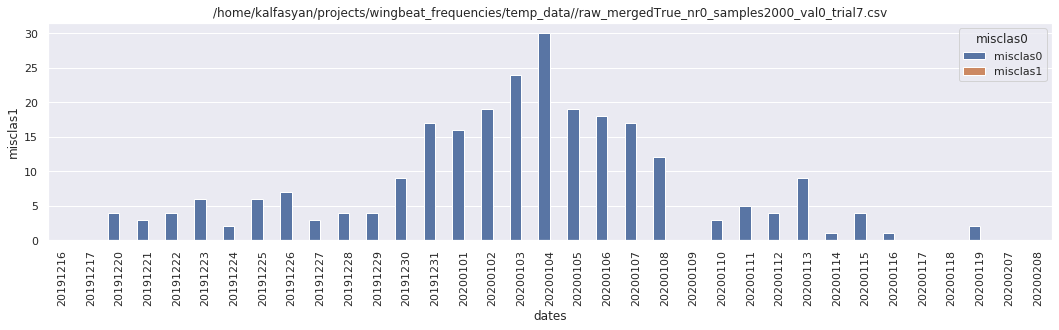

<Figure size 432x288 with 0 Axes>

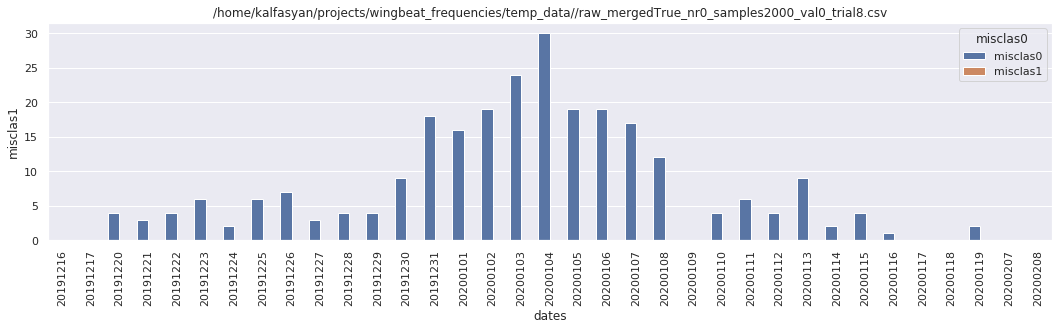

<Figure size 432x288 with 0 Axes>

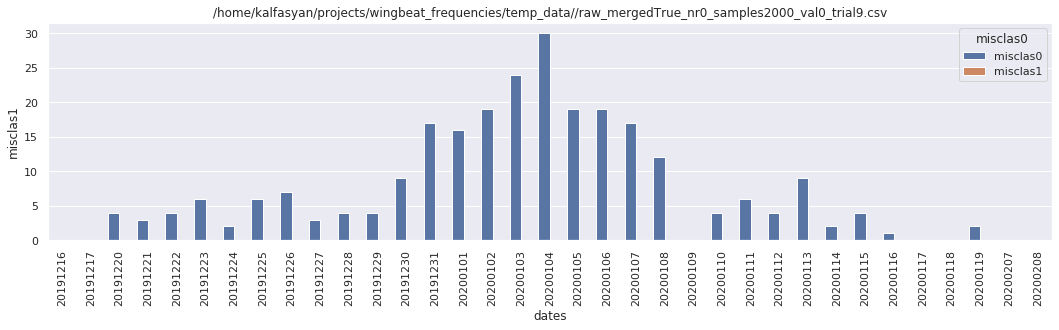

<Figure size 432x288 with 0 Axes>

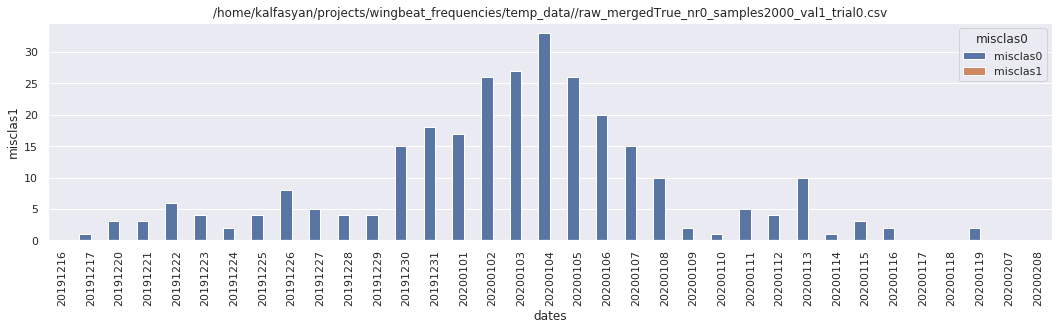

<Figure size 432x288 with 0 Axes>

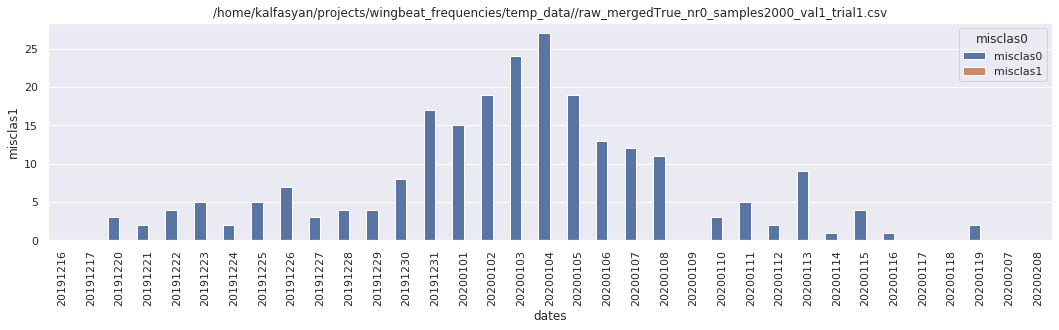

<Figure size 432x288 with 0 Axes>

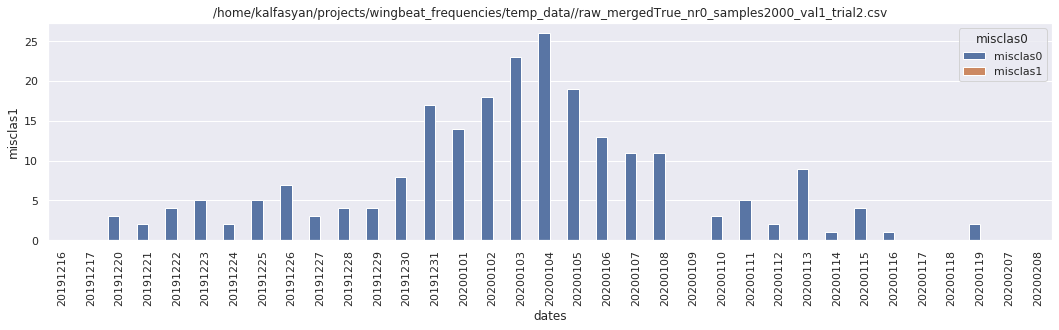

<Figure size 432x288 with 0 Axes>

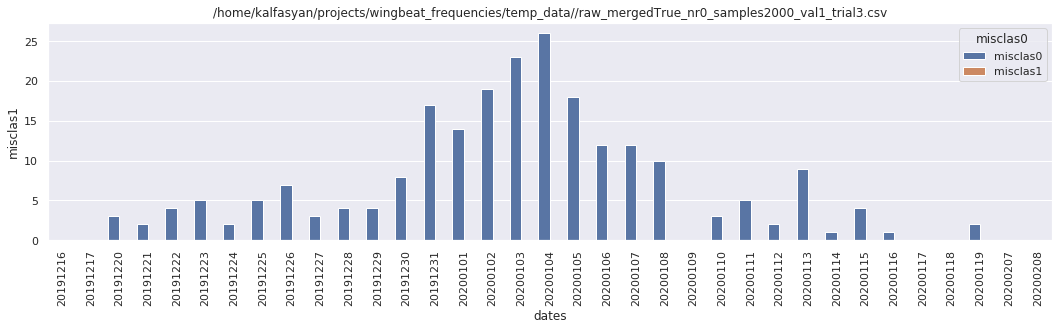

<Figure size 432x288 with 0 Axes>

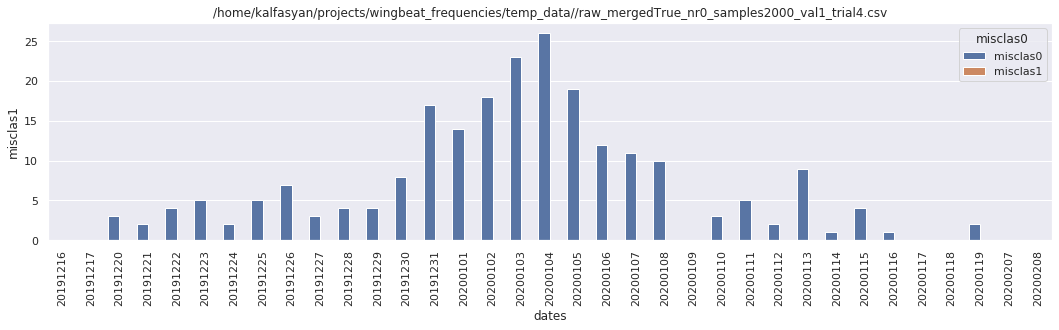

<Figure size 432x288 with 0 Axes>

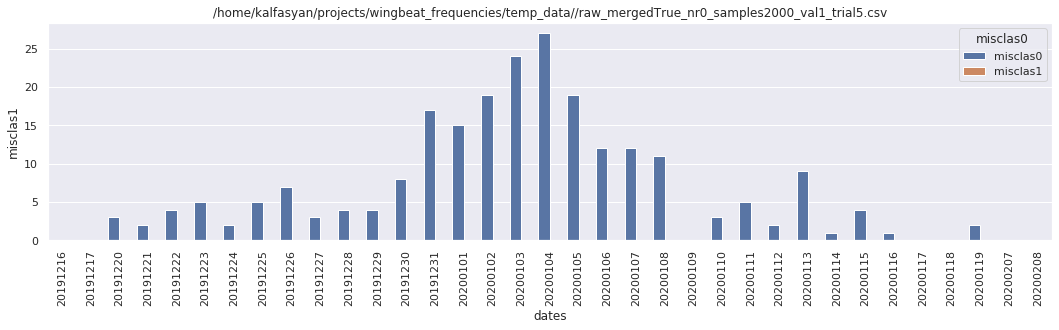

<Figure size 432x288 with 0 Axes>

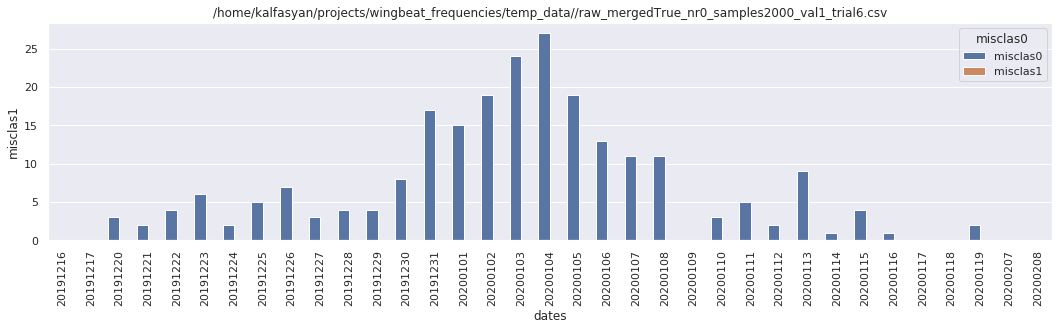

<Figure size 432x288 with 0 Axes>

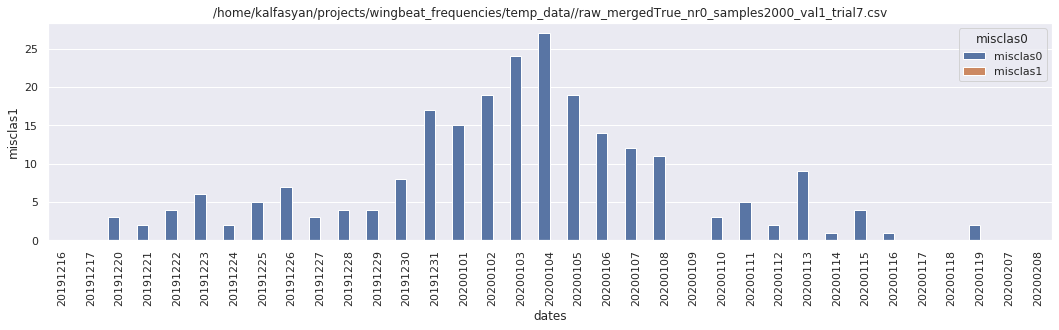

<Figure size 432x288 with 0 Axes>

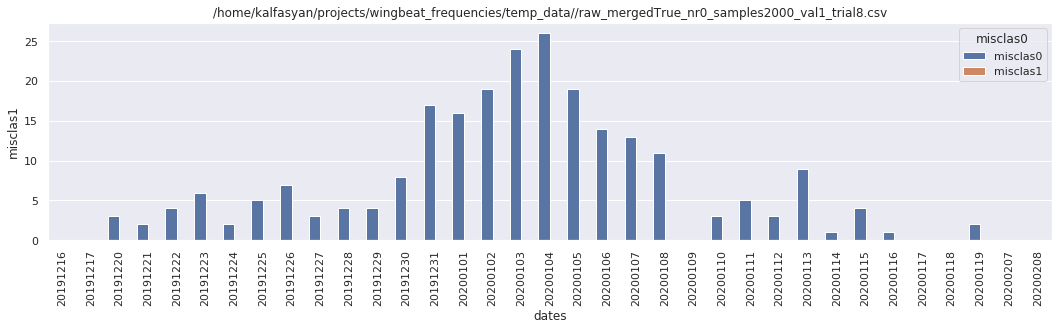

<Figure size 432x288 with 0 Axes>

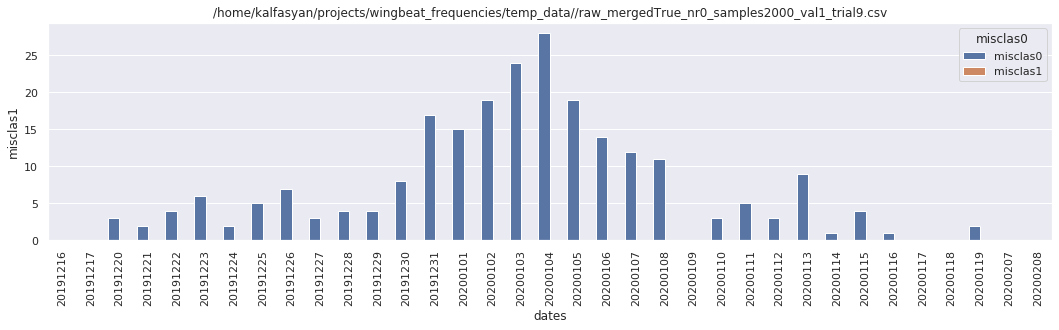

<Figure size 432x288 with 0 Axes>

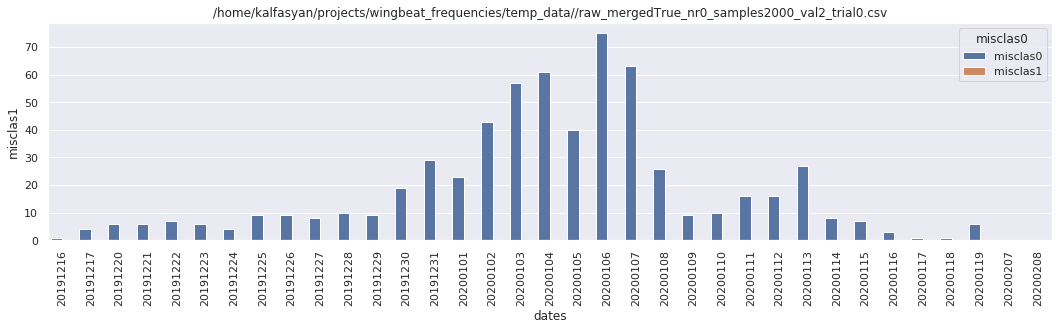

<Figure size 432x288 with 0 Axes>

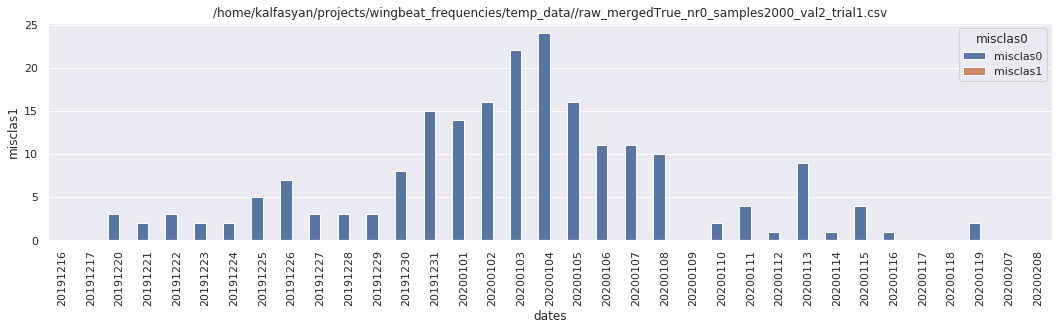

<Figure size 432x288 with 0 Axes>

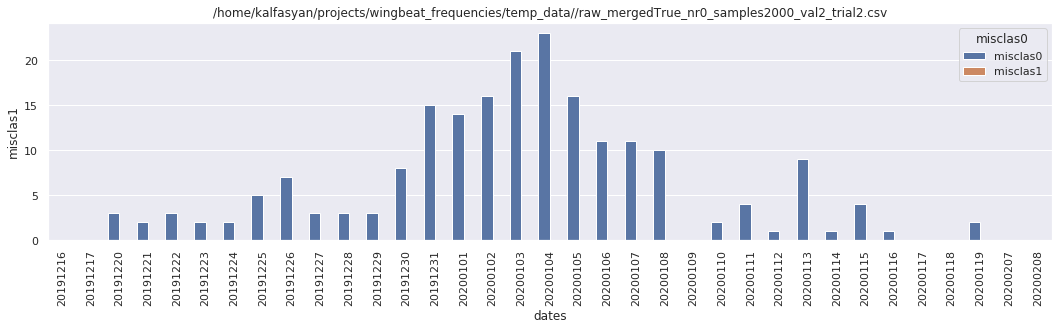

<Figure size 432x288 with 0 Axes>

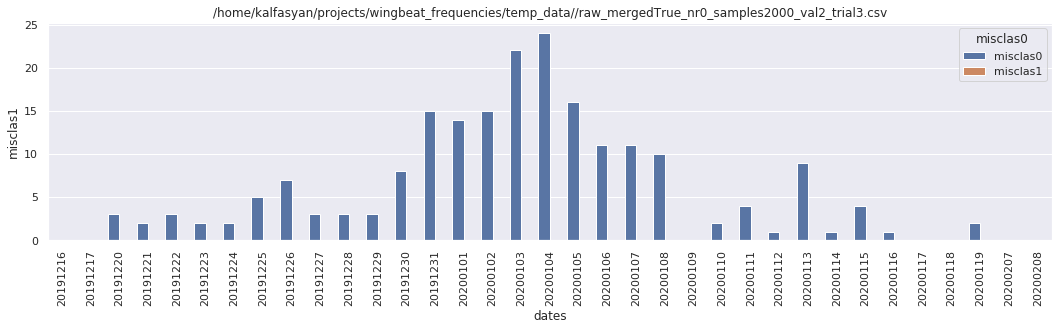

<Figure size 432x288 with 0 Axes>

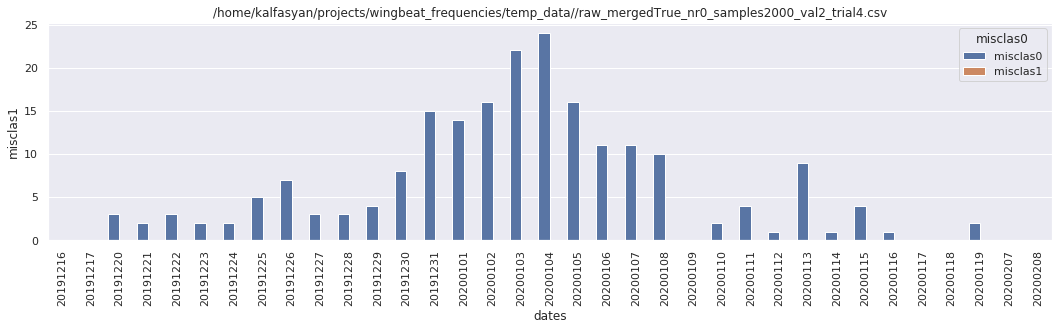

<Figure size 432x288 with 0 Axes>

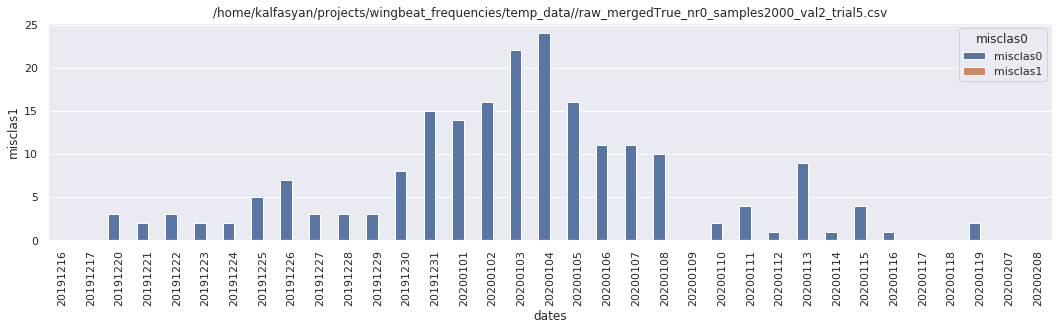

<Figure size 432x288 with 0 Axes>

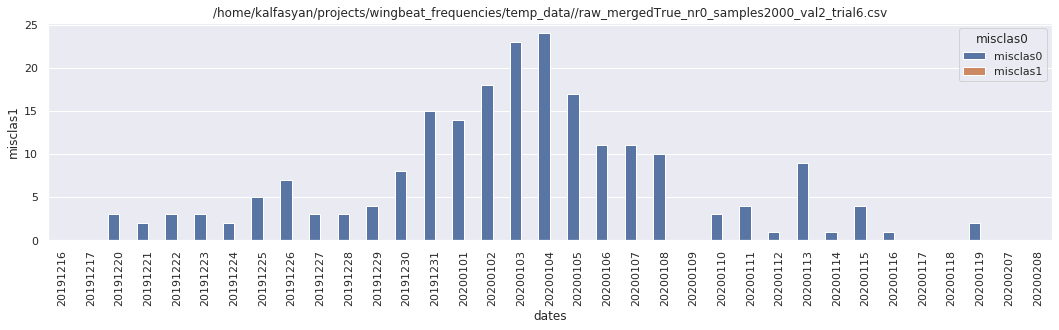

<Figure size 432x288 with 0 Axes>

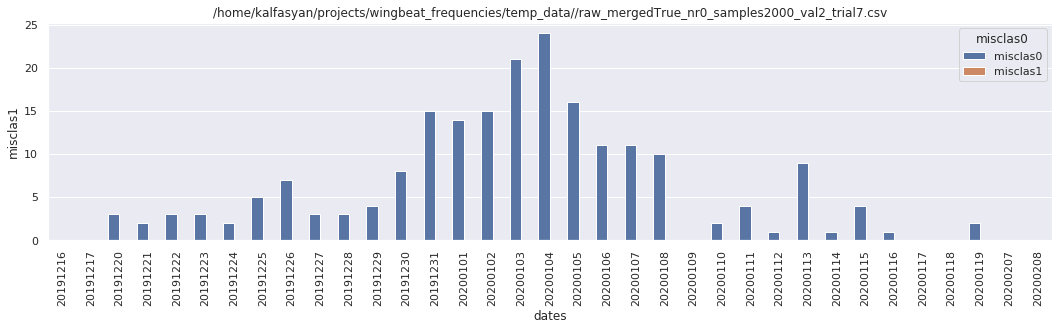

<Figure size 432x288 with 0 Axes>

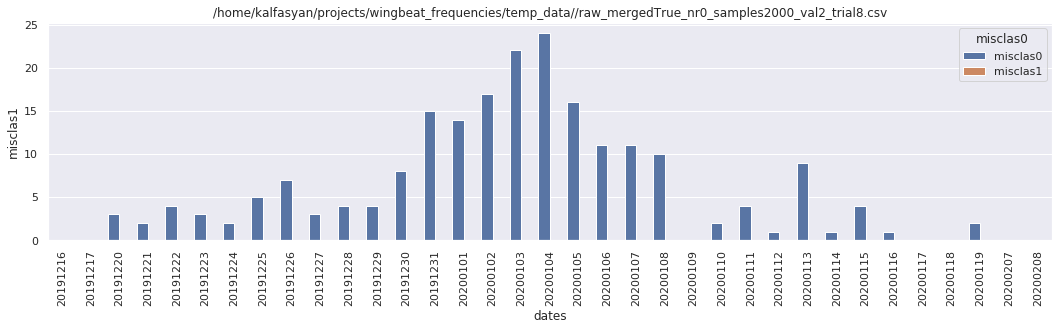

<Figure size 432x288 with 0 Axes>

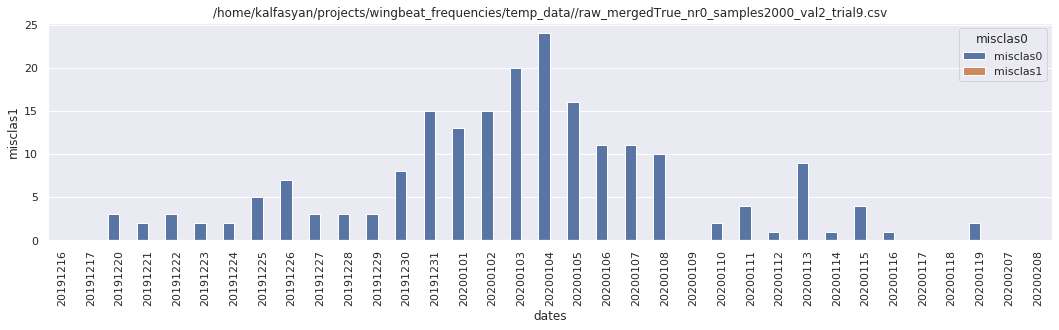

<Figure size 432x288 with 0 Axes>

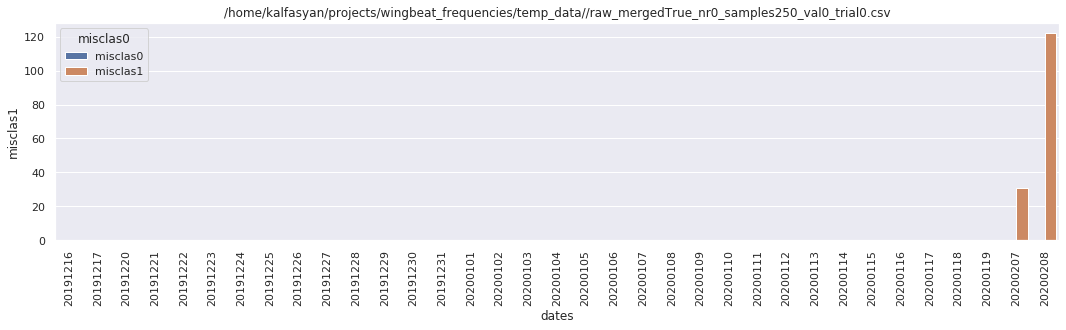

<Figure size 432x288 with 0 Axes>

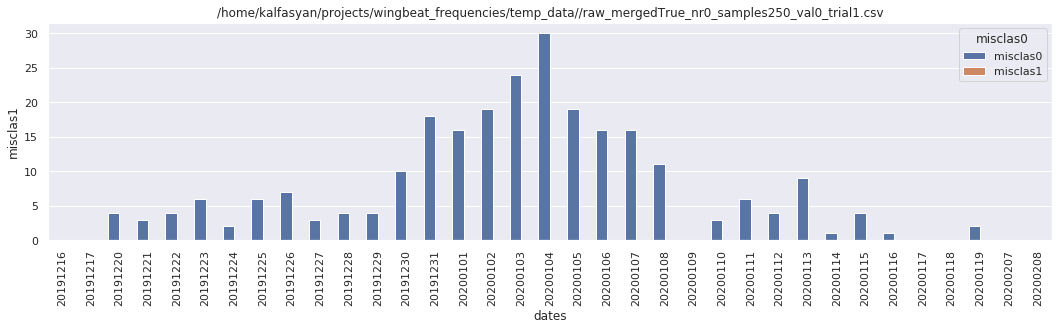

<Figure size 432x288 with 0 Axes>

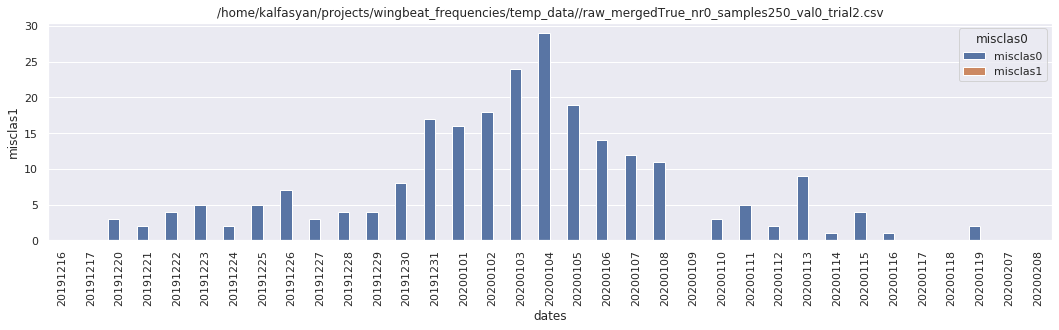

<Figure size 432x288 with 0 Axes>

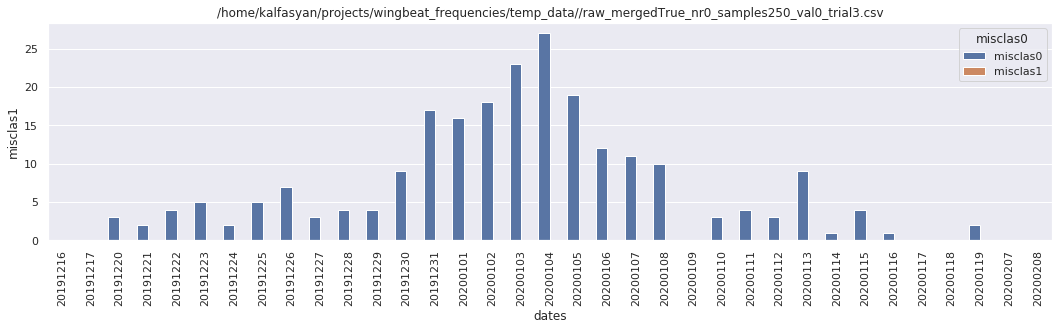

<Figure size 432x288 with 0 Axes>

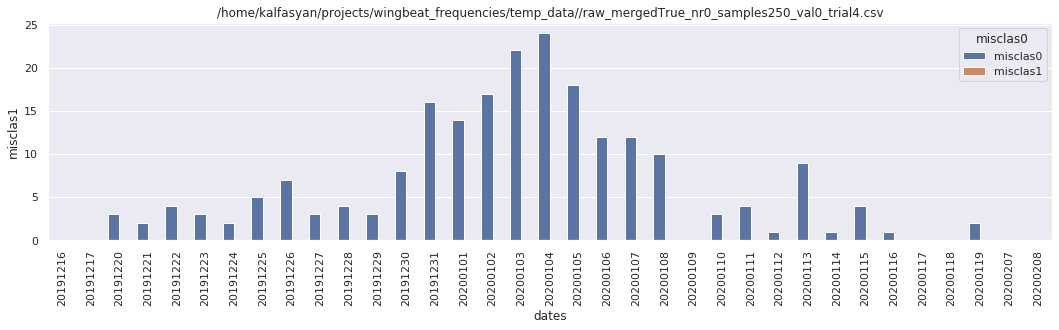

<Figure size 432x288 with 0 Axes>

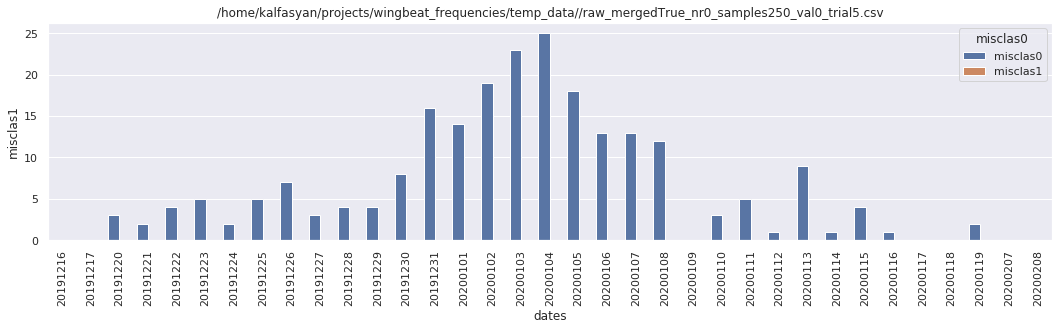

<Figure size 432x288 with 0 Axes>

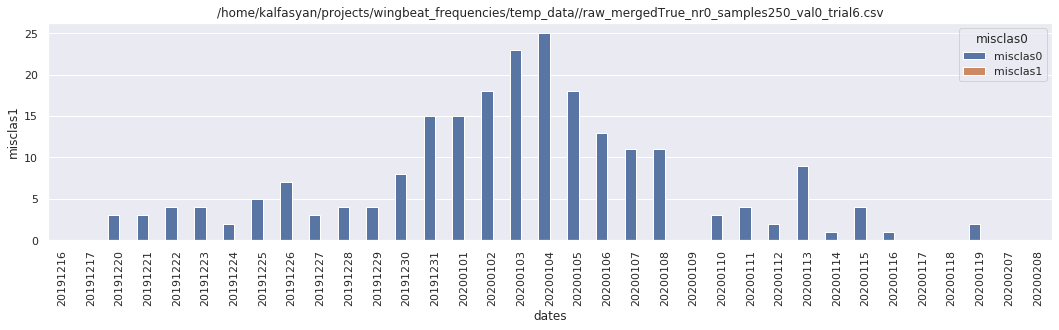

<Figure size 432x288 with 0 Axes>

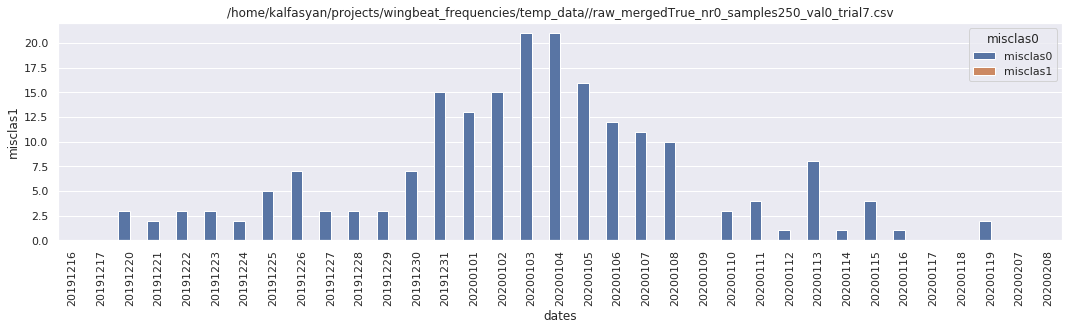

<Figure size 432x288 with 0 Axes>

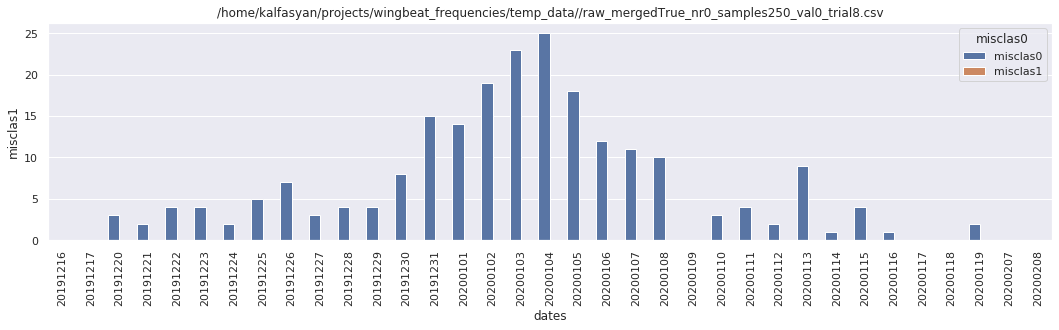

<Figure size 432x288 with 0 Axes>

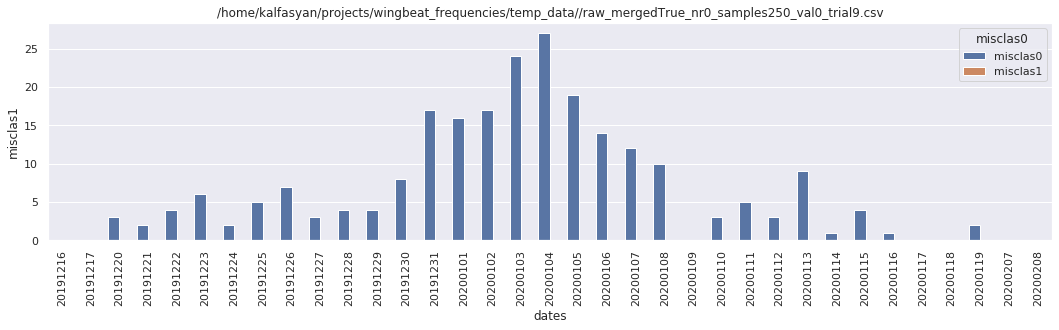

<Figure size 432x288 with 0 Axes>

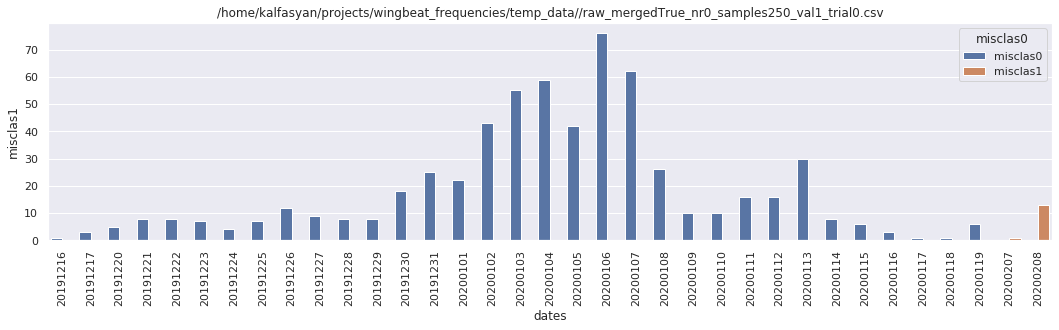

<Figure size 432x288 with 0 Axes>

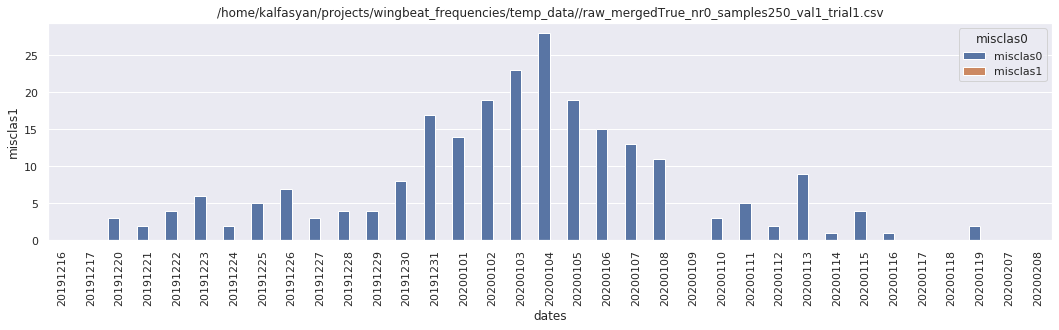

<Figure size 432x288 with 0 Axes>

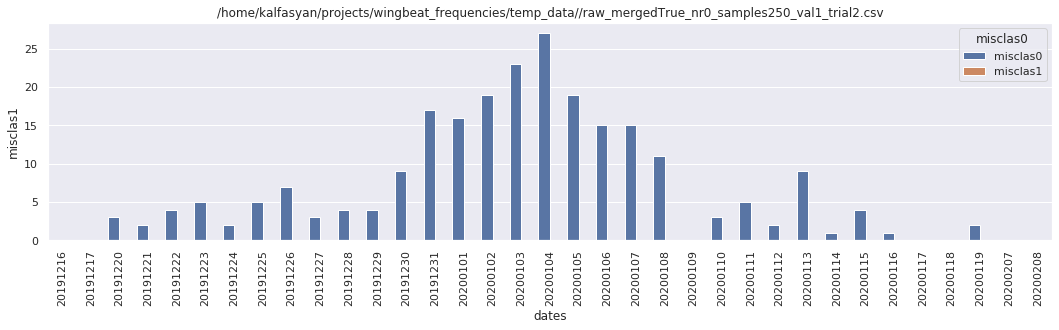

<Figure size 432x288 with 0 Axes>

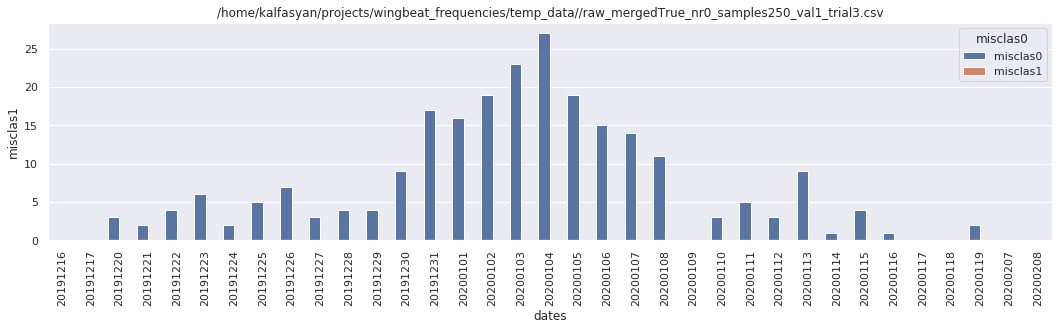

<Figure size 432x288 with 0 Axes>

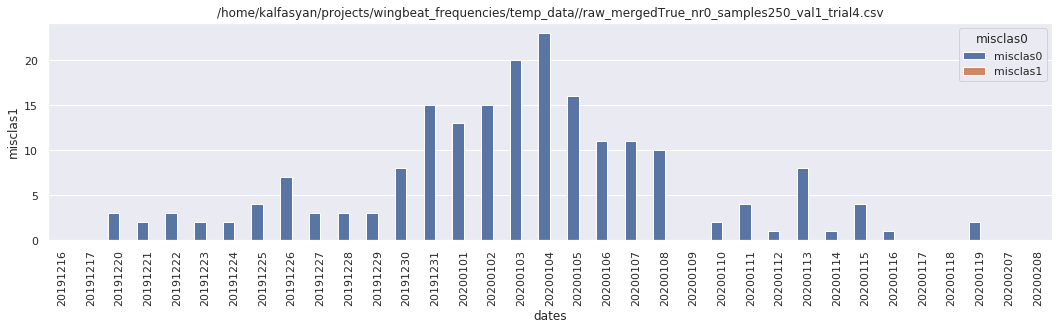

<Figure size 432x288 with 0 Axes>

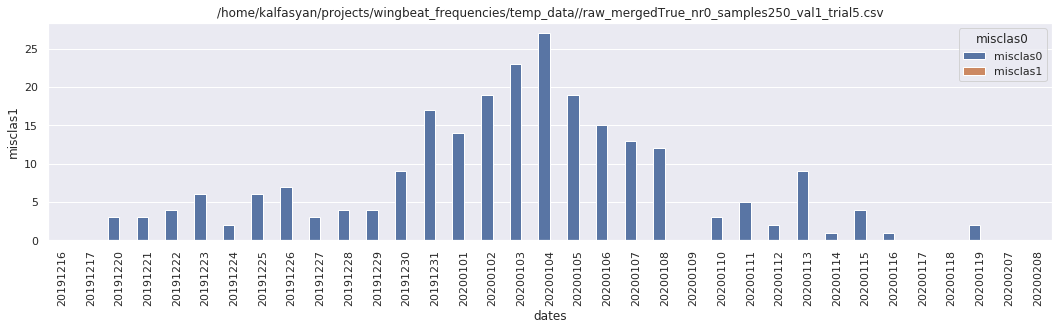

<Figure size 432x288 with 0 Axes>

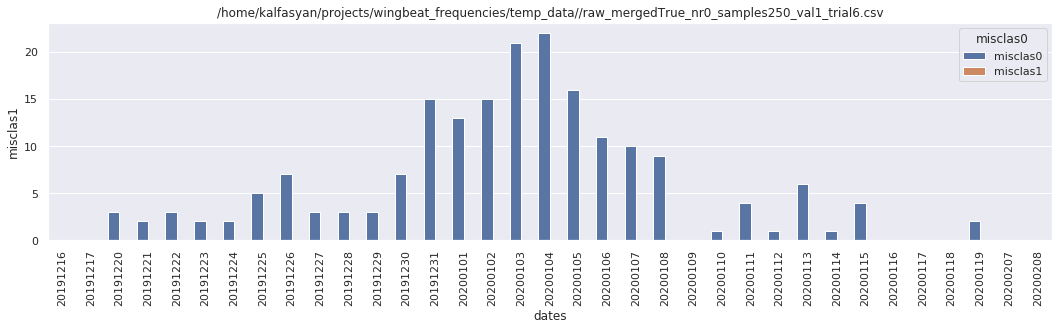

<Figure size 432x288 with 0 Axes>

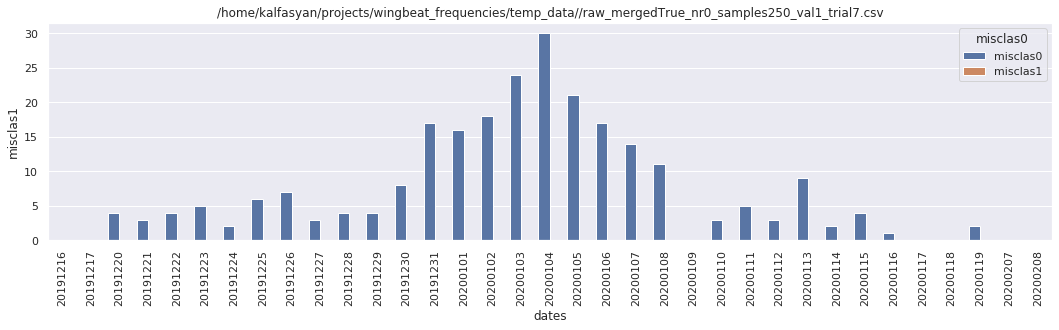

<Figure size 432x288 with 0 Axes>

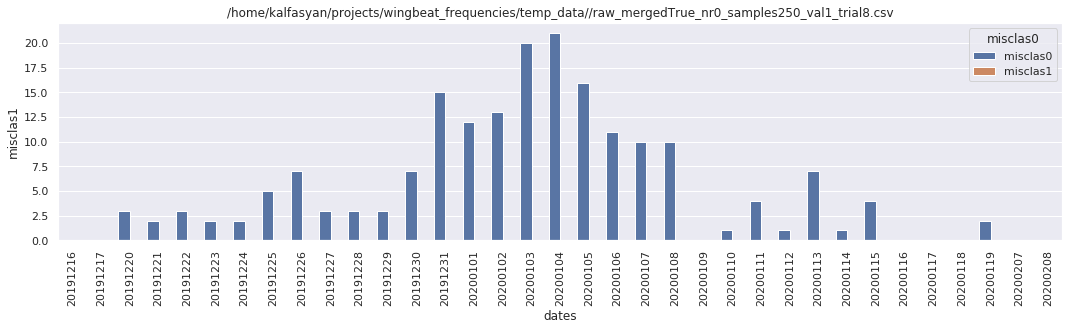

<Figure size 432x288 with 0 Axes>

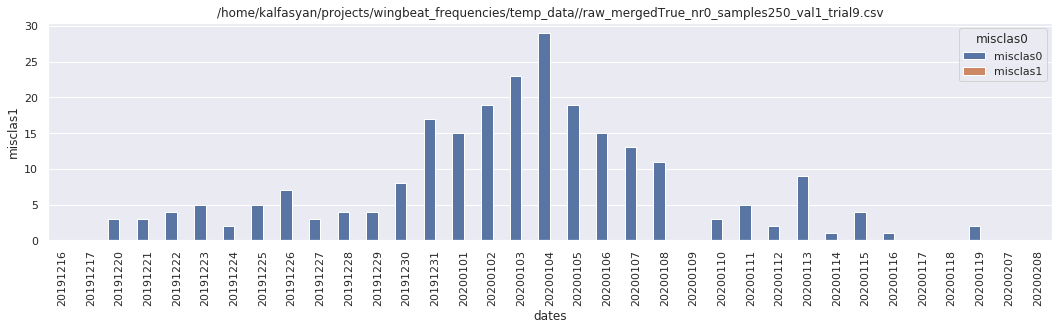

<Figure size 432x288 with 0 Axes>

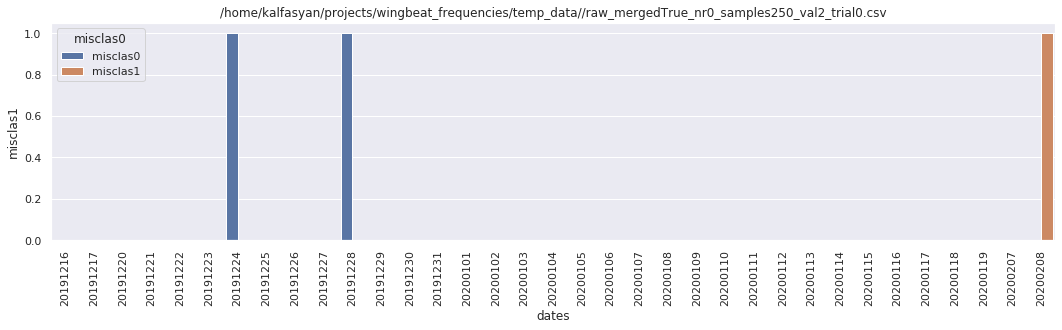

<Figure size 432x288 with 0 Axes>

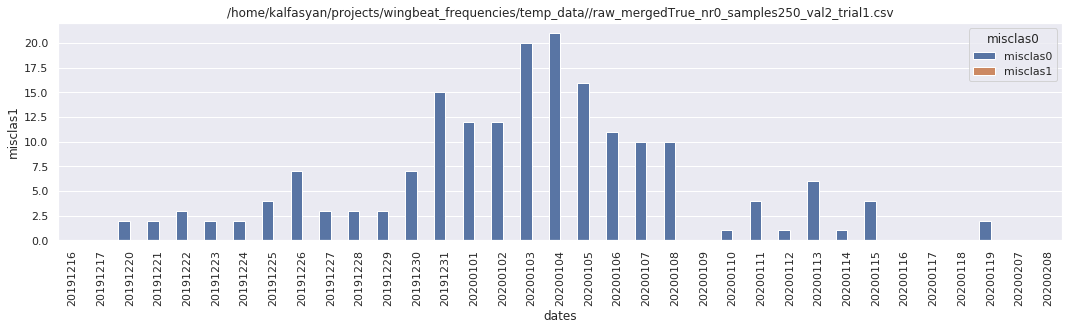

<Figure size 432x288 with 0 Axes>

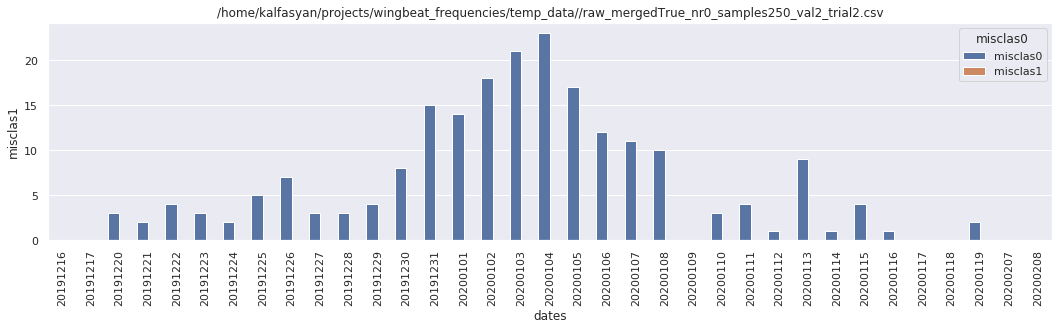

<Figure size 432x288 with 0 Axes>

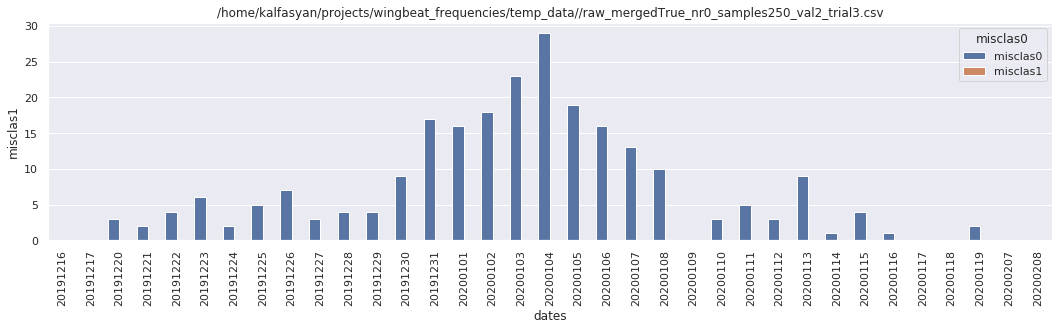

<Figure size 432x288 with 0 Axes>

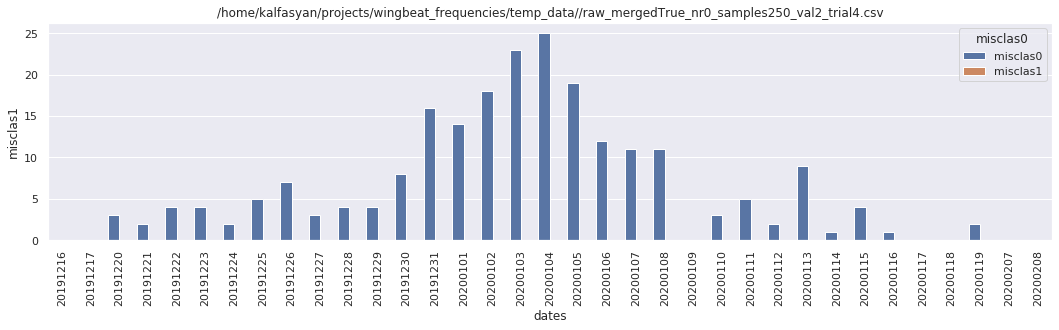

<Figure size 432x288 with 0 Axes>

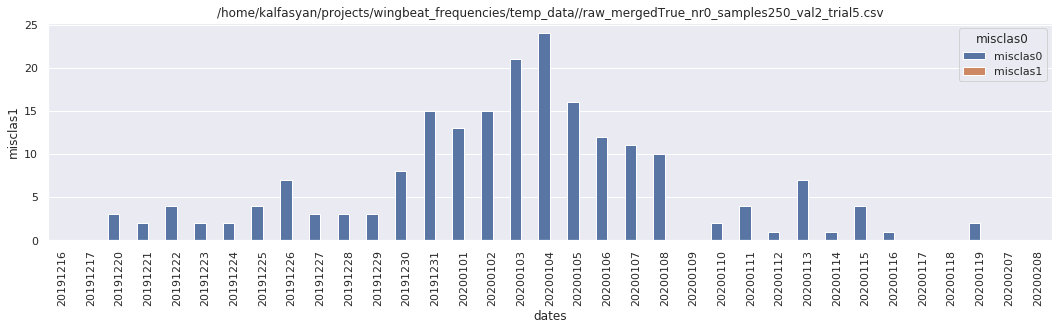

<Figure size 432x288 with 0 Axes>

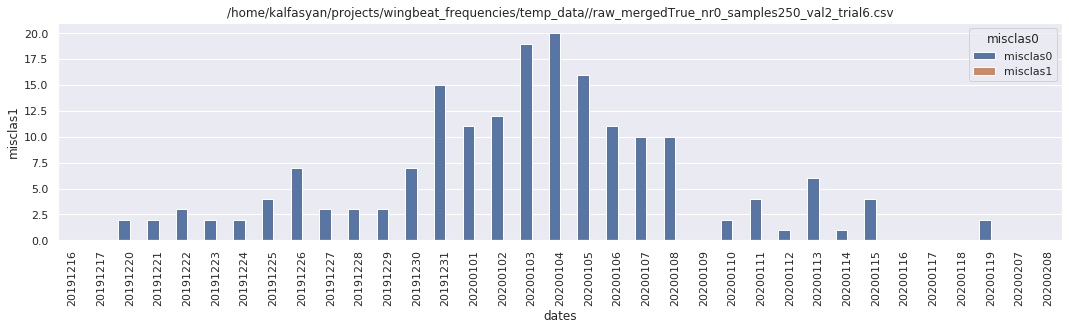

<Figure size 432x288 with 0 Axes>

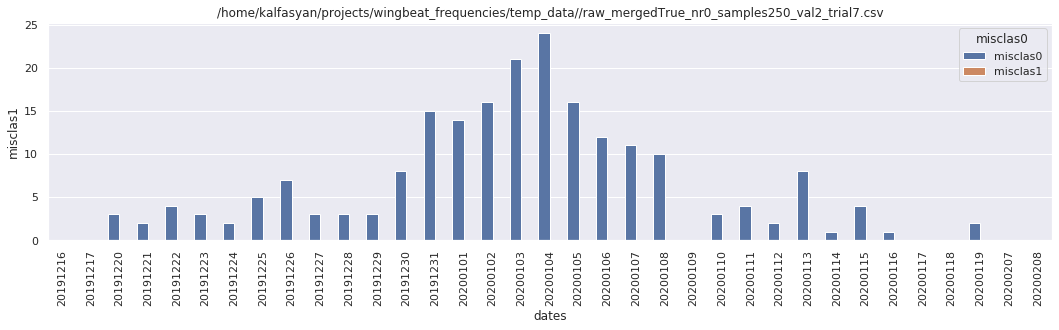

<Figure size 432x288 with 0 Axes>

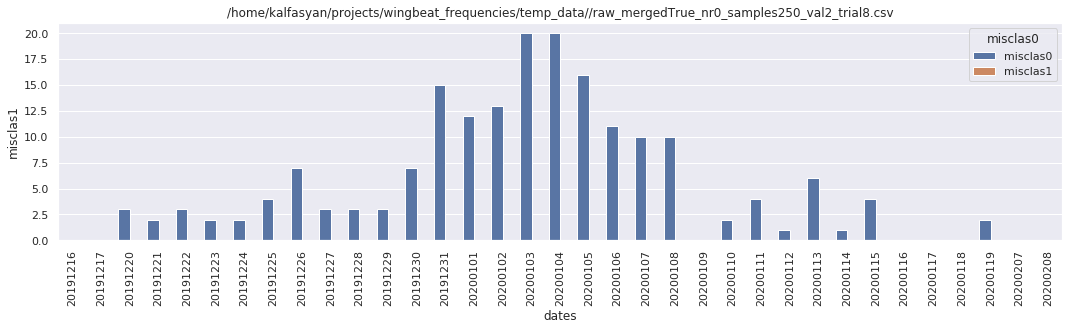

<Figure size 432x288 with 0 Axes>

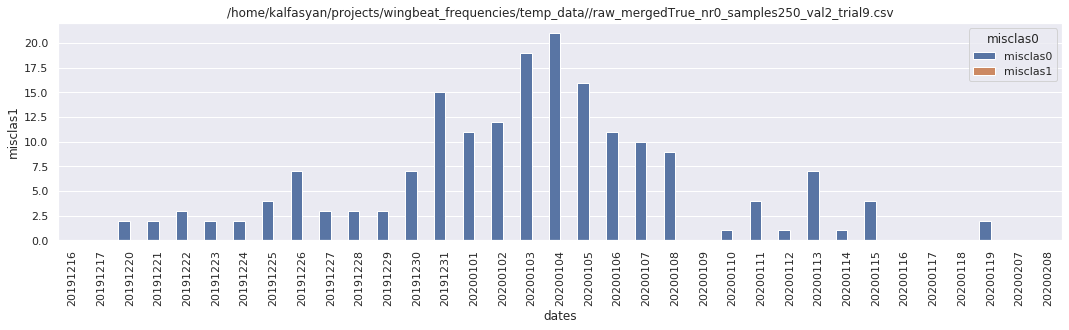

<Figure size 432x288 with 0 Axes>

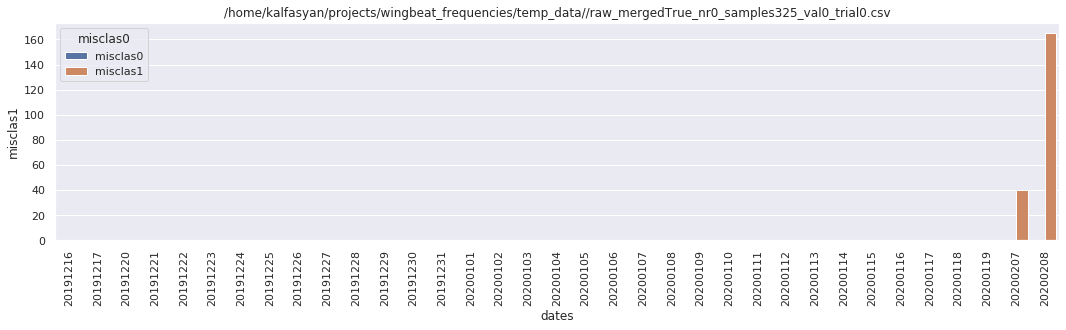

<Figure size 432x288 with 0 Axes>

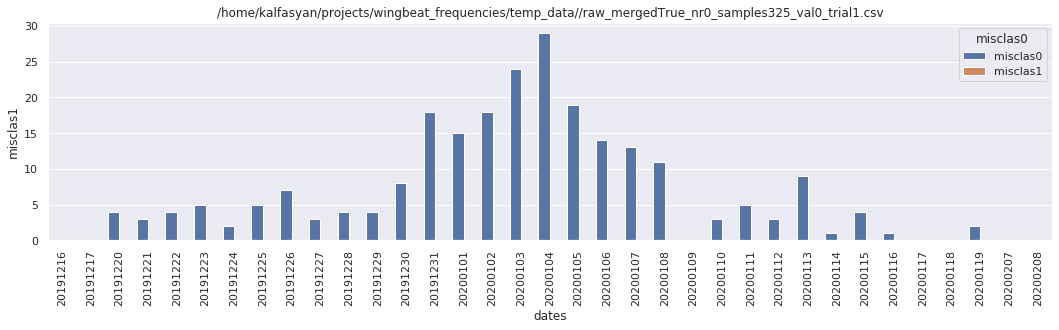

<Figure size 432x288 with 0 Axes>

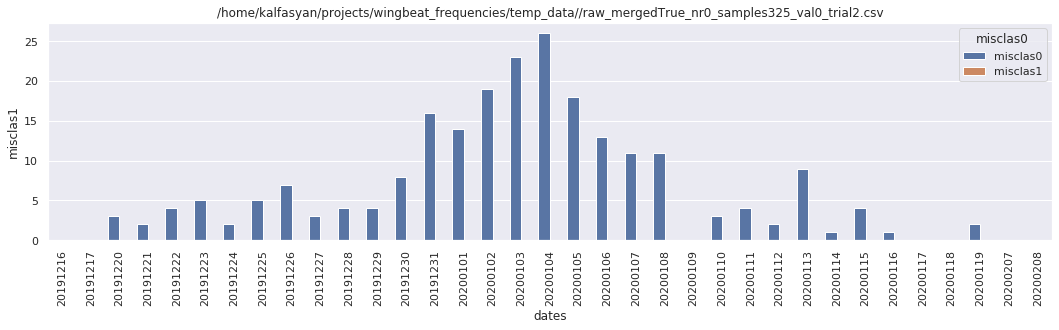

<Figure size 432x288 with 0 Axes>

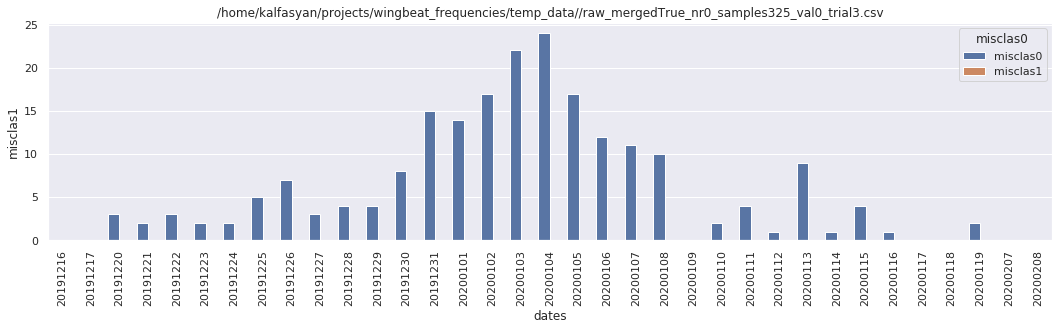

<Figure size 432x288 with 0 Axes>

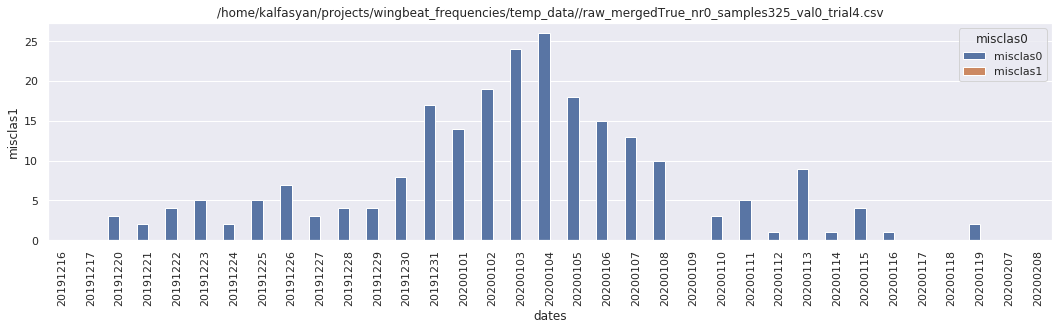

<Figure size 432x288 with 0 Axes>

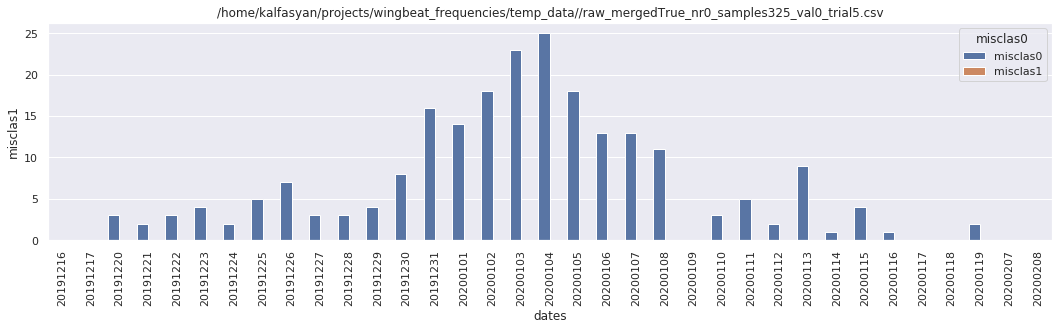

<Figure size 432x288 with 0 Axes>

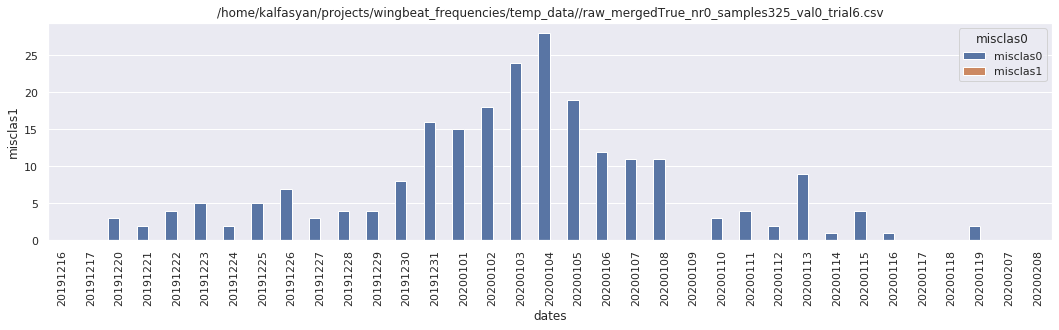

<Figure size 432x288 with 0 Axes>

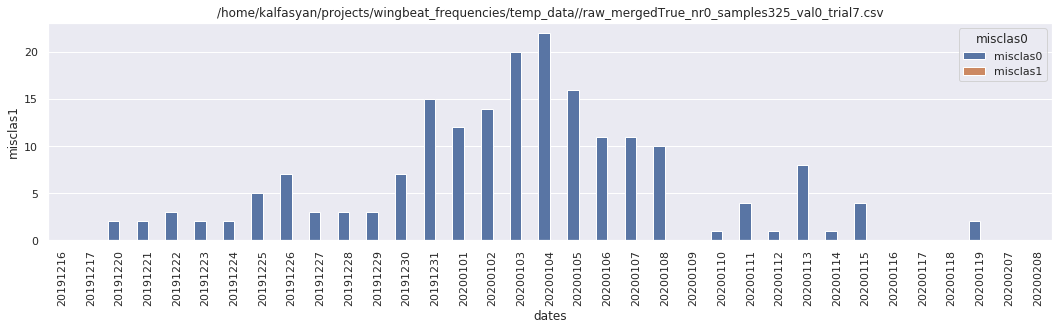

<Figure size 432x288 with 0 Axes>

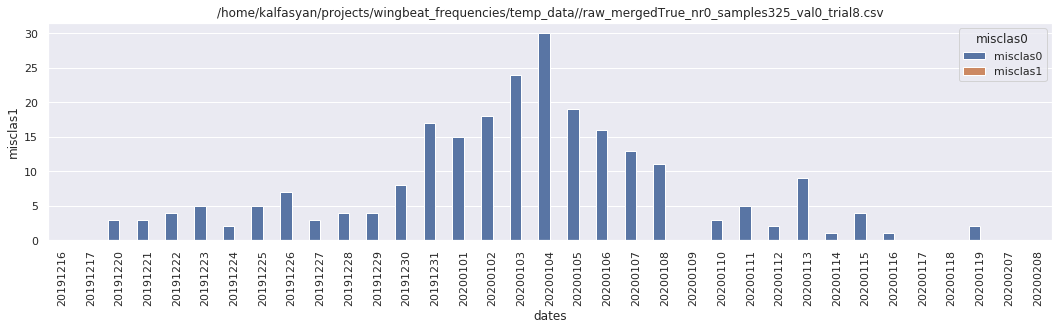

<Figure size 432x288 with 0 Axes>

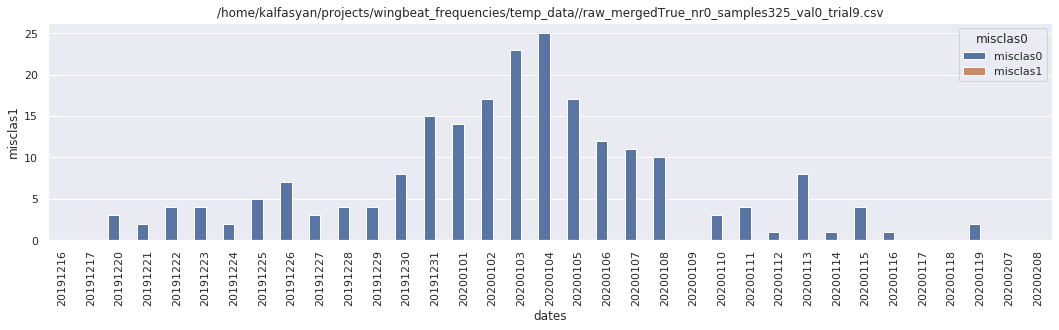

<Figure size 432x288 with 0 Axes>

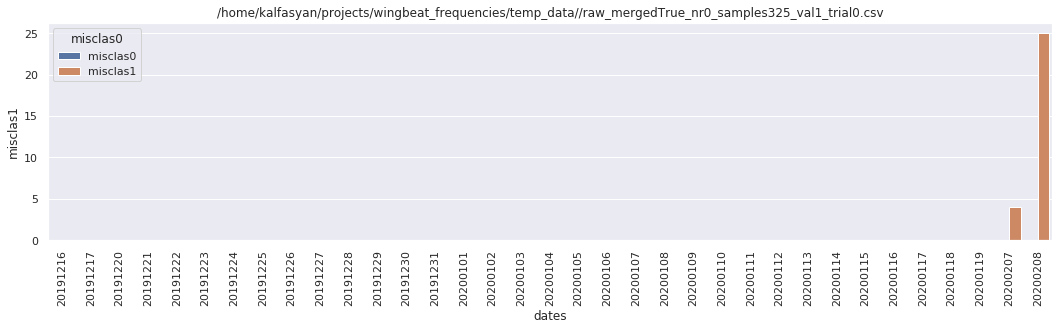

<Figure size 432x288 with 0 Axes>

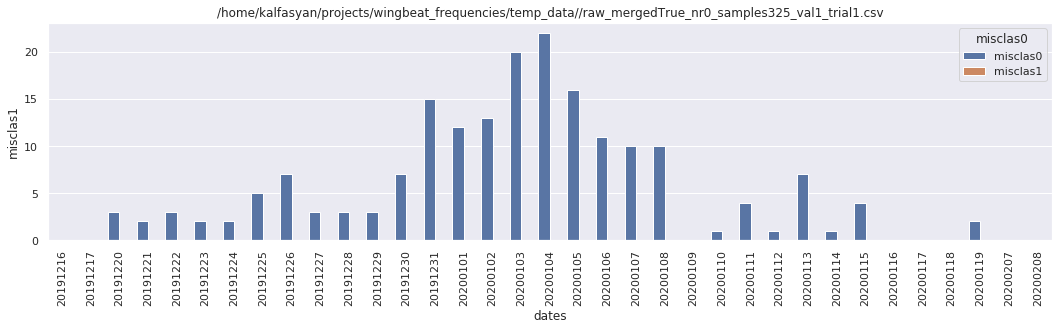

<Figure size 432x288 with 0 Axes>

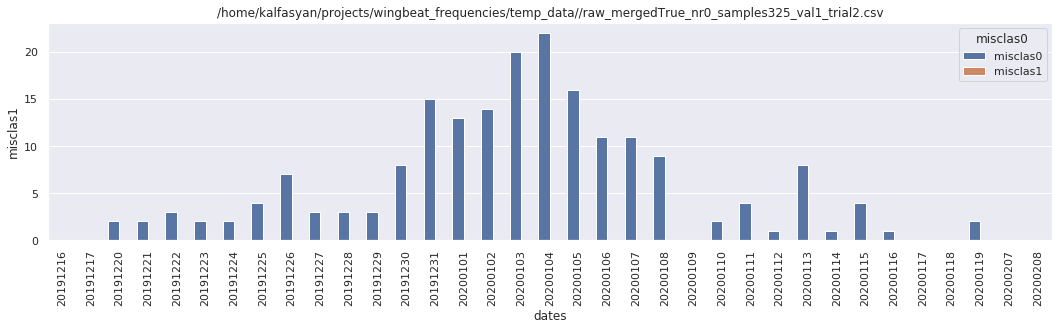

<Figure size 432x288 with 0 Axes>

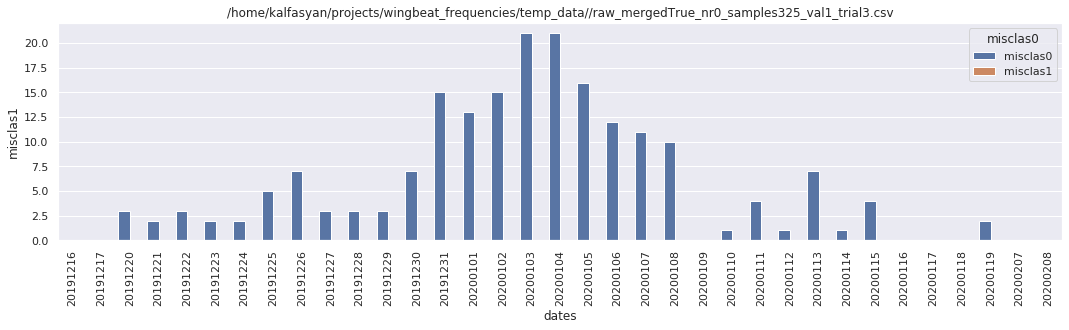

<Figure size 432x288 with 0 Axes>

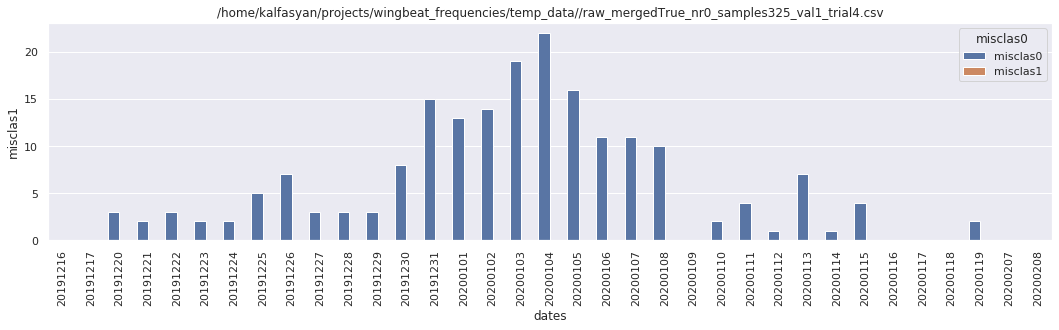

<Figure size 432x288 with 0 Axes>

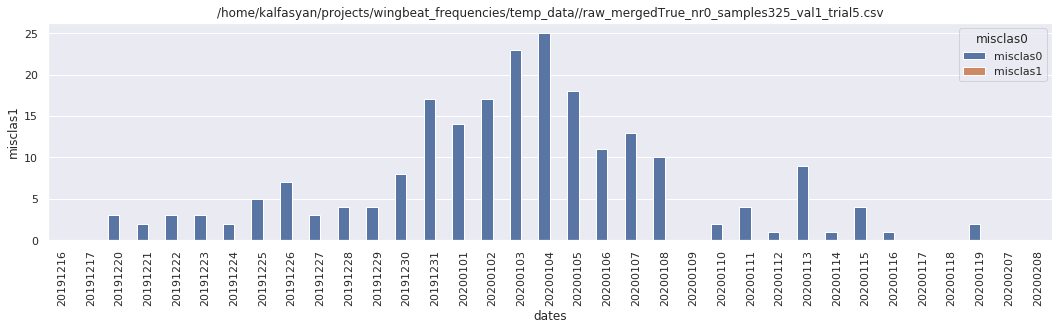

<Figure size 432x288 with 0 Axes>

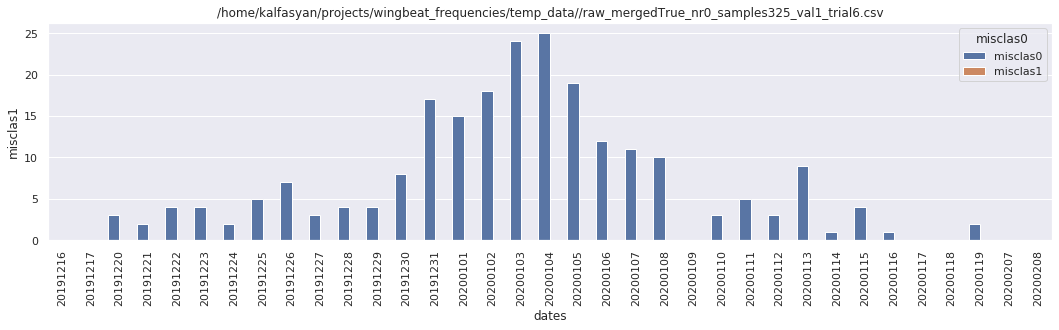

<Figure size 432x288 with 0 Axes>

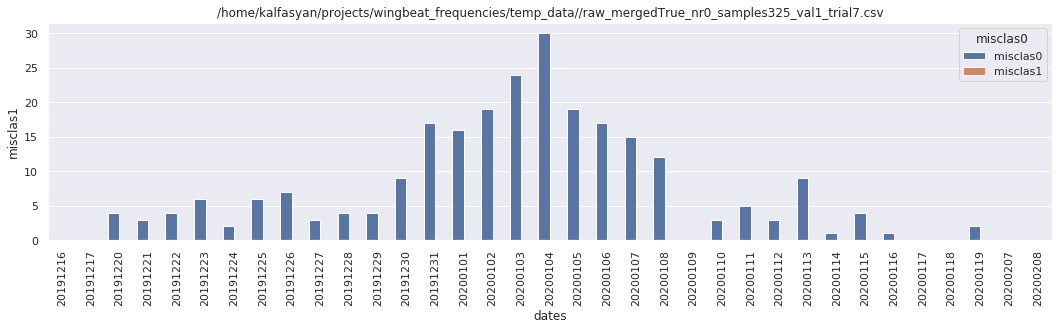

<Figure size 432x288 with 0 Axes>

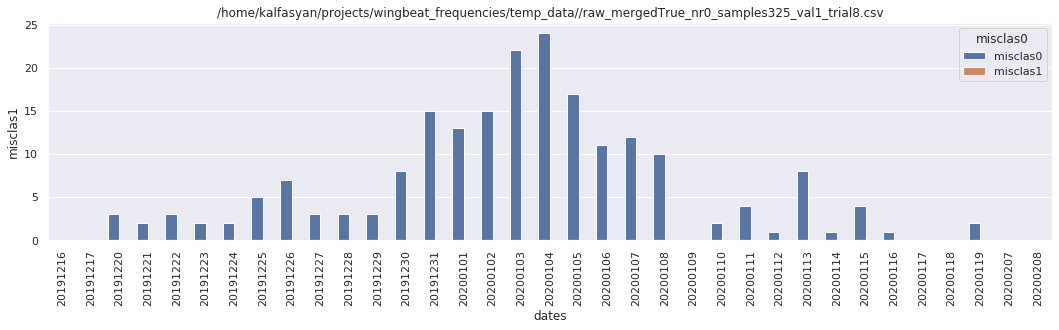

<Figure size 432x288 with 0 Axes>

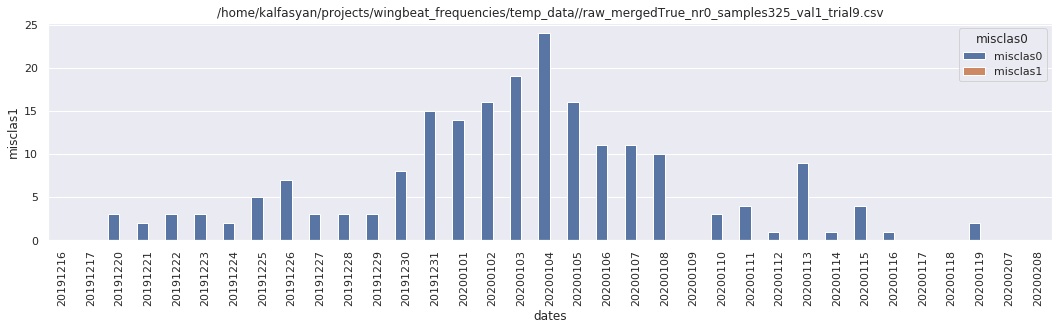

<Figure size 432x288 with 0 Axes>

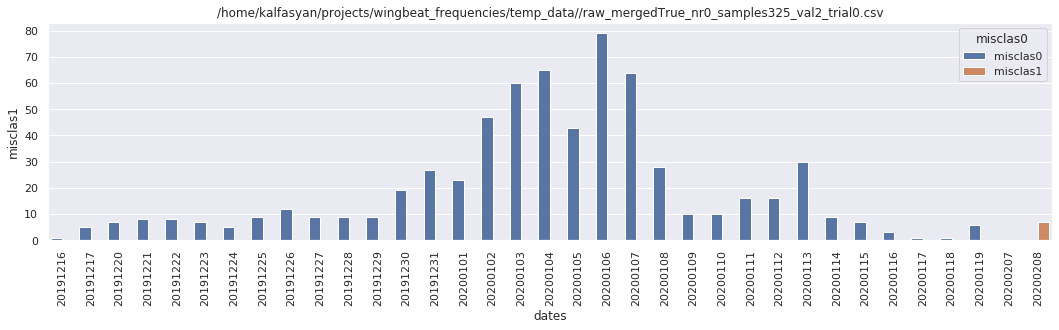

<Figure size 432x288 with 0 Axes>

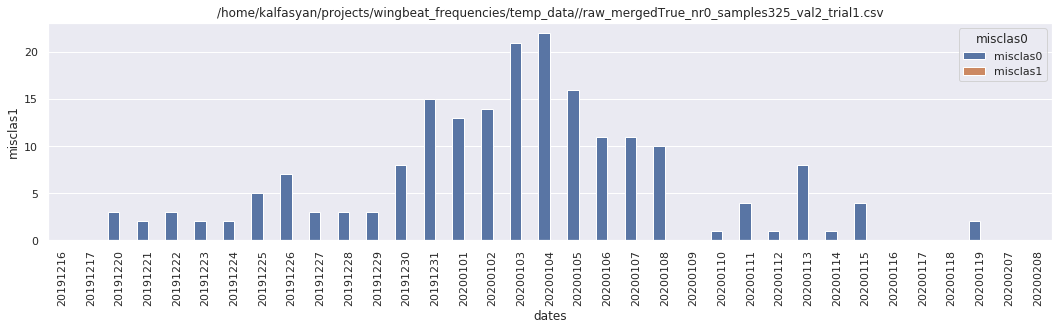

<Figure size 432x288 with 0 Axes>

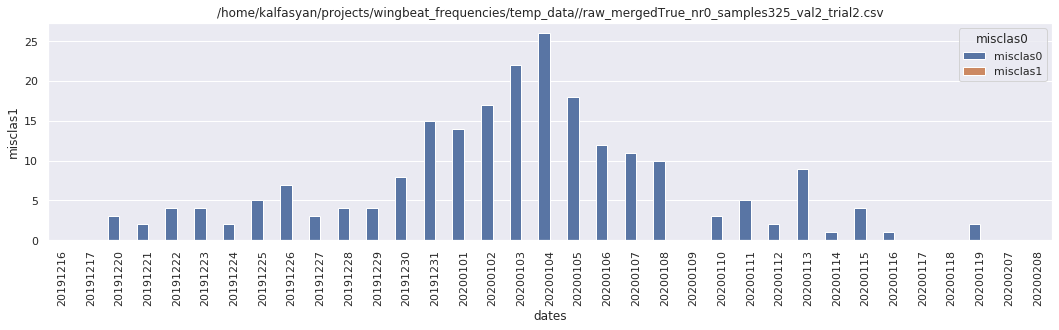

<Figure size 432x288 with 0 Axes>

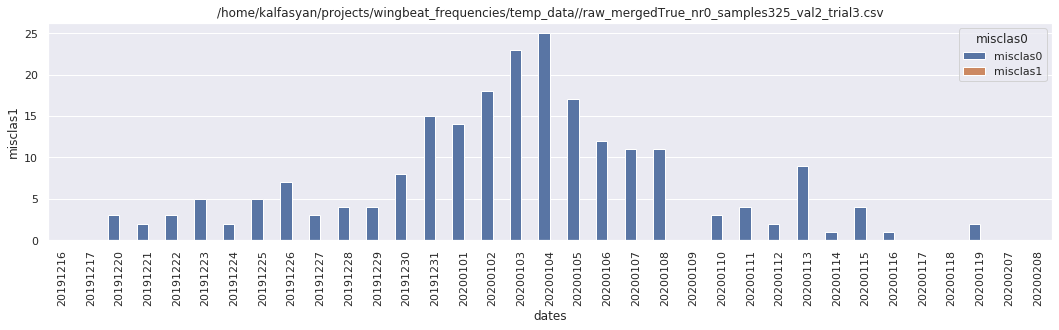

<Figure size 432x288 with 0 Axes>

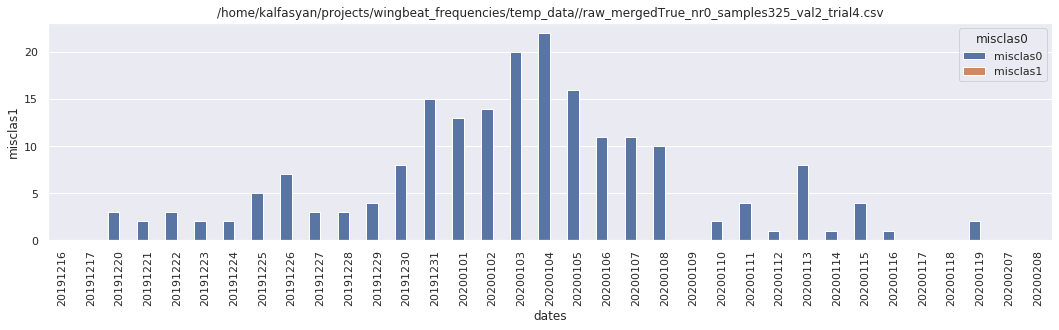

<Figure size 432x288 with 0 Axes>

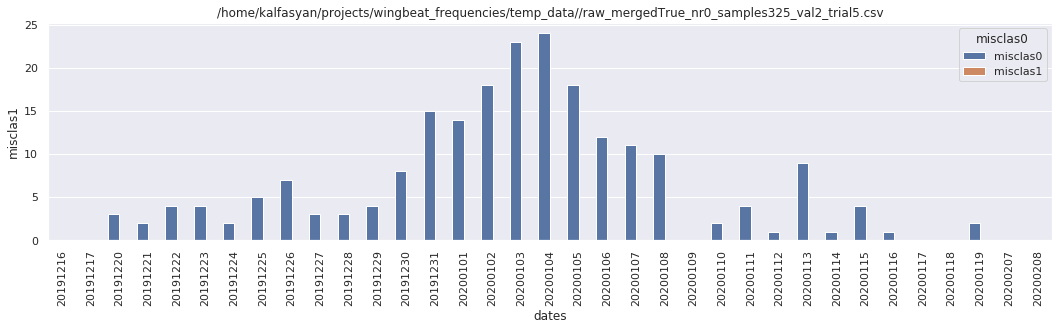

<Figure size 432x288 with 0 Axes>

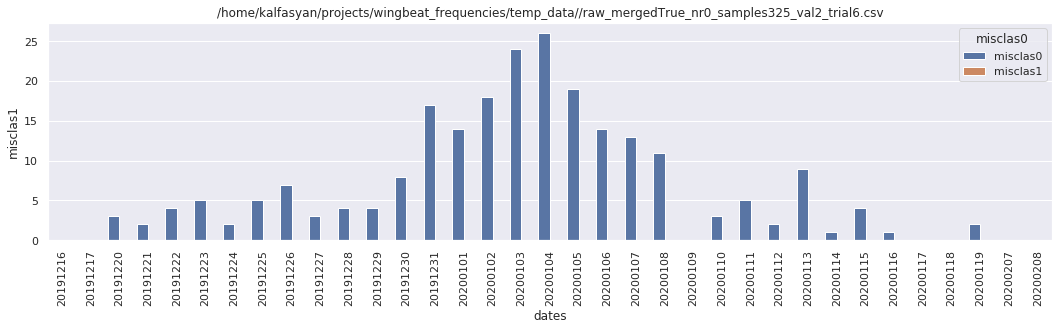

<Figure size 432x288 with 0 Axes>

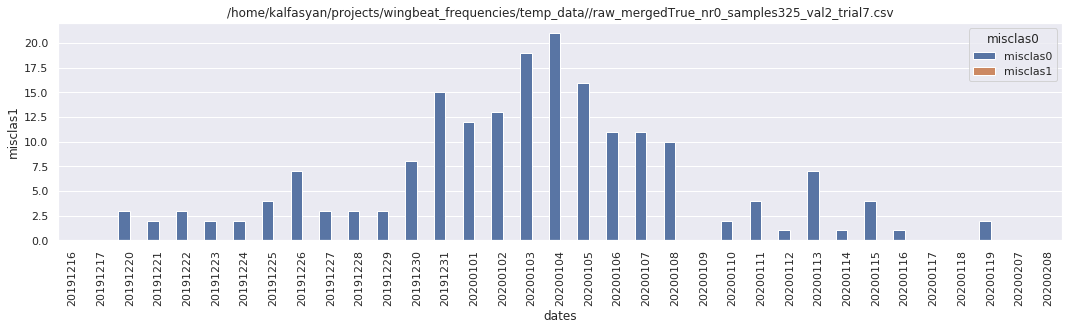

<Figure size 432x288 with 0 Axes>

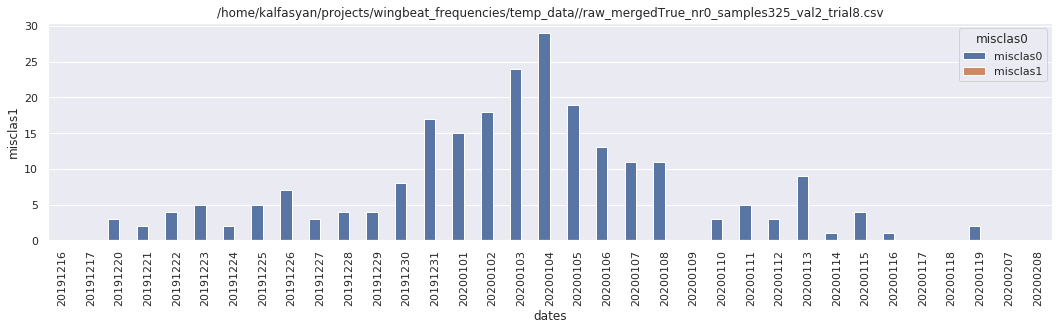

<Figure size 432x288 with 0 Axes>

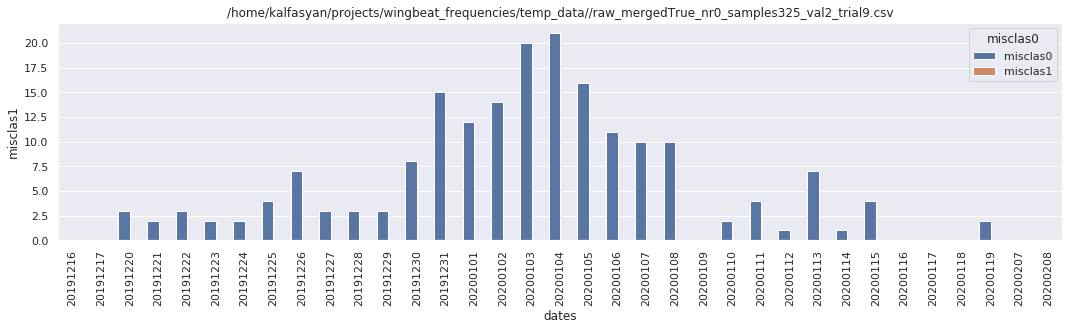

<Figure size 432x288 with 0 Axes>

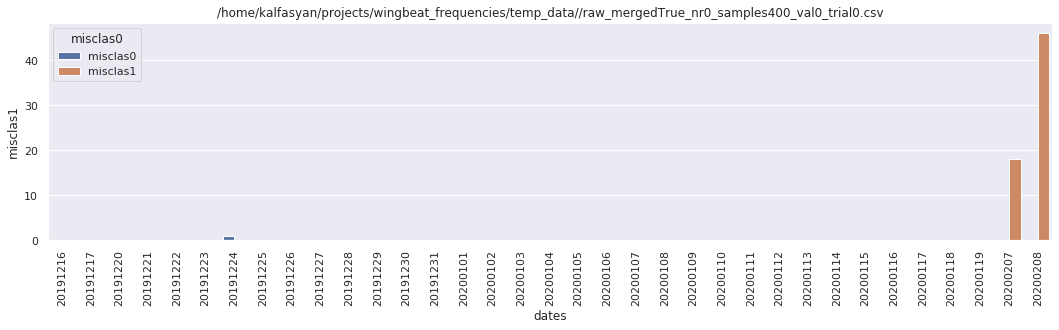

<Figure size 432x288 with 0 Axes>

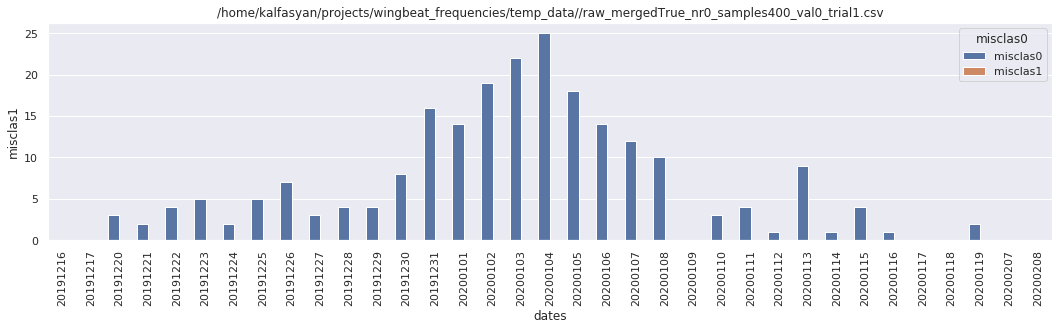

<Figure size 432x288 with 0 Axes>

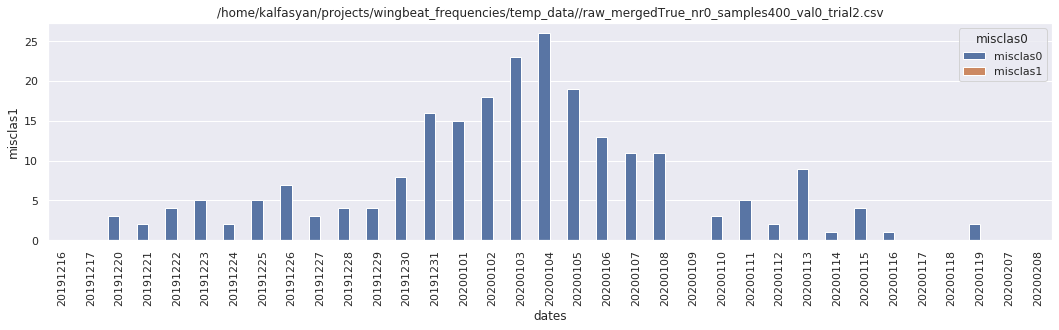

<Figure size 432x288 with 0 Axes>

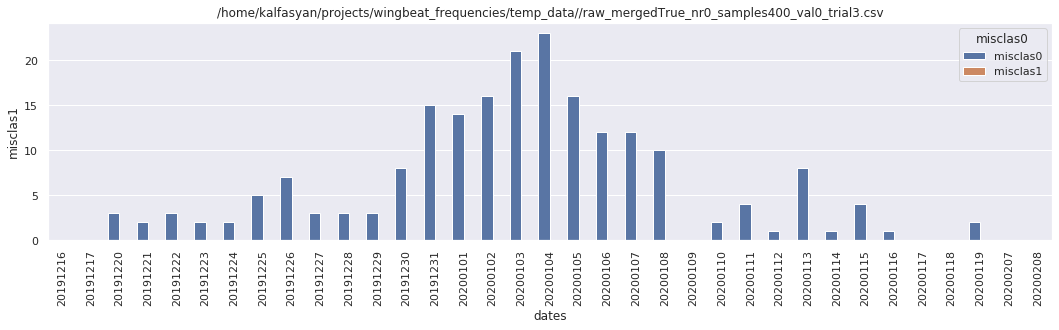

<Figure size 432x288 with 0 Axes>

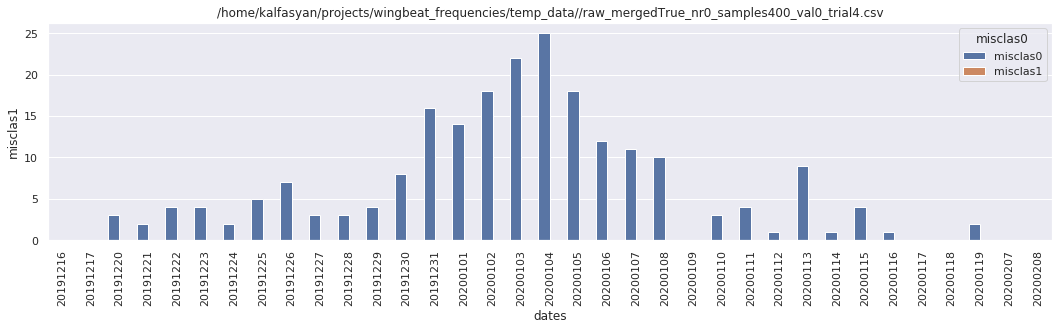

<Figure size 432x288 with 0 Axes>

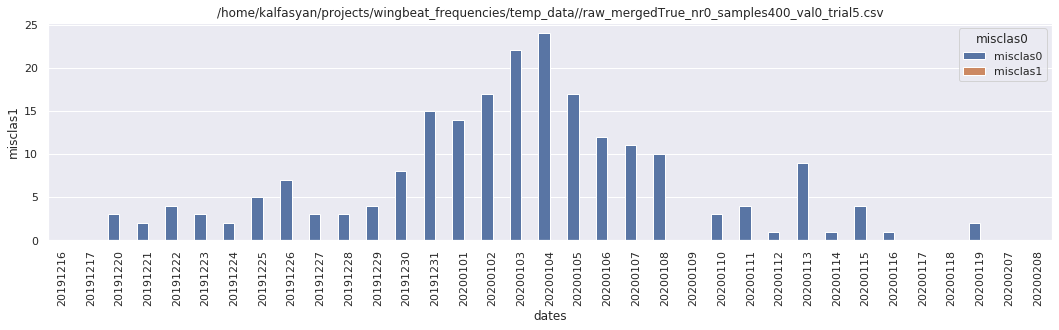

<Figure size 432x288 with 0 Axes>

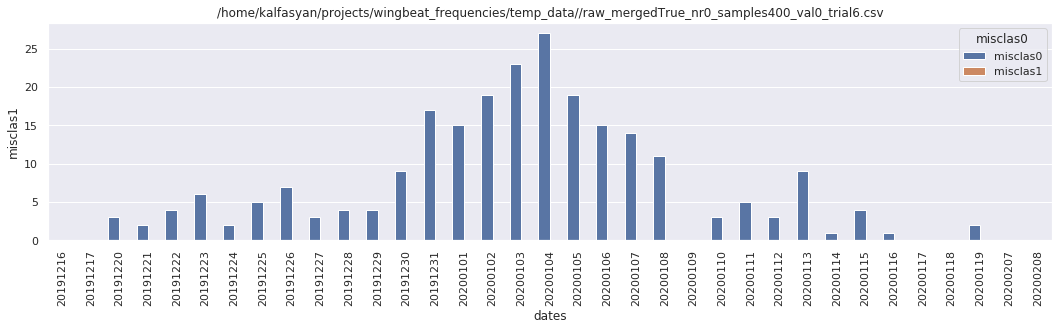

<Figure size 432x288 with 0 Axes>

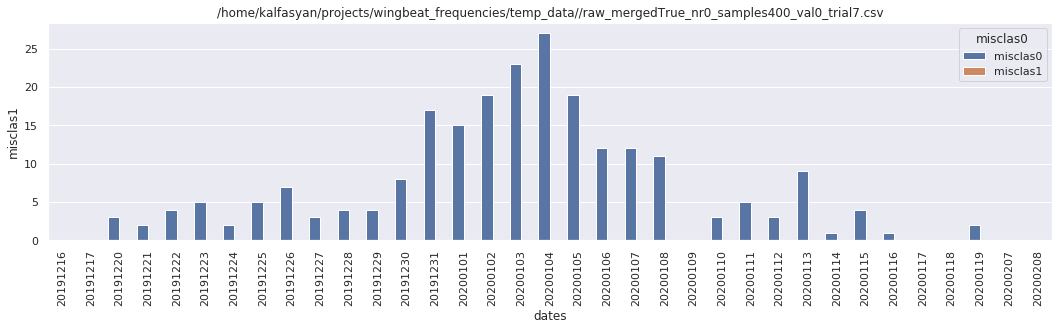

<Figure size 432x288 with 0 Axes>

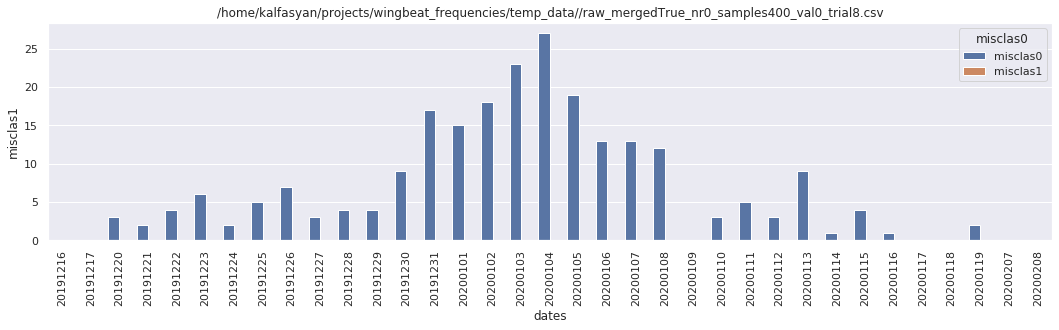

<Figure size 432x288 with 0 Axes>

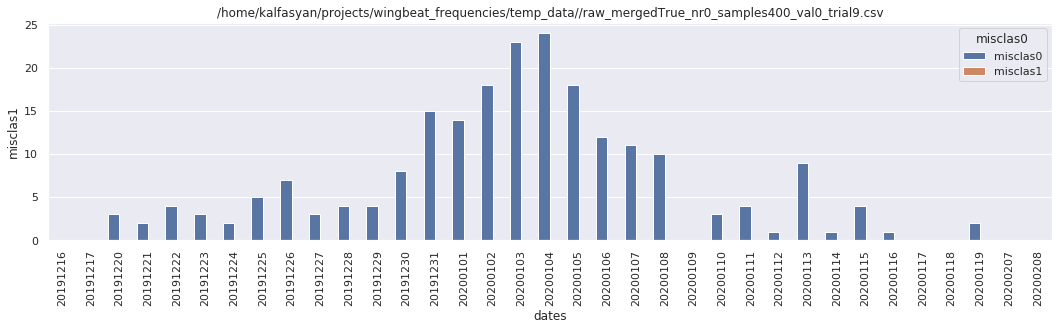

<Figure size 432x288 with 0 Axes>

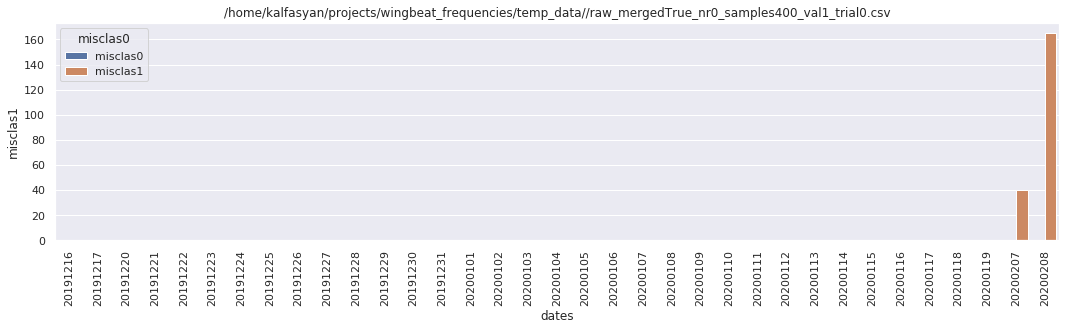

<Figure size 432x288 with 0 Axes>

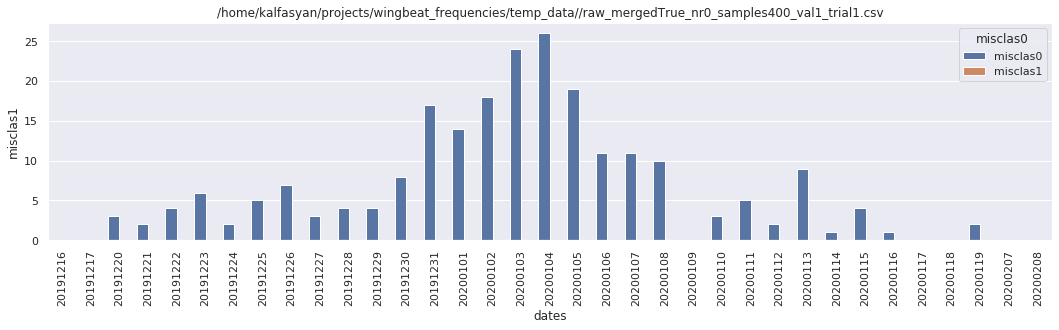

<Figure size 432x288 with 0 Axes>

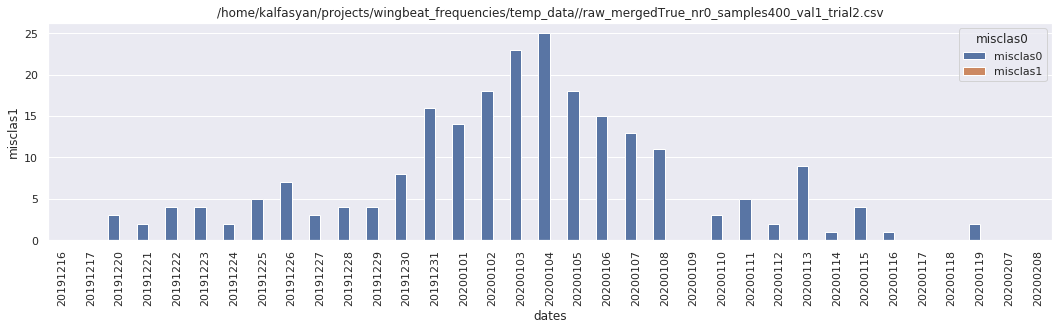

<Figure size 432x288 with 0 Axes>

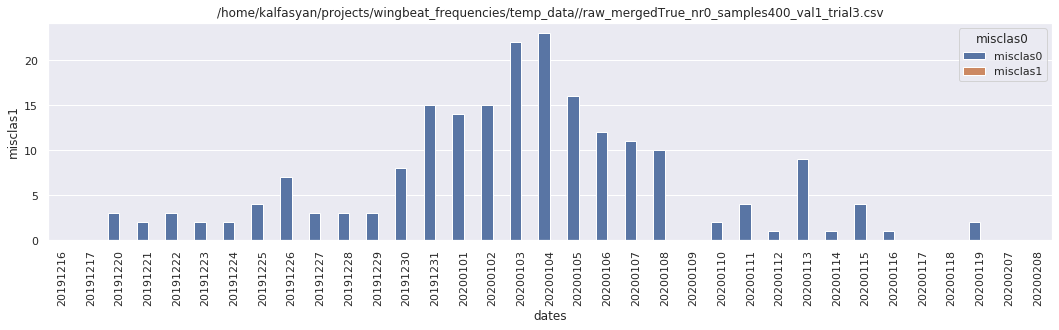

<Figure size 432x288 with 0 Axes>

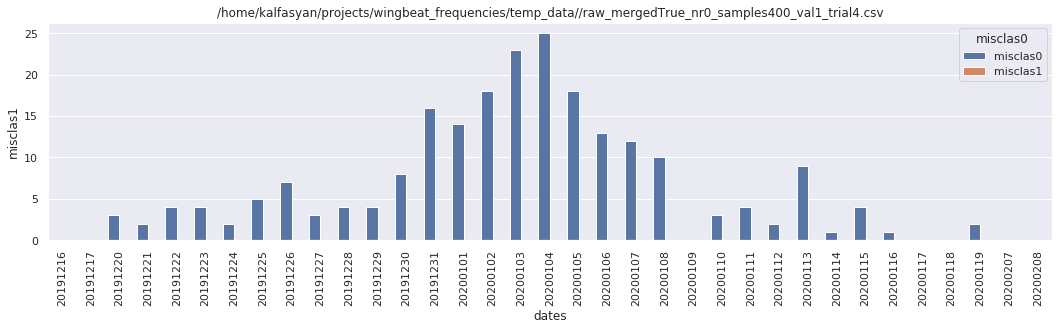

<Figure size 432x288 with 0 Axes>

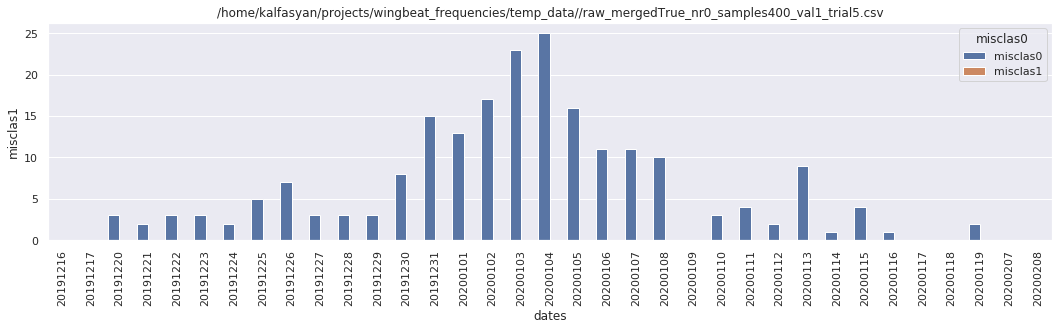

<Figure size 432x288 with 0 Axes>

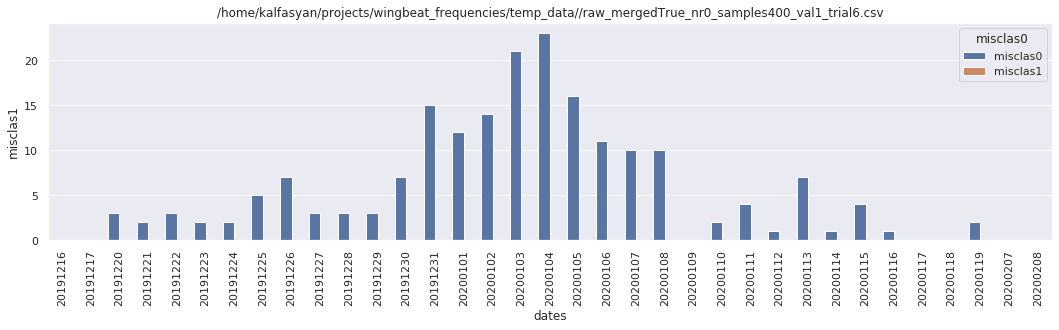

<Figure size 432x288 with 0 Axes>

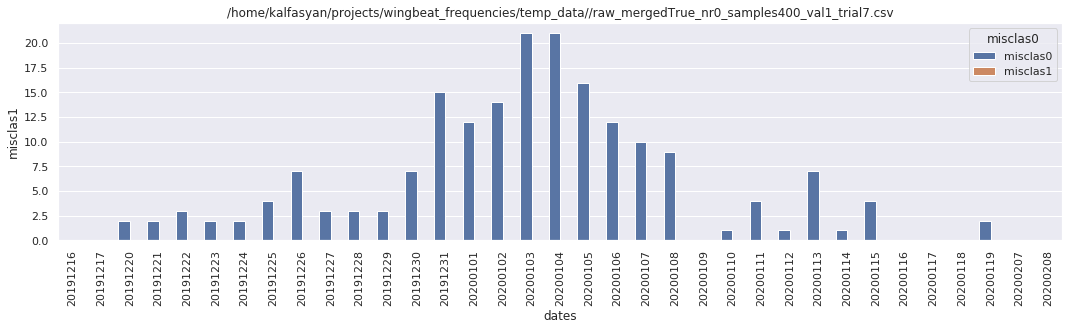

<Figure size 432x288 with 0 Axes>

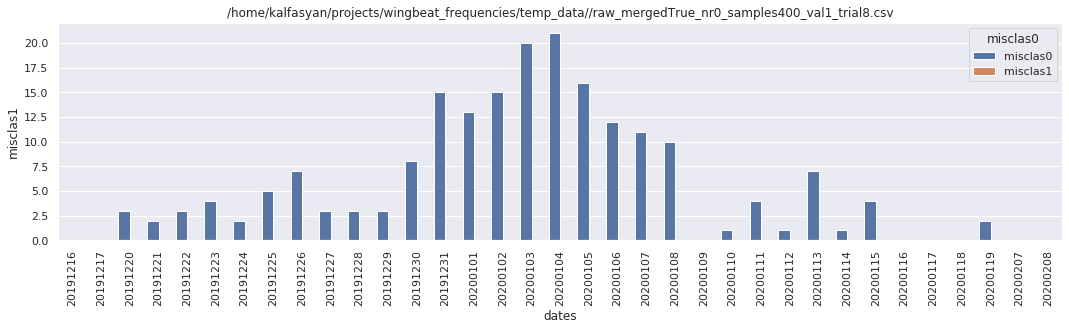

<Figure size 432x288 with 0 Axes>

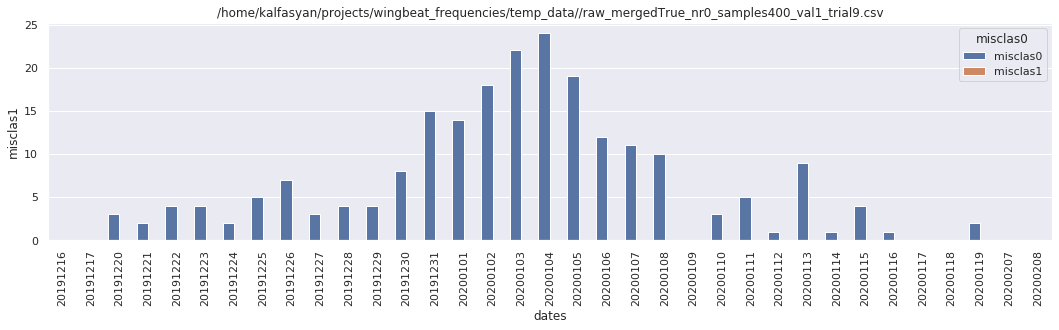

<Figure size 432x288 with 0 Axes>

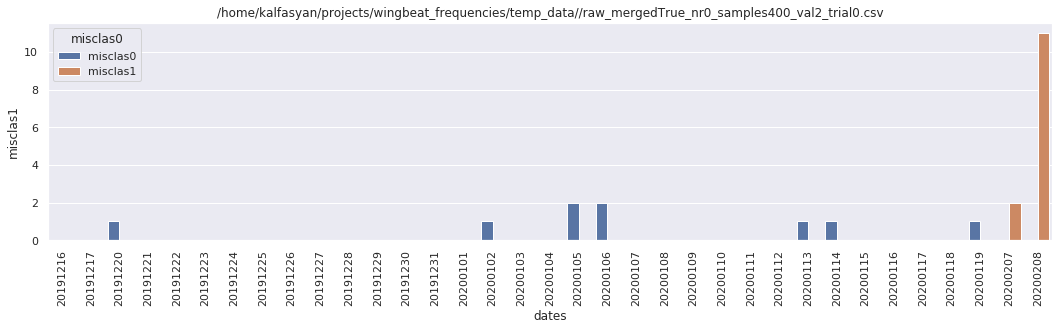

<Figure size 432x288 with 0 Axes>

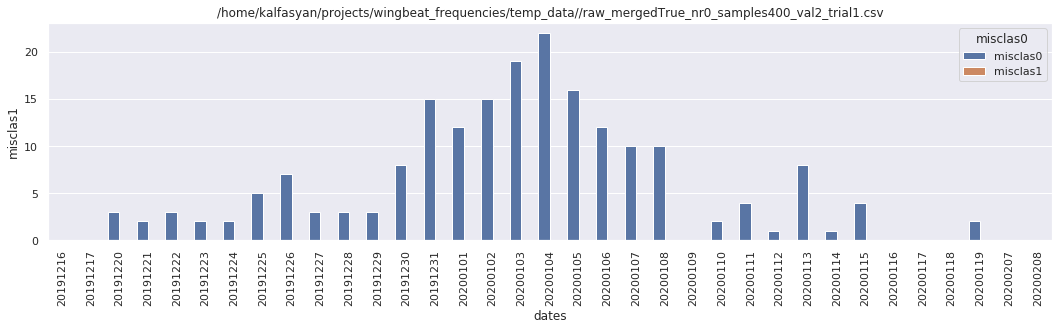

<Figure size 432x288 with 0 Axes>

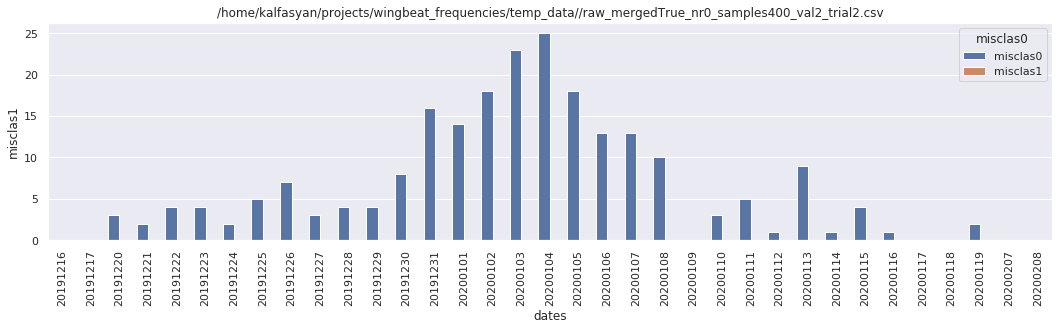

<Figure size 432x288 with 0 Axes>

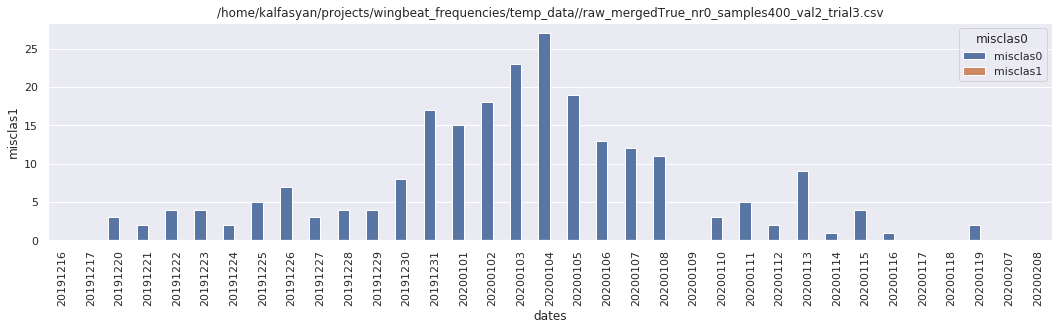

<Figure size 432x288 with 0 Axes>

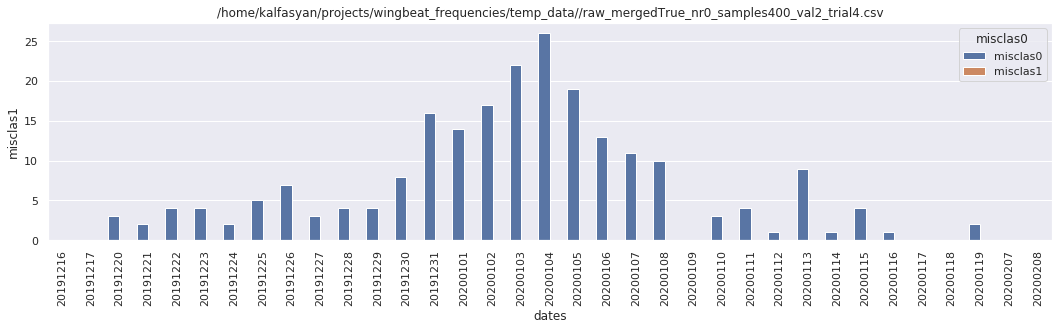

<Figure size 432x288 with 0 Axes>

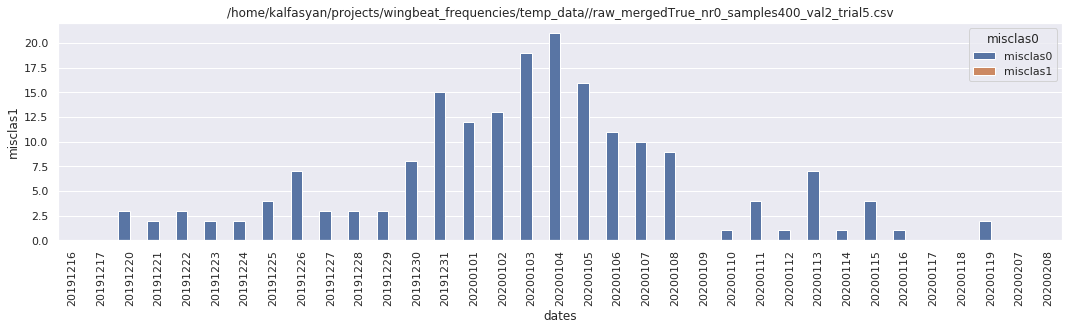

<Figure size 432x288 with 0 Axes>

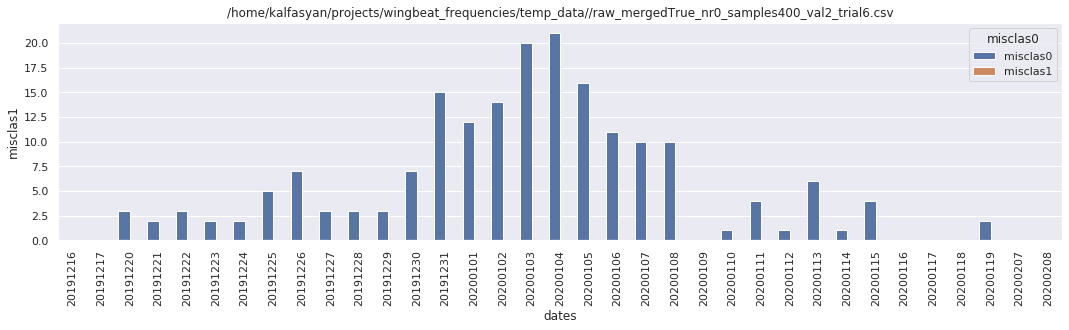

<Figure size 432x288 with 0 Axes>

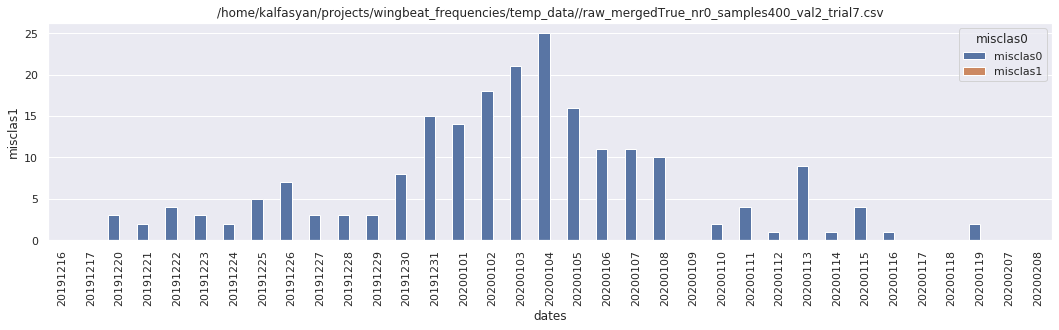

<Figure size 432x288 with 0 Axes>

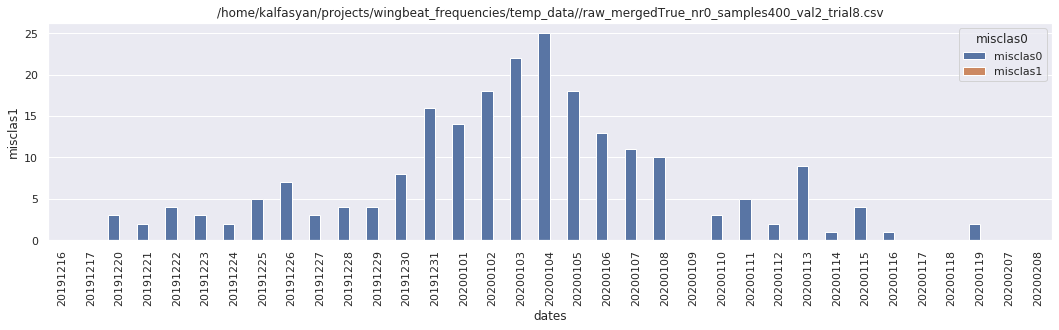

<Figure size 432x288 with 0 Axes>

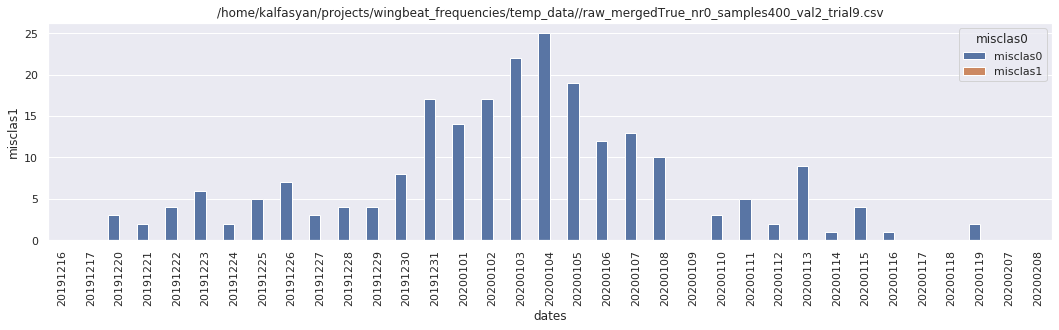

<Figure size 432x288 with 0 Axes>

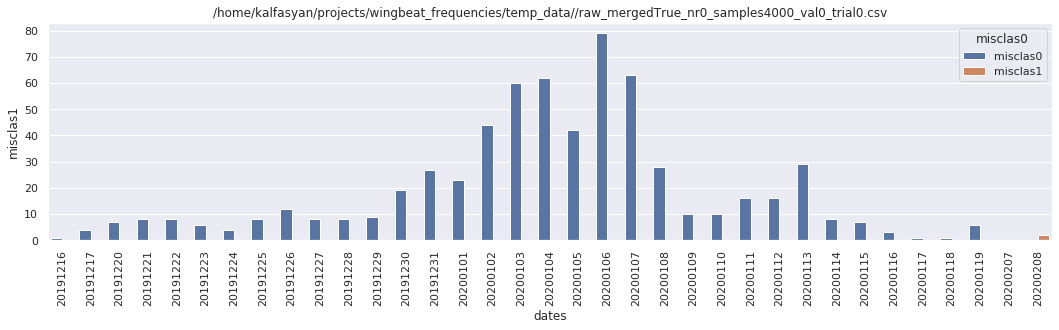

<Figure size 432x288 with 0 Axes>

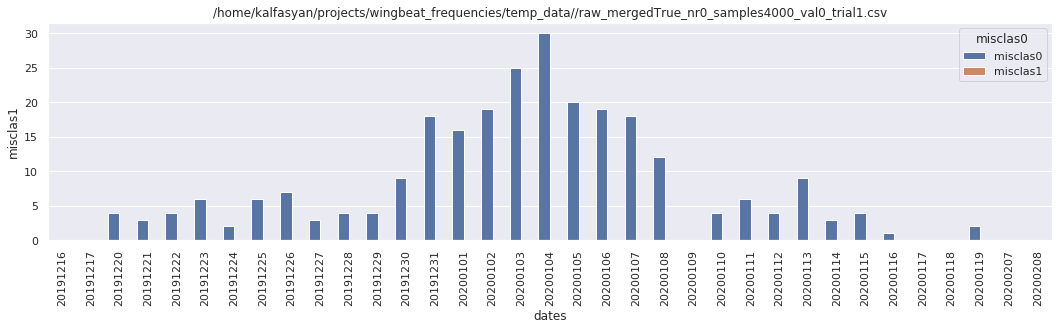

<Figure size 432x288 with 0 Axes>

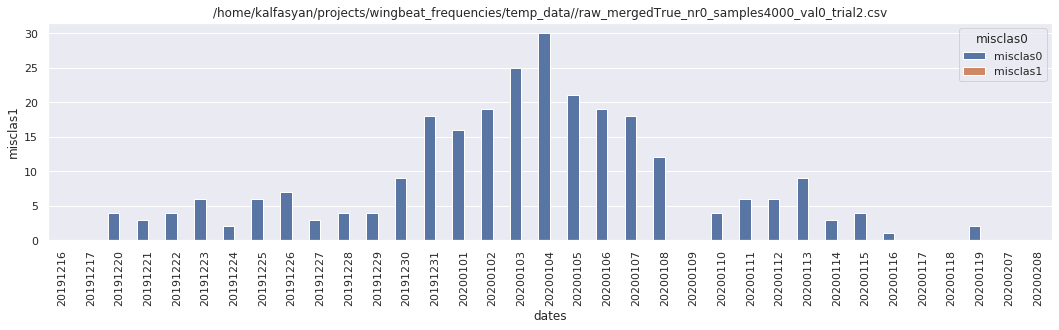

<Figure size 432x288 with 0 Axes>

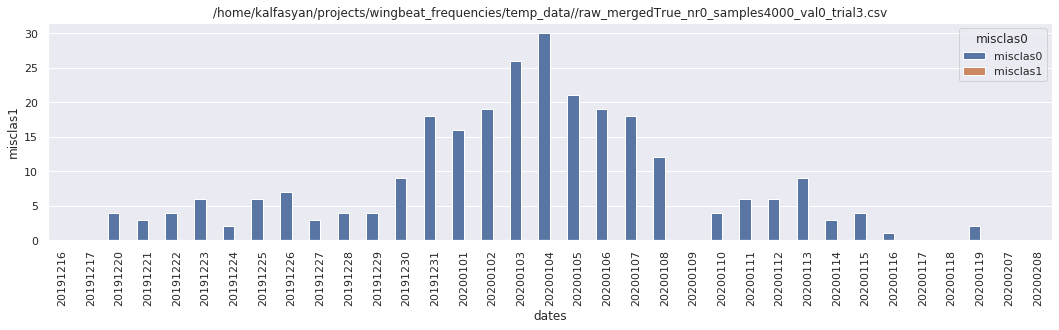

<Figure size 432x288 with 0 Axes>

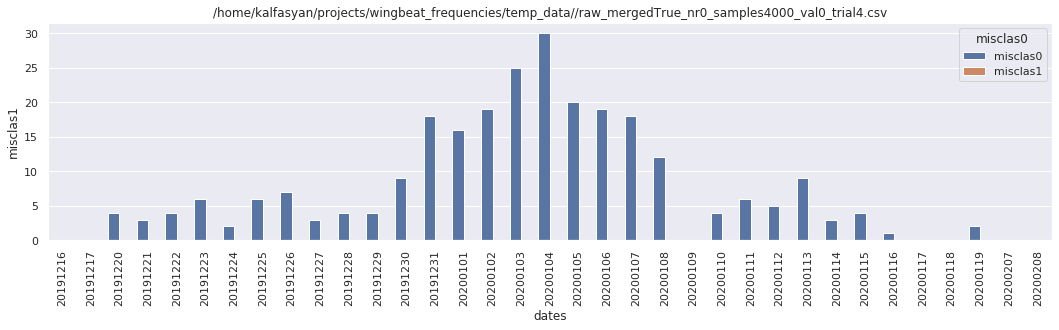

<Figure size 432x288 with 0 Axes>

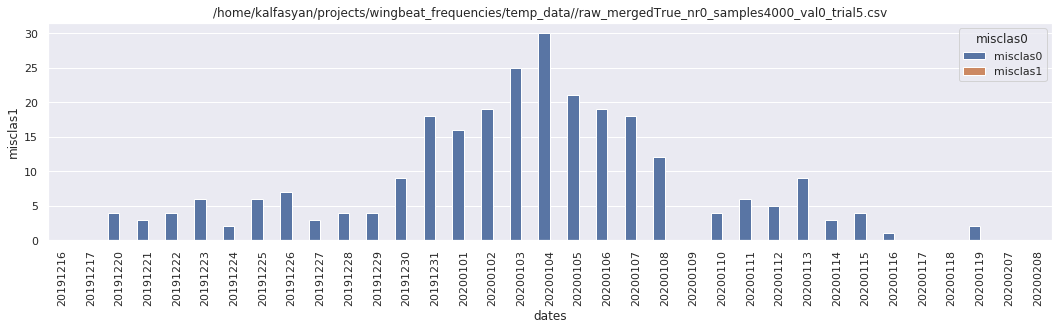

<Figure size 432x288 with 0 Axes>

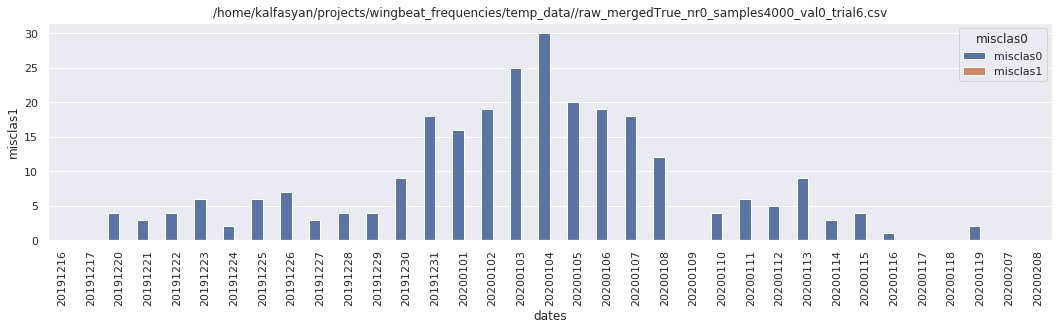

<Figure size 432x288 with 0 Axes>

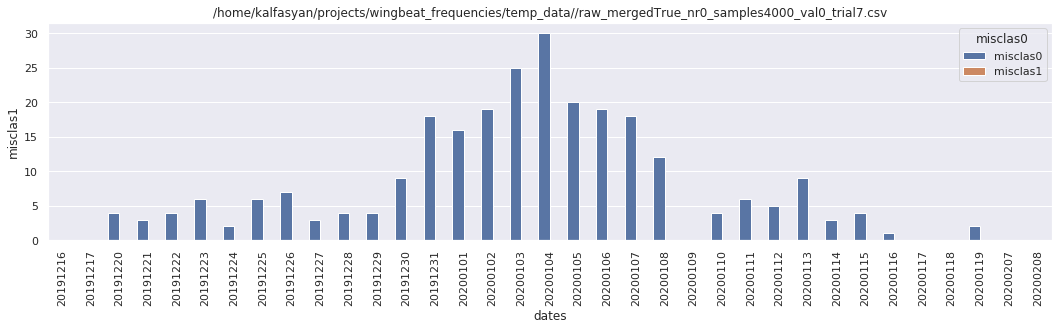

<Figure size 432x288 with 0 Axes>

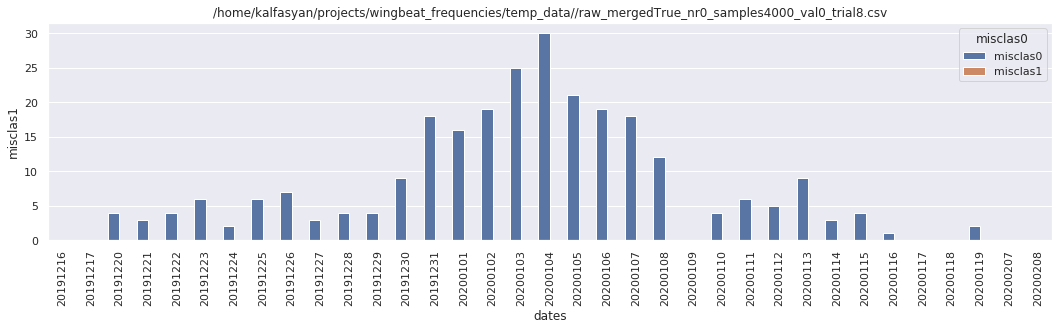

<Figure size 432x288 with 0 Axes>

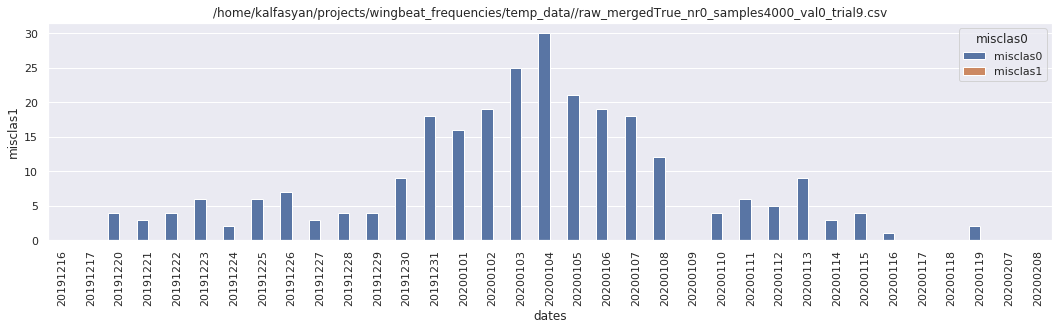

<Figure size 432x288 with 0 Axes>

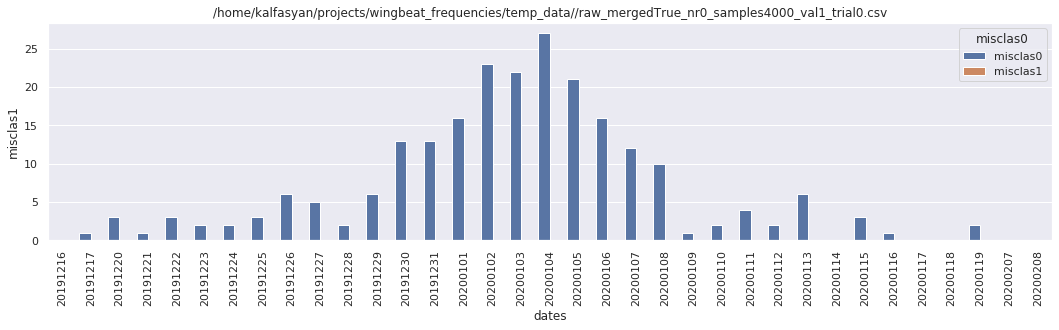

<Figure size 432x288 with 0 Axes>

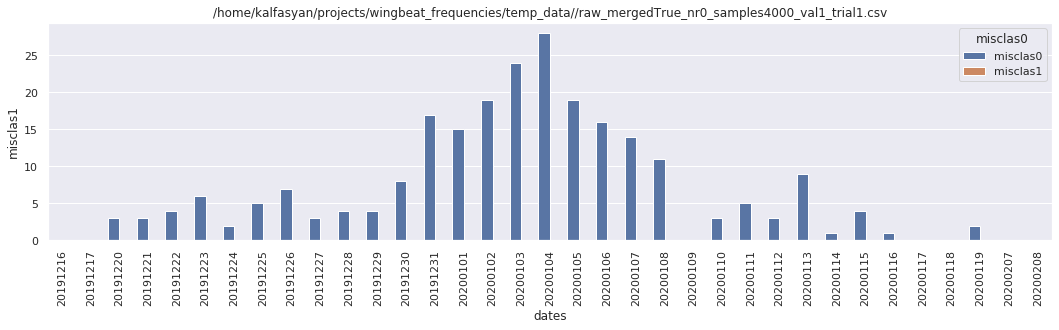

<Figure size 432x288 with 0 Axes>

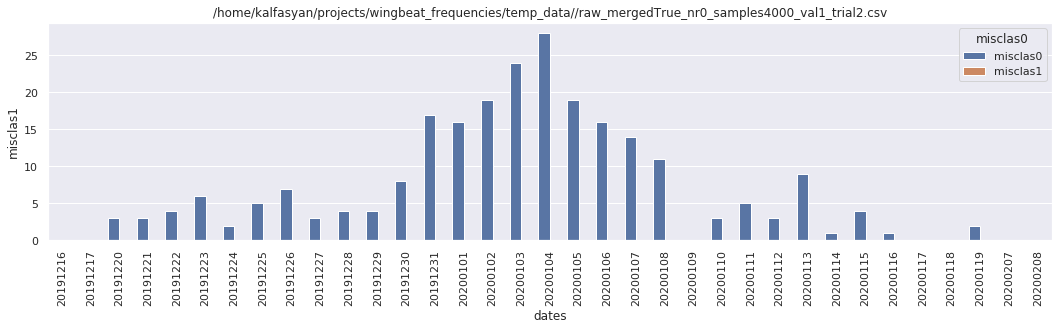

<Figure size 432x288 with 0 Axes>

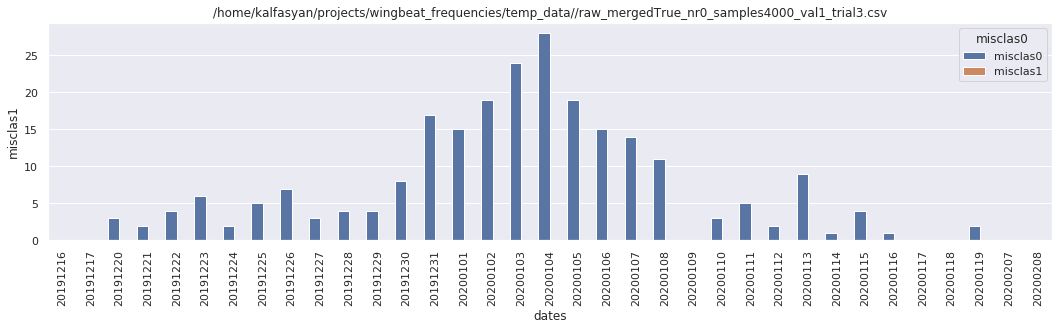

<Figure size 432x288 with 0 Axes>

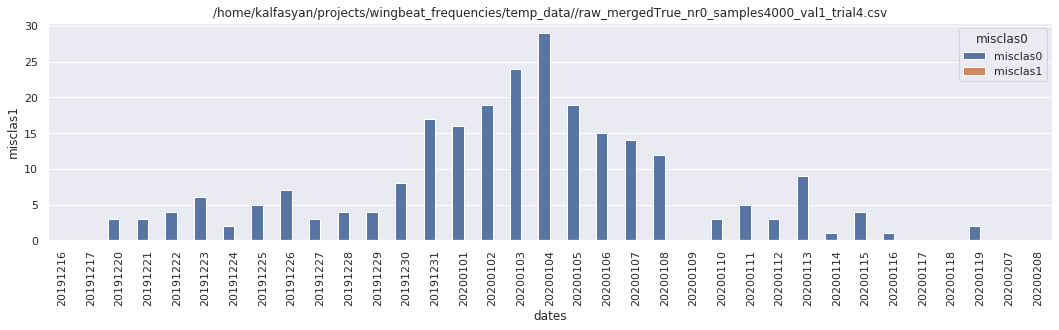

<Figure size 432x288 with 0 Axes>

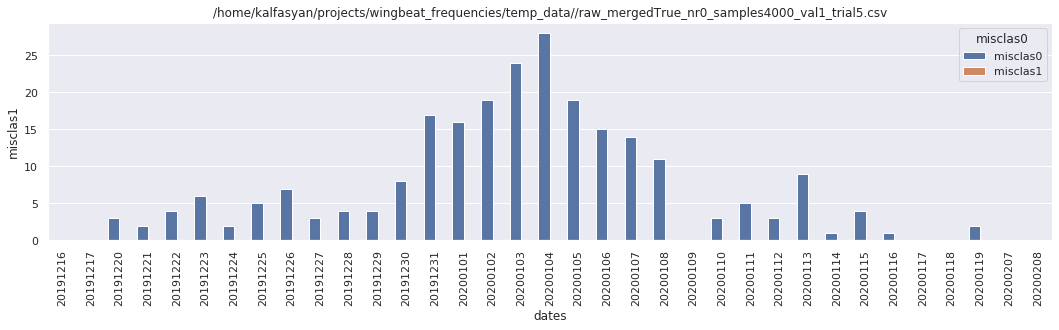

<Figure size 432x288 with 0 Axes>

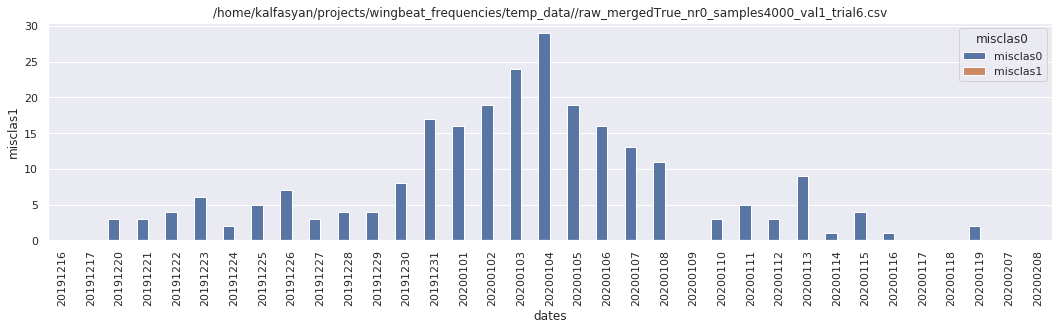

<Figure size 432x288 with 0 Axes>

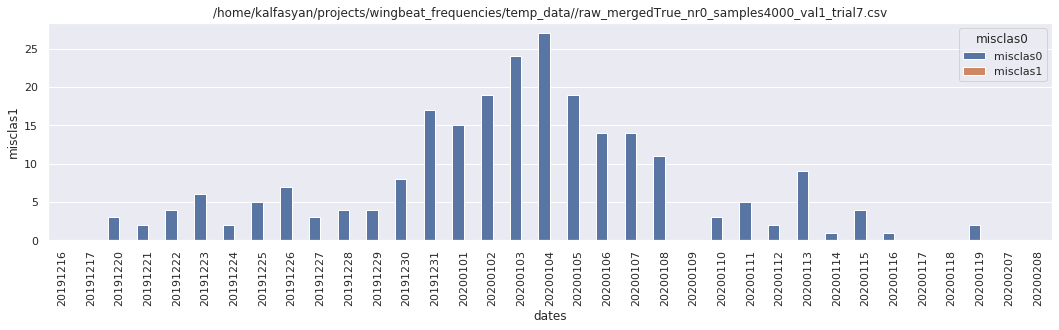

<Figure size 432x288 with 0 Axes>

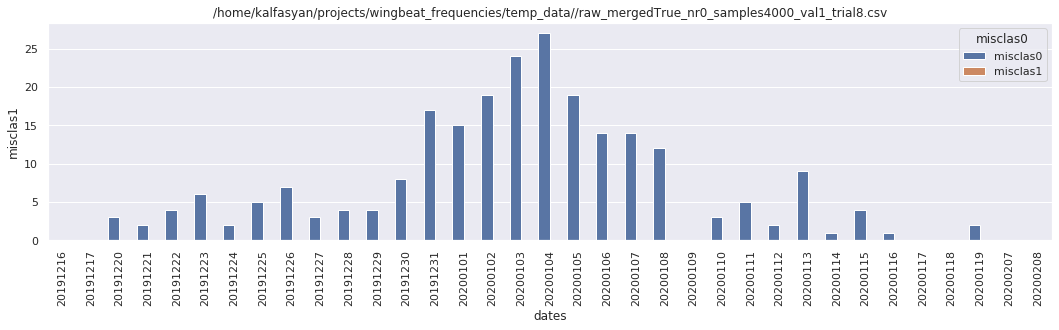

<Figure size 432x288 with 0 Axes>

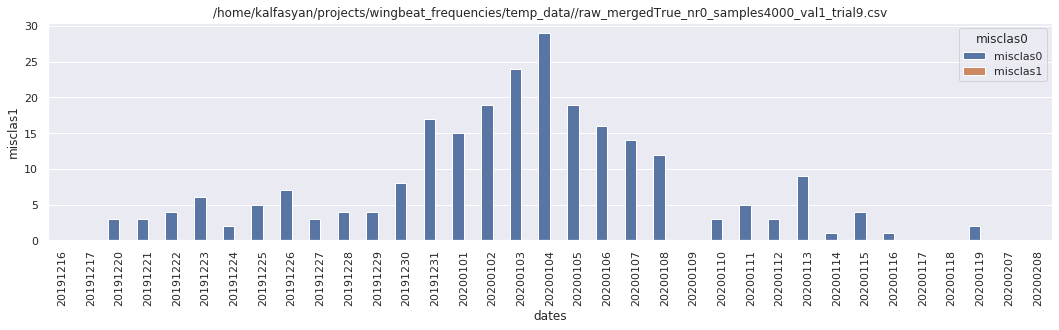

<Figure size 432x288 with 0 Axes>

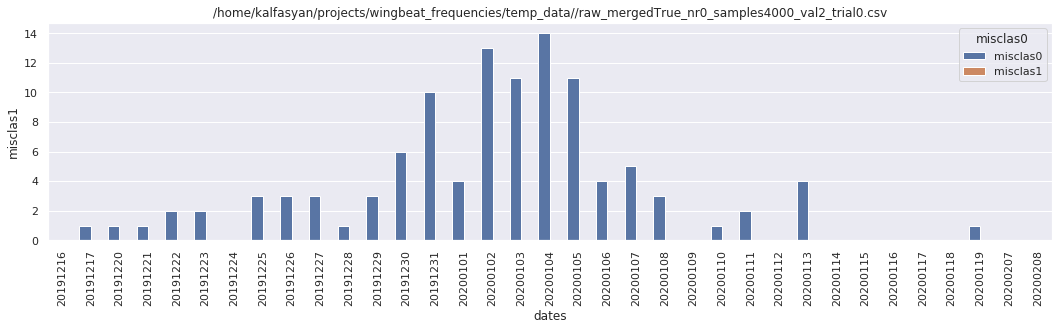

<Figure size 432x288 with 0 Axes>

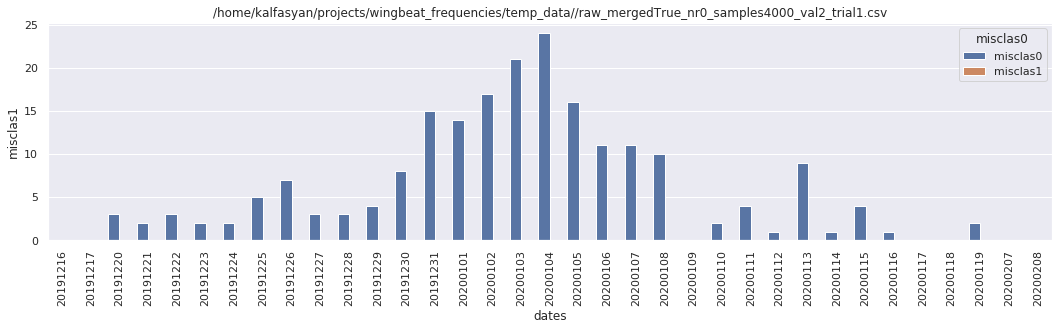

<Figure size 432x288 with 0 Axes>

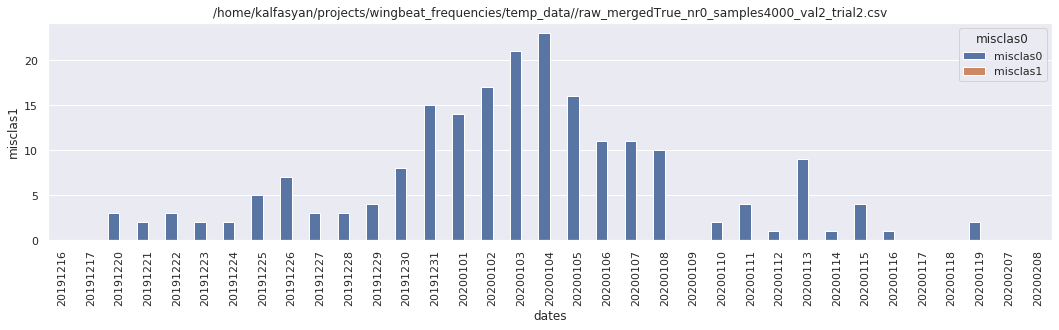

<Figure size 432x288 with 0 Axes>

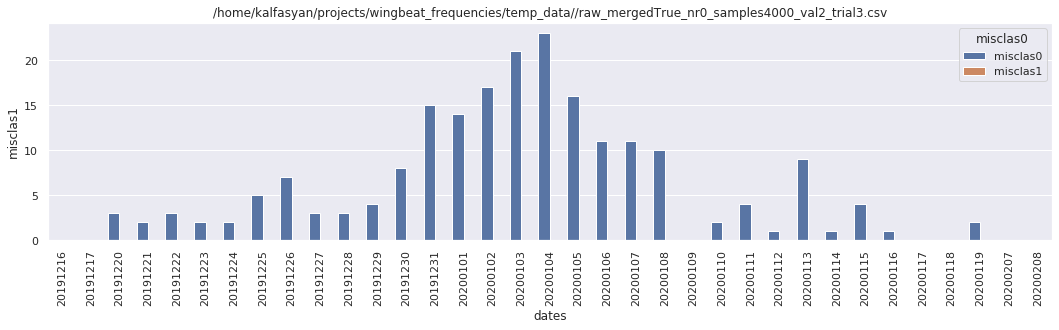

<Figure size 432x288 with 0 Axes>

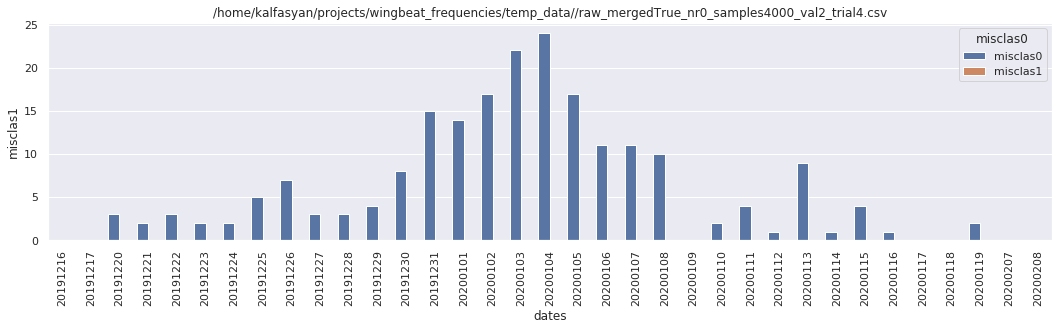

<Figure size 432x288 with 0 Axes>

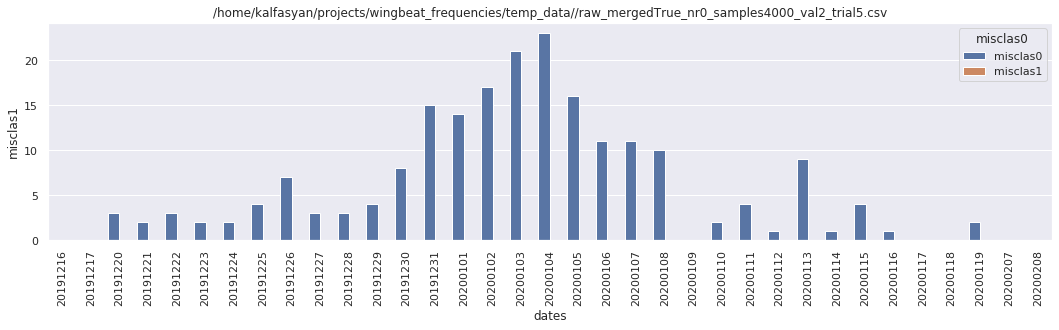

<Figure size 432x288 with 0 Axes>

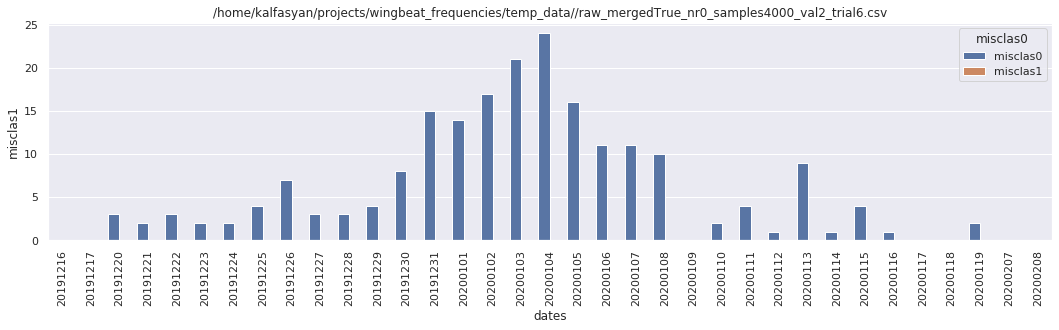

<Figure size 432x288 with 0 Axes>

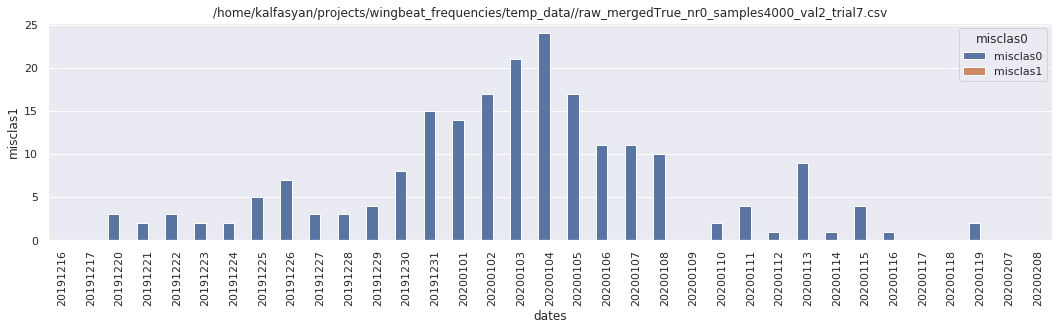

<Figure size 432x288 with 0 Axes>

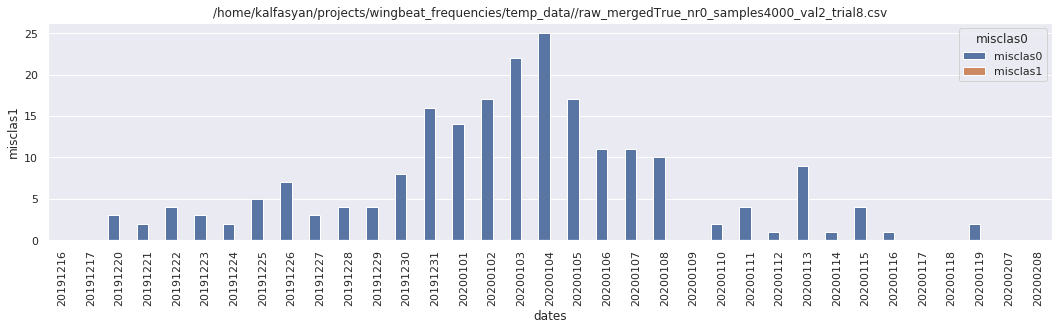

<Figure size 432x288 with 0 Axes>

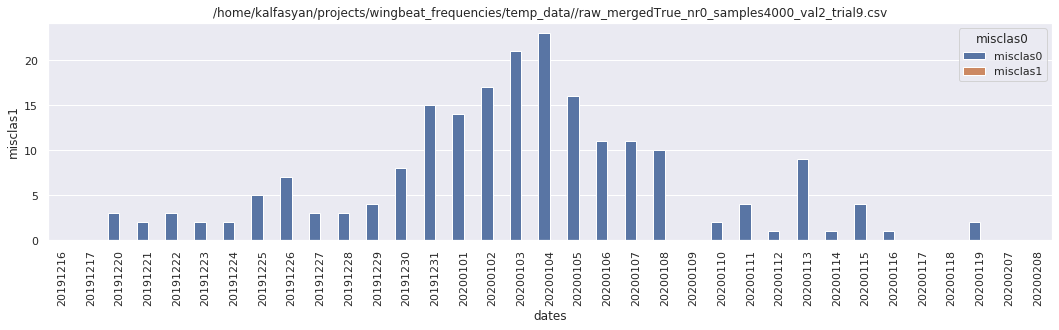

<Figure size 432x288 with 0 Axes>

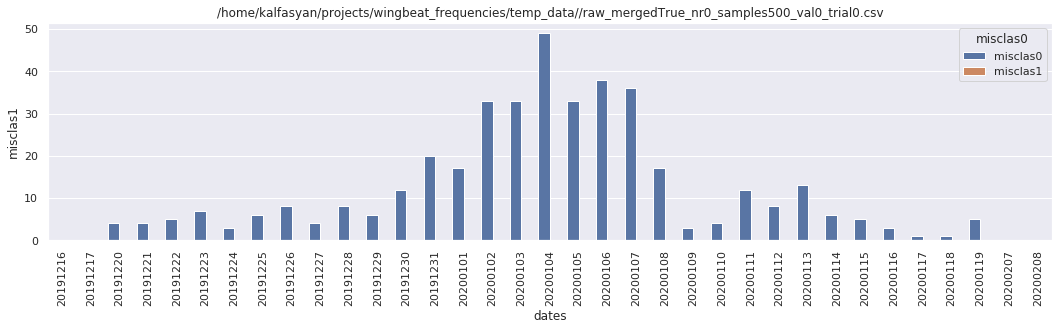

<Figure size 432x288 with 0 Axes>

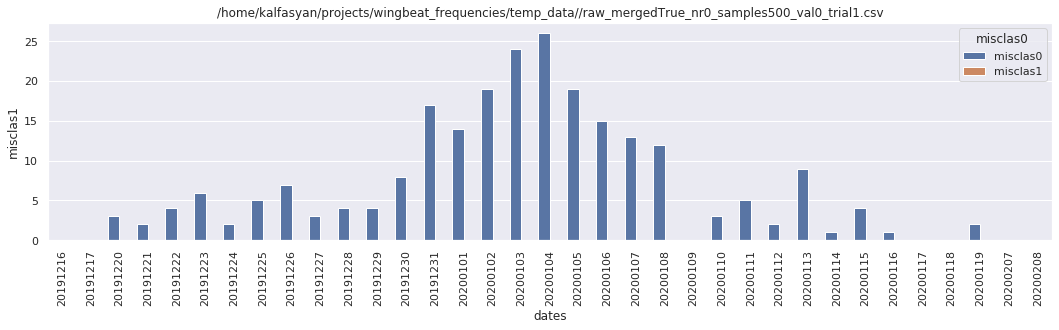

<Figure size 432x288 with 0 Axes>

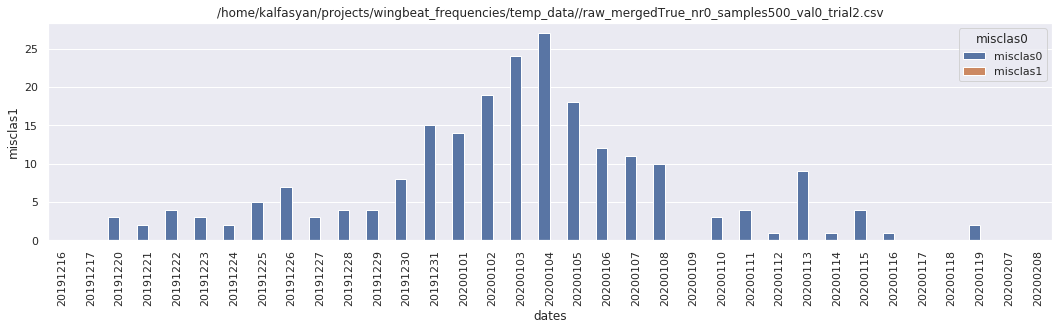

<Figure size 432x288 with 0 Axes>

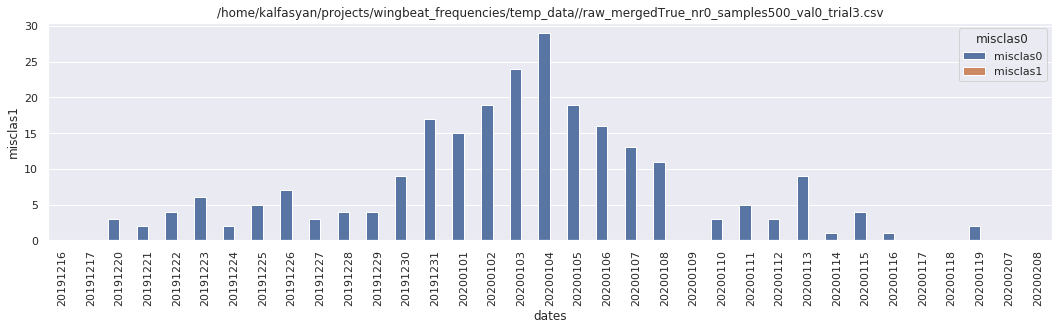

<Figure size 432x288 with 0 Axes>

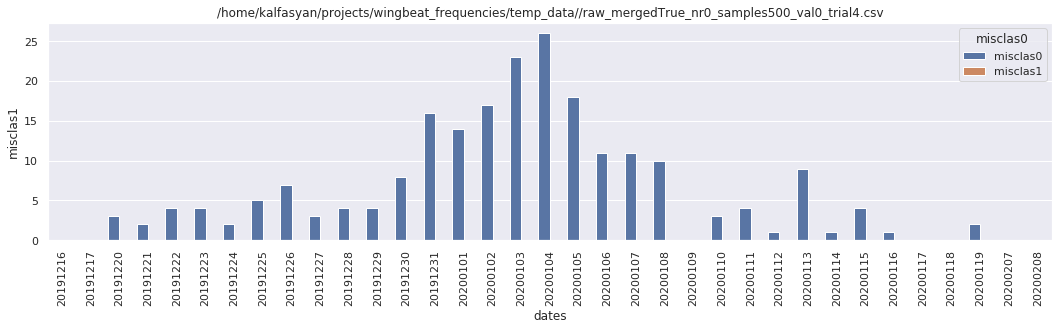

<Figure size 432x288 with 0 Axes>

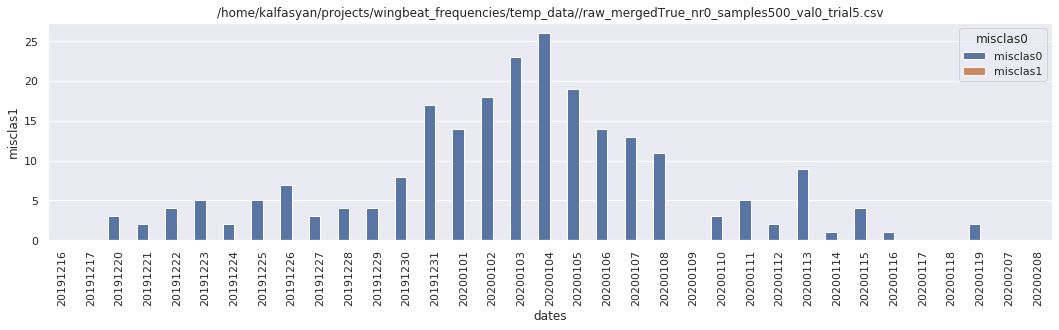

<Figure size 432x288 with 0 Axes>

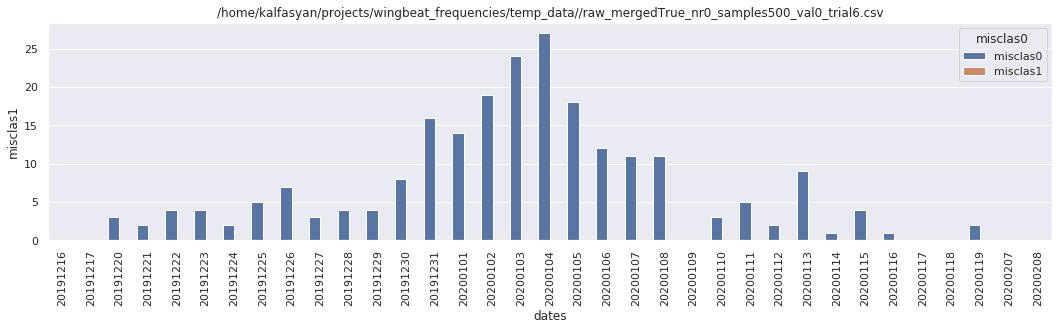

<Figure size 432x288 with 0 Axes>

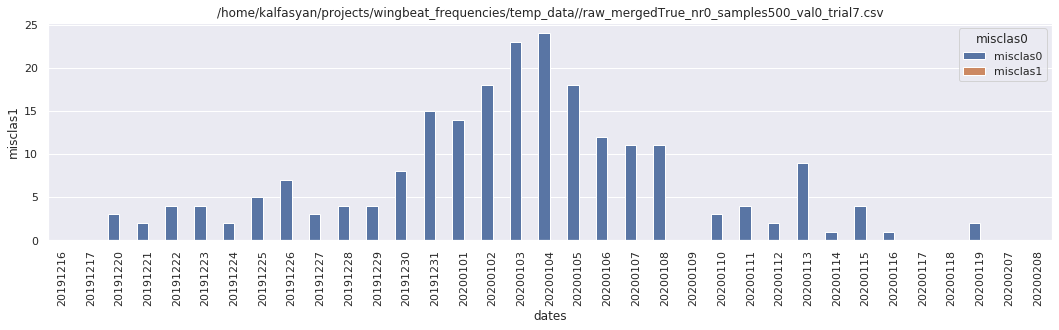

<Figure size 432x288 with 0 Axes>

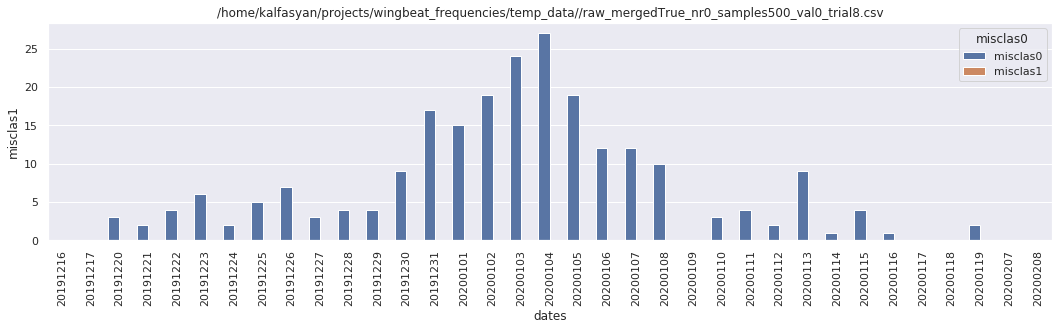

<Figure size 432x288 with 0 Axes>

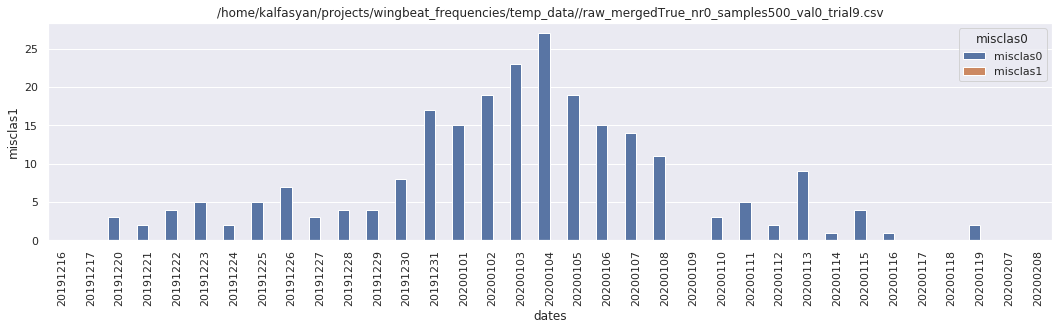

<Figure size 432x288 with 0 Axes>

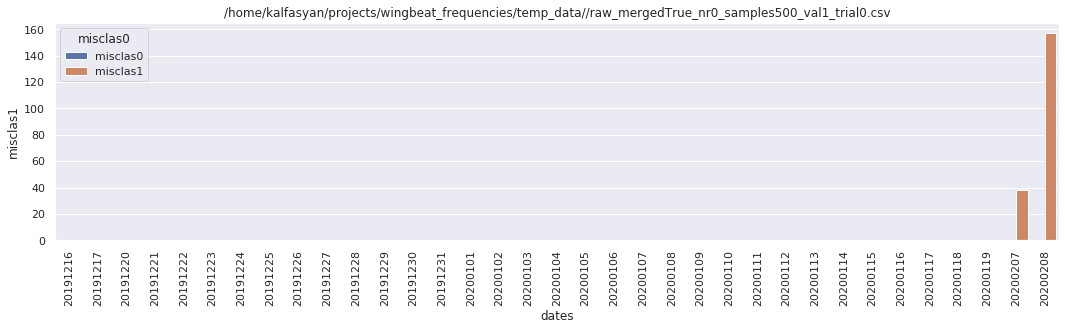

<Figure size 432x288 with 0 Axes>

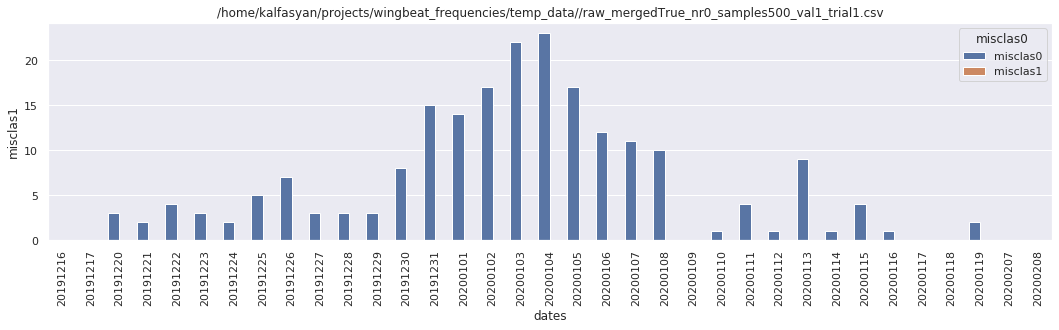

<Figure size 432x288 with 0 Axes>

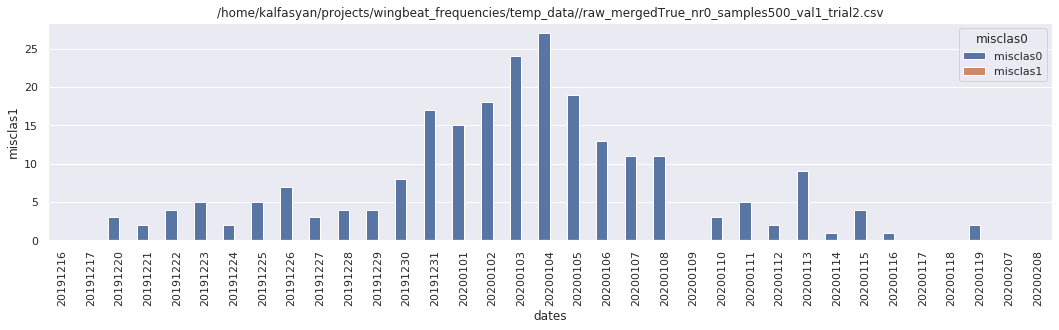

<Figure size 432x288 with 0 Axes>

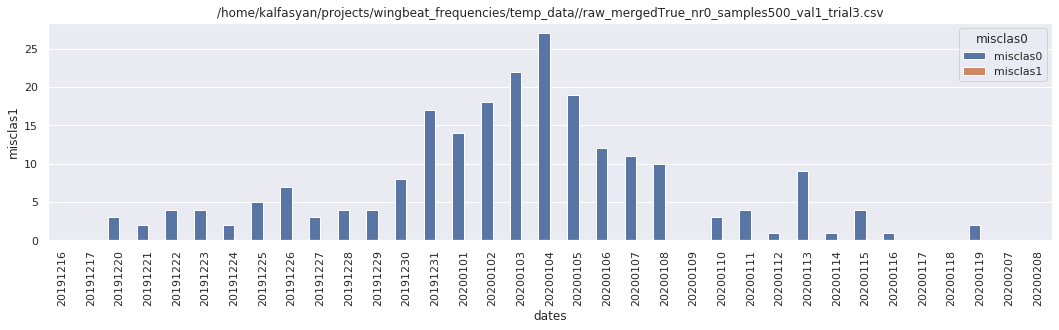

<Figure size 432x288 with 0 Axes>

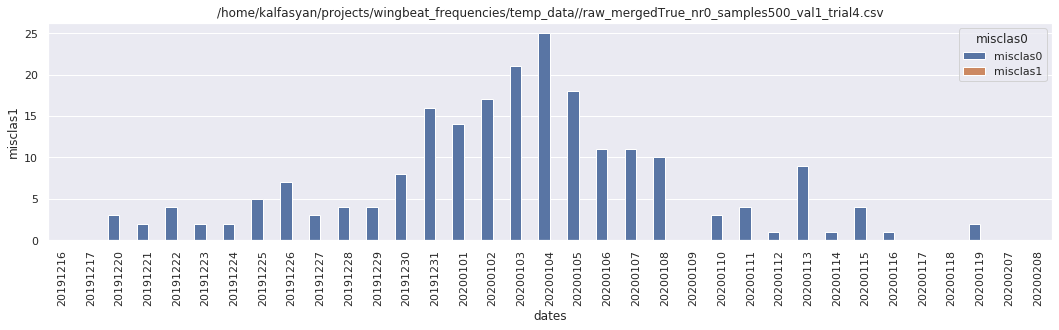

<Figure size 432x288 with 0 Axes>

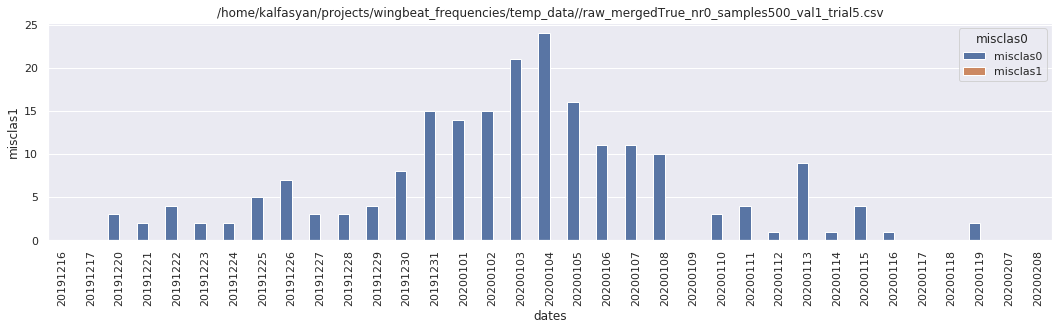

<Figure size 432x288 with 0 Axes>

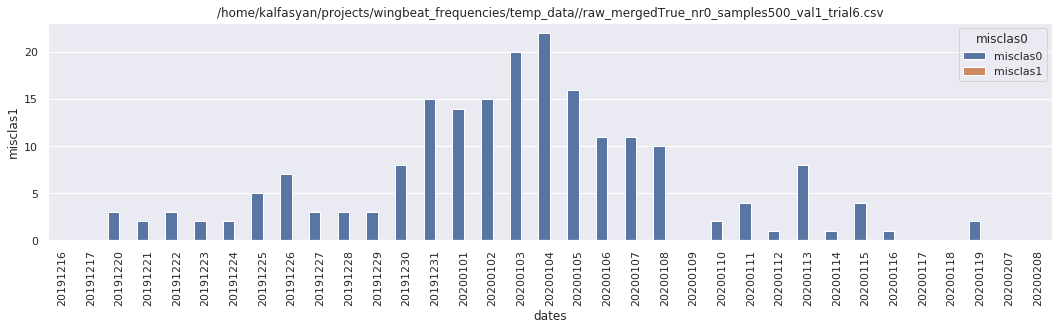

<Figure size 432x288 with 0 Axes>

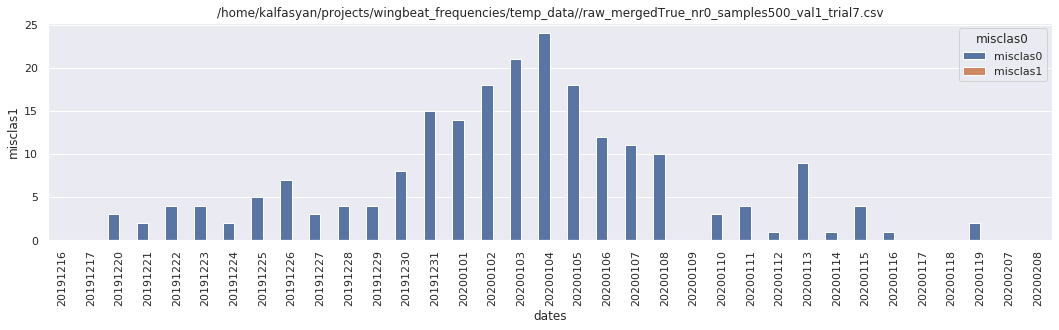

<Figure size 432x288 with 0 Axes>

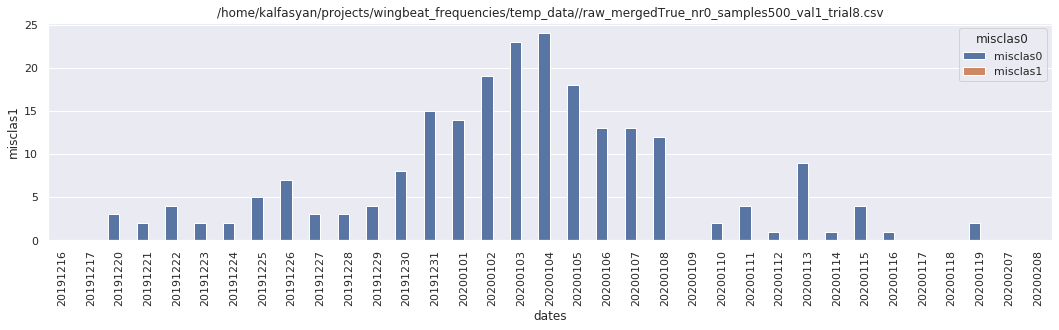

In [ ]:
from wavhandler import get_wingbeat_dates
import seaborn as sns

settings = []

for i, sub in df.groupby(['merged','nrlayers','samples','val']):
    cm_list = []
    setting = f"{sub.dtype.unique()[0]}_{sub.merged.unique()[0]}_{sub.nrlayers.unique()[0]}_{sub.samples.unique()[0]}_{sub.val.unique()[0]}_{sub.trial.unique()[0]}"
    settings.append(setting)
    for s in range(10):
        filepath = f"{TEMP_DATADIR}/{sub.dtype.unique()[0]}_{sub.merged.iloc[0]}_{sub.nrlayers.iloc[0]}_{sub.samples.iloc[0]}_{sub.val.iloc[0]}_trial{s}.csv"
        rezult = dd.io.load(filepath)
        gather_misclassifications(results=rezult, title=filepath)
        plt.savefig(f'/home/kalfasyan/Desktop/results/{data_setting}_{merged}/cm_{fix_setting_label(title)}.png', format='png', bbox_inches='tight')
#     break

In [14]:
# for s in list(metric.keys()):
# #     print(metric[s])
#     tmp_df = pd.DataFrame(metric[s])
    
#     cms = []
#     for z in range(tmp_df.shape[1]):
#         a=tmp_df.iloc[:,z].apply(lambda x: x[0]).mean()
#         b=tmp_df.iloc[:,z].apply(lambda x: x[1]).mean()

#         cms.append(np.vstack((a,b)))
#     for ii, c in enumerate(cms):
#         plt.figure()
#         sb.heatmap(c, annot=True, fmt='g', vmin=0, vmax=1028, cbar=True, xticklabels=False, yticklabels=False)
#         plt.title(s)
#         plt.savefig(f'/home/yannis/Desktop/{s}_{ii}_confmat.png',bbox_inches = 'tight',pad_inches = 0 )
#         plt.close()

In [186]:
# remove_one = False
# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     if setting.endswith('nr5') and remove_one:
#         continue
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['balanced_accuracy_score']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
    
#     plt.plot(tmp_df.median(axis=0), linewidth=3)
# tmpst = settings

# fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/mergedTrue*")))

# df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
# df = df[0].apply(pd.Series)
# df.columns = ['merged','frozen','nrlayers','shallowtrained','trial']

# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     if setting.endswith('nr5') and remove_one:
#         continue
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['balanced_accuracy_score']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
    
#     plt.plot(tmp_df.median(axis=0), linewidth=3, linestyle='dashed')
#     plt.xticks(fontsize=16, rotation=45)
#     plt.yticks(fontsize=16)

# simple_labels = {}
# all_labels = tmpst+settings
# simple_labels['mergedFalse_frozenFalse_nr0'] = 'unmerged_finetuneALL'
# simple_labels['mergedFalse_frozenTrue_nr15'] = 'unmerged_finetuneLITTLE'
# simple_labels['mergedFalse_frozenTrue_nr19'] = 'unmerged_finetuneNONE'
# simple_labels['mergedFalse_frozenTrue_nr5'] = 'unmerged_finetuneMORE'
# simple_labels['mergedTrue_frozenFalse_nr0'] = 'merged_finetuneALL'
# simple_labels['mergedTrue_frozenTrue_nr15'] = 'merged_finetuneLITTLE'
# simple_labels['mergedTrue_frozenTrue_nr19'] = 'merged_finetuneNONE'
# simple_labels['mergedTrue_frozenTrue_nr5'] = 'merged_finetuneMORE'

# legend = [simple_labels.get(item,item)  for item in all_labels]

# plt.legend(legend)
# plt.ylim(0.65,0.75)

## Mean

In [187]:
# plt.figure(figsize=(20,12))

# fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/mergedFalse*")))

# df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
# df = df[0].apply(pd.Series)
# df.columns = ['merged','frozen','nrlayers','shallowtrained','trial']
# remove_one = False
# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     if setting.endswith('nr5') and remove_one:
#         continue
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['balanced_accuracy_score']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
    
#     plt.plot(tmp_df.mean(axis=0), linewidth=3)
# tmpst = settings

# fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/mergedTrue*")))

# df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
# df = df[0].apply(pd.Series)
# df.columns = ['merged','frozen','nrlayers','shallowtrained','trial']

# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     if setting.endswith('nr5') and remove_one:
#         continue
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['balanced_accuracy_score']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
    
#     plt.plot(tmp_df.mean(axis=0), linewidth=3, linestyle='dashed')
#     plt.xticks(fontsize=16, rotation=45)
#     plt.yticks(fontsize=16)

# simple_labels = {}
# all_labels = tmpst+settings
# simple_labels['mergedFalse_frozenFalse_nr0'] = 'unmerged_finetuneALL'
# simple_labels['mergedFalse_frozenTrue_nr15'] = 'unmerged_finetuneLITTLE'
# simple_labels['mergedFalse_frozenTrue_nr19'] = 'unmerged_finetuneNONE'
# simple_labels['mergedFalse_frozenTrue_nr5'] = 'unmerged_finetuneMORE'
# simple_labels['mergedTrue_frozenFalse_nr0'] = 'merged_finetuneALL'
# simple_labels['mergedTrue_frozenTrue_nr15'] = 'merged_finetuneLITTLE'
# simple_labels['mergedTrue_frozenTrue_nr19'] = 'merged_finetuneNONE'
# simple_labels['mergedTrue_frozenTrue_nr5'] = 'merged_finetuneMORE'

# legend = [simple_labels.get(item,item)  for item in all_labels]

# plt.legend(legend)
# plt.ylim(0.65,0.75)

### One choice of merged/notmerged

In [188]:
# plt.figure(figsize=(20,12))

# fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/mergedTrue*")))

# df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
# df = df[0].apply(pd.Series)
# df.columns = ['merged','frozen','nrlayers','shallowtrained','trial']

# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     if setting.endswith('nr5') and remove_one:
#         continue
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['balanced_accuracy_score']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
    
#     plt.plot(tmp_df.mean(axis=0), linewidth=3)
#     plt.xticks(fontsize=16, rotation=45)
#     plt.yticks(fontsize=16)

# simple_labels = {}
# all_labels = settings
# simple_labels['mergedFalse_frozenFalse_nr0'] = 'unmerged_finetuneALL'
# simple_labels['mergedFalse_frozenTrue_nr15'] = 'unmerged_finetuneLITTLE'
# simple_labels['mergedFalse_frozenTrue_nr19'] = 'unmerged_finetuneNONE'
# simple_labels['mergedFalse_frozenTrue_nr5'] = 'unmerged_finetuneMORE'
# simple_labels['mergedTrue_frozenFalse_nr0'] = 'merged_finetuneALL'
# simple_labels['mergedTrue_frozenTrue_nr15'] = 'merged_finetuneLITTLE'
# simple_labels['mergedTrue_frozenTrue_nr19'] = 'merged_finetuneNONE'
# simple_labels['mergedTrue_frozenTrue_nr5'] = 'merged_finetuneMORE'

# legend = [simple_labels.get(item,item)  for item in all_labels]

# plt.legend(legend, loc=2, prop={'size': 22})
# plt.ylim(0.65,0.75)

### Examining one setting

In [189]:
# sub # for last setting in loop

In [190]:
# plt.figure(figsize=(20,12))
# plt.plot(pd.DataFrame(summary[setting]).mean(axis=0), linewidth=3)
# plt.ylim(0.65,0.725)

In [191]:
# plt.figure(figsize=(20,12))
# plt.plot(tmp_df.T, linewidth=3)
# plt.ylim(0.5,0.725)

In [192]:
# fnamelist = natsorted(list(iglob(f"{TEMP_DATADIR}/mergedFalse*")))

# df = pd.DataFrame(pd.Series(fnamelist).apply(lambda x: x.split('/')[-1][:-4].split('_')))
# df = df[0].apply(pd.Series)
# df.columns = ['merged','frozen','nrlayers','shallowtrained','trial']

# summary = {}
# settings = []
# for i, sub in df.groupby(['merged','frozen','nrlayers']):
#     setting = f"{sub.merged.unique()[0]}_{sub.frozen.unique()[0]}_{sub.nrlayers.unique()[0]}"
#     settings.append(setting)
#     summary[setting] = []
#     for j, q in sub.iterrows():
#         results = dd.io.load(f"{TEMP_DATADIR}/{q.merged}_{q.frozen}_{q.nrlayers}_TrShallowTrue_{q.trial}.csv")
#         samples_results = {}
#         for s in range(len(results)):
#             samples_results[str(results[s]['nr_samples'])] = results[s]['cm']
#         summary[setting].append(samples_results)
    
#     tmp_df = pd.DataFrame(summary[setting])
#     break

In [193]:
# cms = []
# for s in range(tmp_df.shape[1]):
#     a=tmp_df.iloc[:,s].apply(lambda x: x[0]).mean()
#     b=tmp_df.iloc[:,s].apply(lambda x: x[1]).mean()
    
#     cms.append(np.vstack((a,b)))

In [194]:
# tmp_df.iloc[:,s].apply(lambda x: x[0]).mean()

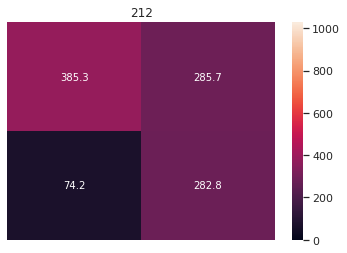

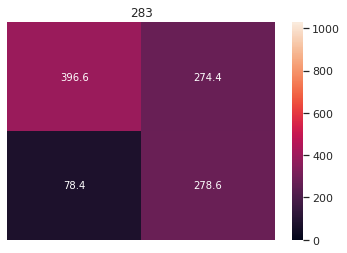

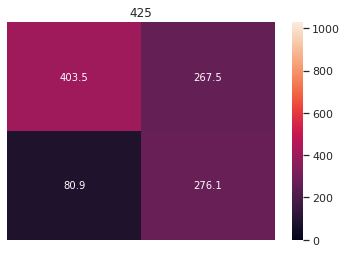

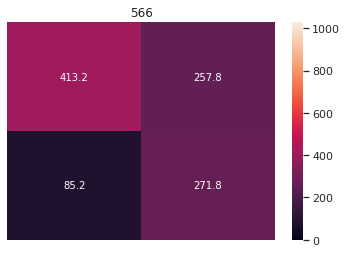

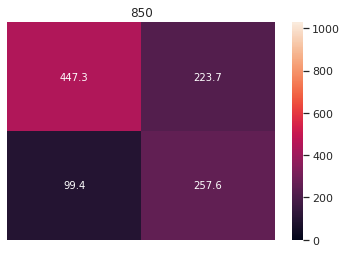

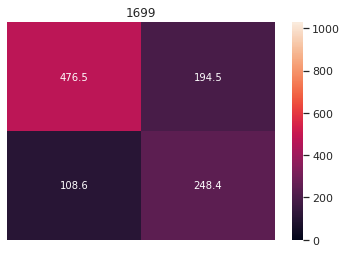

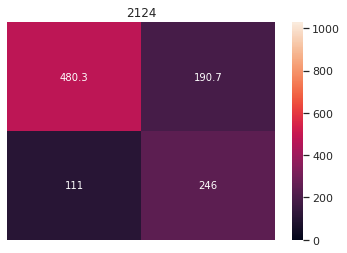

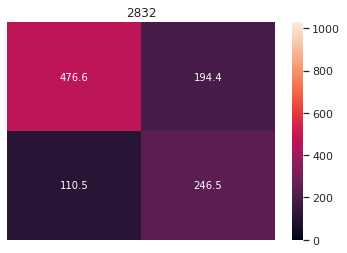

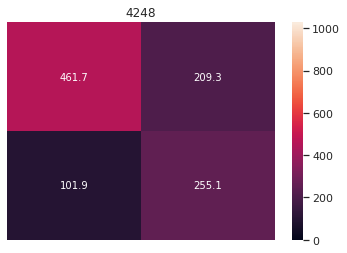

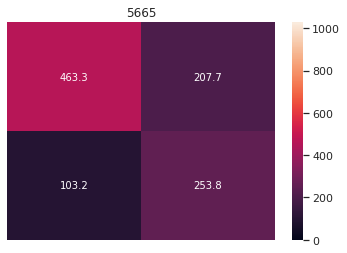

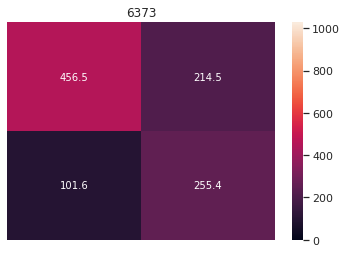

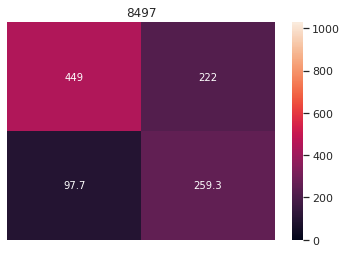

In [108]:

for i,mat in enumerate(cms):
    plt.figure()
    sb.heatmap(mat, annot=True, fmt='g', vmin=0, vmax=1028, cbar=True, xticklabels=False, yticklabels=False)
    plt.title(tmp_df.columns.tolist()[i])
    plt.savefig(f'/home/kalfasyan/Desktop/{tmp_df.columns.tolist()[i]}_confmat.jpg',bbox_inches = 'tight',pad_inches = 0 )